# Forecasting Weekly Hydro Energy Generation in New Zealand
Model - SARIMA

This notebook addresses:
* RQ1: How well does a SARIMA model forecast weekly hydro energy generation?
* RQ2: Does incorporating weekly-aggregated climate variables into SARIMAX improve forecasting accuracy?

The analysis uses weekly sumed and weekly averaged NASA climate data, aligned with operational hydro generation data.

In [2]:
# Import libraries for sarima model and visuals
import pandas as pd
import numpy as np
import seaborn as sns
import pmdarima as pm
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error


# Hydro - EDA

In [4]:
# Step 1 : Loading previously processed hydro energy generation and climate factors
hydro_energy = pd.read_csv('hydro_data.csv')
daily_all_nsp_evland = pd.read_csv('Hydro_Factor_Daily_EVLAND.csv')
daily_all_nsp_gwetprof = pd.read_csv('Hydro_Factor_Daily_GWETPROF.csv')
daily_all_nsp_prectotcorr = pd.read_csv('Hydro_Factor_Daily_PRECTOTCORR.csv')
daily_all_nsp_rh2m = pd.read_csv('Hydro_Factor_Daily_RH2M.csv')
daily_all_nsp_t2m = pd.read_csv('Hydro_Factor_Daily_T2M.csv')

In [5]:
hydro_energy.tail()

Fuel_Code POC_Code        DATE   Total_TP Island   Latitude   Longitude
132197     Hydro  WTK0111  2025-01-27  1427007.0     SI -44.692099  170.429029
132198     Hydro  WTK0111  2025-01-28  1990551.0     SI -44.692099  170.429029
132199     Hydro  WTK0111  2025-01-29  1720931.0     SI -44.692099  170.429029
132200     Hydro  WTK0111  2025-01-30  1407865.0     SI -44.692099  170.429029
132201     Hydro  WTK0111  2025-01-31  1610301.0     SI -44.692099  170.429029

In [6]:
daily_all_nsp_evland.head()

DATE POC_Code  EVLAND
0  2015-01-01  ARA2201    4.03
1  2015-01-02  ARA2201    1.94
2  2015-01-03  ARA2201    2.24
3  2015-01-04  ARA2201    1.54
4  2015-01-05  ARA2201    1.95

In [7]:
print("------------hydro_energy----------------------")
print(hydro_energy.head())
print("----------------------------------------------")
print(hydro_energy.dtypes)
print("----------------------------------------------")
print("------------daily_all_nsp_evland--------------")
print(daily_all_nsp_evland.head())
print("----------------------------------------------")
print(daily_all_nsp_evland.dtypes)
print("----------------------------------------------")
print("-------------daily_all_nsp_gwetprof-----------")
print(daily_all_nsp_gwetprof.head())
print("----------------------------------------------")
print(daily_all_nsp_gwetprof.dtypes)
print("----------------------------------------------")
print("-------------daily_all_nsp_prectotcorr--------")
print(daily_all_nsp_prectotcorr.head())
print("----------------------------------------------")
print(daily_all_nsp_prectotcorr.dtypes)
print("----------------------------------------------")
print("-------------daily_all_nsp_rh2m---------------")
print(daily_all_nsp_rh2m.head())
print("----------------------------------------------")
print(daily_all_nsp_rh2m.dtypes)
print("----------------------------------------------")
print("-------------daily_all_nsp_t2m----------------")
print(daily_all_nsp_t2m.head())
print("----------------------------------------------")
print(daily_all_nsp_t2m.dtypes)
print("----------------------------------------------")

------------hydro_energy----------------------
  Fuel_Code POC_Code        DATE  Total_TP Island   Latitude   Longitude
0     Hydro  ARA2201  2015-03-01  484010.0     NI -38.615891  176.143036
1     Hydro  ARA2201  2015-03-02  598280.0     NI -38.615891  176.143036
2     Hydro  ARA2201  2015-03-03  626290.0     NI -38.615891  176.143036
3     Hydro  ARA2201  2015-03-04  826700.0     NI -38.615891  176.143036
4     Hydro  ARA2201  2015-03-05  891070.0     NI -38.615891  176.143036
----------------------------------------------
Fuel_Code     object
POC_Code      object
DATE          object
Total_TP     float64
Island        object
Latitude     float64
Longitude    float64
dtype: object
----------------------------------------------
------------daily_all_nsp_evland--------------
         DATE POC_Code  EVLAND
0  2015-01-01  ARA2201    4.03
1  2015-01-02  ARA2201    1.94
2  2015-01-03  ARA2201    2.24
3  2015-01-04  ARA2201    1.54
4  2015-01-05  ARA2201    1.95
---------------------------

In [8]:
# As per above output dated field need to convert to date format.

In [9]:
# Date coversion
#daily_all_nsp_evland['DATE'] = pd.to_datetime(daily_all_nsp_evland['DATE'], format='%Y-%m-%d')

hydro_energy['DATE'] = pd.to_datetime(hydro_energy['DATE'], format='%Y-%m-%d')
daily_all_nsp_evland['DATE'] = pd.to_datetime(daily_all_nsp_evland['DATE'], format='%Y-%m-%d')
daily_all_nsp_gwetprof['DATE'] = pd.to_datetime(daily_all_nsp_gwetprof['DATE'], format='%Y-%m-%d')
daily_all_nsp_prectotcorr['DATE'] = pd.to_datetime(daily_all_nsp_prectotcorr['DATE'],  format='%Y-%m-%d')
daily_all_nsp_rh2m['DATE'] = pd.to_datetime(daily_all_nsp_rh2m['DATE'],  format='%Y-%m-%d')
daily_all_nsp_t2m['DATE'] = pd.to_datetime(daily_all_nsp_t2m['DATE'], format='%Y-%m-%d')

In [10]:
# verify the conversion

In [11]:
print("------------hydro_energy----------------------")
print(hydro_energy.head())
print("----------------------------------------------")
print(hydro_energy.dtypes)
print("----------------------------------------------")
print("------------daily_all_nsp_evland--------------")
print(daily_all_nsp_evland.head())
print("----------------------------------------------")
print(daily_all_nsp_evland.dtypes)
print("----------------------------------------------")
print("-------------daily_all_nsp_gwetprof-----------")
print(daily_all_nsp_gwetprof.head())
print("----------------------------------------------")
print(daily_all_nsp_gwetprof.dtypes)
print("----------------------------------------------")
print("-------------daily_all_nsp_prectotcorr--------")
print(daily_all_nsp_prectotcorr.head())
print("----------------------------------------------")
print(daily_all_nsp_prectotcorr.dtypes)
print("----------------------------------------------")
print("-------------daily_all_nsp_rh2m---------------")
print(daily_all_nsp_rh2m.head())
print("----------------------------------------------")
print(daily_all_nsp_rh2m.dtypes)
print("----------------------------------------------")
print("-------------daily_all_nsp_t2m----------------")
print(daily_all_nsp_t2m.head())
print("----------------------------------------------")
print(daily_all_nsp_t2m.dtypes)
print("----------------------------------------------")

------------hydro_energy----------------------
  Fuel_Code POC_Code       DATE  Total_TP Island   Latitude   Longitude
0     Hydro  ARA2201 2015-03-01  484010.0     NI -38.615891  176.143036
1     Hydro  ARA2201 2015-03-02  598280.0     NI -38.615891  176.143036
2     Hydro  ARA2201 2015-03-03  626290.0     NI -38.615891  176.143036
3     Hydro  ARA2201 2015-03-04  826700.0     NI -38.615891  176.143036
4     Hydro  ARA2201 2015-03-05  891070.0     NI -38.615891  176.143036
----------------------------------------------
Fuel_Code            object
POC_Code             object
DATE         datetime64[ns]
Total_TP            float64
Island               object
Latitude            float64
Longitude           float64
dtype: object
----------------------------------------------
------------daily_all_nsp_evland--------------
        DATE POC_Code  EVLAND
0 2015-01-01  ARA2201    4.03
1 2015-01-02  ARA2201    1.94
2 2015-01-03  ARA2201    2.24
3 2015-01-04  ARA2201    1.54
4 2015-01-05  ARA220

In [12]:
# Get list of POC codes to load
unique_pocs_hydro = hydro_energy['POC_Code'].unique()
# unique_pocs_hydro = hydro_energy['POC_Code'].unique()

In [13]:
print(unique_pocs_hydro)
print(len(unique_pocs_hydro))
print(len(hydro_energy))
print("Min DATE:", hydro_energy['DATE'].min())
print("Max DATE:", hydro_energy['DATE'].max())

['ARA2201' 'ARG1101' 'ARI1101' 'ARI1102' 'ASB0661' 'ATI2201' 'AVI2201'
 'BEN2202' 'BWK1101' 'COL0661' 'CYD0331' 'CYD2201' 'HWA1101' 'HWB0331'
 'KPO1101' 'MAN2201' 'MAT1101' 'MHO0331' 'MTI2201' 'NSY0331' 'OHA2201'
 'OHB2201' 'OHC2201' 'OHK2201' 'ROT1101' 'ROX1101' 'ROX2201' 'RPO2201'
 'STK0661' 'TGA0331' 'TKA0111' 'TKB2201' 'TKU2201' 'TUI1101' 'WKM2201'
 'WPA2201' 'WPG0331' 'WTK0111']
38
132202
Min DATE: 2015-03-01 00:00:00
Max DATE: 2025-01-31 00:00:00


In [14]:
# hydro_energy.tail()

In [15]:
# Get list of POC codes to evland and it's records counts. 
unique_pocs_evland = daily_all_nsp_evland['POC_Code'].unique()
print(unique_pocs_evland)
print(len(unique_pocs_evland))
print(len(daily_all_nsp_evland))
print("Min DATE:", daily_all_nsp_evland['DATE'].min())
print("Max DATE:", daily_all_nsp_evland['DATE'].max())

['ARA2201' 'ARG1101' 'ARI1101' 'ARI1102' 'ASB0661' 'ATI2201' 'AVI2201'
 'BEN2202' 'BWK1101' 'COL0661' 'CYD0331' 'CYD2201' 'HWA1101' 'HWB0331'
 'KPO1101' 'MAN2201' 'MAT1101' 'MHO0331' 'MTI2201' 'NSY0331' 'OHA2201'
 'OHB2201' 'OHC2201' 'OHK2201' 'ROT1101' 'ROX1101' 'ROX2201' 'RPO2201'
 'STK0661' 'TGA0331' 'TKA0111' 'TKB2201' 'TKU2201' 'TUI1101' 'WKM2201'
 'WPA2201' 'WPG0331' 'WTK0111']
38
141056
Min DATE: 2015-01-01 00:00:00
Max DATE: 2025-02-28 00:00:00


In [16]:
# Get list of POC codes to gwetprof
unique_pocs_gwetprof = daily_all_nsp_gwetprof['POC_Code'].unique()
print(unique_pocs_gwetprof)
print(len(unique_pocs_gwetprof))
print(len(daily_all_nsp_gwetprof))
print("Min DATE:", daily_all_nsp_gwetprof['DATE'].min())
print("Max DATE:", daily_all_nsp_gwetprof['DATE'].max())

['ARA2201' 'ARG1101' 'ARI1101' 'ARI1102' 'ASB0661' 'ATI2201' 'AVI2201'
 'BEN2202' 'BWK1101' 'COL0661' 'CYD0331' 'CYD2201' 'HWA1101' 'HWB0331'
 'KPO1101' 'MAN2201' 'MAT1101' 'MHO0331' 'MTI2201' 'NSY0331' 'OHA2201'
 'OHB2201' 'OHC2201' 'OHK2201' 'ROT1101' 'ROX1101' 'ROX2201' 'RPO2201'
 'STK0661' 'TGA0331' 'TKA0111' 'TKB2201' 'TKU2201' 'TUI1101' 'WKM2201'
 'WPA2201' 'WPG0331' 'WTK0111']
38
141056
Min DATE: 2015-01-01 00:00:00
Max DATE: 2025-02-28 00:00:00


In [17]:
# Get list of POC codes to prectotcorr
unique_pocs_prectotcorr = daily_all_nsp_prectotcorr['POC_Code'].unique()
print(unique_pocs_prectotcorr)
print(len(unique_pocs_prectotcorr))
print(len(daily_all_nsp_prectotcorr))
print("Min DATE:", daily_all_nsp_prectotcorr['DATE'].min())
print("Max DATE:", daily_all_nsp_prectotcorr['DATE'].max())

['ARA2201' 'ARG1101' 'ARI1101' 'ARI1102' 'ASB0661' 'ATI2201' 'AVI2201'
 'BEN2202' 'BWK1101' 'COL0661' 'CYD0331' 'CYD2201' 'HWA1101' 'HWB0331'
 'KPO1101' 'MAN2201' 'MAT1101' 'MHO0331' 'MTI2201' 'NSY0331' 'OHA2201'
 'OHB2201' 'OHC2201' 'OHK2201' 'ROT1101' 'ROX1101' 'ROX2201' 'RPO2201'
 'STK0661' 'TGA0331' 'TKA0111' 'TKB2201' 'TKU2201' 'TUI1101' 'WKM2201'
 'WPA2201' 'WPG0331' 'WTK0111']
38
141056
Min DATE: 2015-01-01 00:00:00
Max DATE: 2025-02-28 00:00:00


In [18]:
# Get list of POC codes to rh2m
unique_pocs_rh2m = daily_all_nsp_rh2m['POC_Code'].unique()
print(unique_pocs_rh2m)
print(len(unique_pocs_rh2m))
print(len(daily_all_nsp_rh2m))
print("Min DATE:", daily_all_nsp_rh2m['DATE'].min())
print("Max DATE:", daily_all_nsp_rh2m['DATE'].max())

# print(daily_all_nsp_rh2m.dtypes)
# print("----------------------------------------------")
# print("-------------daily_all_nsp_t2m----------------")
# print(daily_all_nsp_t2m.head())

['ARA2201' 'ARG1101' 'ARI1101' 'ARI1102' 'ASB0661' 'ATI2201' 'AVI2201'
 'BEN2202' 'BWK1101' 'COL0661' 'CYD0331' 'CYD2201' 'HWA1101' 'HWB0331'
 'KPO1101' 'MAN2201' 'MAT1101' 'MHO0331' 'MTI2201' 'NSY0331' 'OHA2201'
 'OHB2201' 'OHC2201' 'OHK2201' 'ROT1101' 'ROX1101' 'ROX2201' 'RPO2201'
 'STK0661' 'TGA0331' 'TKA0111' 'TKB2201' 'TKU2201' 'TUI1101' 'WKM2201'
 'WPA2201' 'WPG0331' 'WTK0111']
38
141056
Min DATE: 2015-01-01 00:00:00
Max DATE: 2025-02-28 00:00:00


In [19]:
# Get list of POC codes to t2m
unique_pocs_t2m = daily_all_nsp_t2m['POC_Code'].unique()
print(unique_pocs_t2m)
print(len(unique_pocs_t2m))
print(len(daily_all_nsp_t2m))
print("Min DATE:", daily_all_nsp_t2m['DATE'].min())
print("Max DATE:", daily_all_nsp_t2m['DATE'].max())

# print(daily_all_nsp_rh2m.dtypes)
# print("----------------------------------------------")
# print("-------------daily_all_nsp_t2m----------------")
# print(daily_all_nsp_t2m.head())

['ARA2201' 'ARG1101' 'ARI1101' 'ARI1102' 'ASB0661' 'ATI2201' 'AVI2201'
 'BEN2202' 'BWK1101' 'COL0661' 'CYD0331' 'CYD2201' 'HWA1101' 'HWB0331'
 'KPO1101' 'MAN2201' 'MAT1101' 'MHO0331' 'MTI2201' 'NSY0331' 'OHA2201'
 'OHB2201' 'OHC2201' 'OHK2201' 'ROT1101' 'ROX1101' 'ROX2201' 'RPO2201'
 'STK0661' 'TGA0331' 'TKA0111' 'TKB2201' 'TKU2201' 'TUI1101' 'WKM2201'
 'WPA2201' 'WPG0331' 'WTK0111']
38
141056
Min DATE: 2015-01-01 00:00:00
Max DATE: 2025-02-28 00:00:00


In [20]:
# Filter data between 2015-03-01 and 2025-01-31
filtered_daily_all_nsp_t2m = daily_all_nsp_t2m[(daily_all_nsp_t2m['DATE'] >= '2015-03-01') & (daily_all_nsp_t2m['DATE'] < '2025-02-01')]
filtered_daily_all_nsp_evland = daily_all_nsp_evland[(daily_all_nsp_evland['DATE'] >= '2015-03-01') & (daily_all_nsp_evland['DATE'] < '2025-02-01')]
filtered_daily_all_nsp_gwetprof = daily_all_nsp_gwetprof[(daily_all_nsp_gwetprof['DATE'] >= '2015-03-01') & (daily_all_nsp_gwetprof['DATE'] < '2025-02-01')]
filtered_daily_all_nsp_prectotcorr = daily_all_nsp_prectotcorr[(daily_all_nsp_prectotcorr['DATE'] >= '2015-03-01') & (daily_all_nsp_prectotcorr['DATE'] < '2025-02-01')]
filtered_daily_all_nsp_rh2m = daily_all_nsp_rh2m[(daily_all_nsp_rh2m['DATE'] >= '2015-03-01') & (daily_all_nsp_rh2m['DATE'] < '2025-02-01')]


# daily_all_nsp_evland['DATE'] = pd.to_datetime(daily_all_nsp_evland['DATE'], format='%Y-%m-%d')
# daily_all_nsp_gwetprof['DATE'] = pd.to_datetime(daily_all_nsp_gwetprof['DATE'], format='%Y-%m-%d')
# daily_all_nsp_prectotcorr['DATE'] = pd.to_datetime(daily_all_nsp_prectotcorr['DATE'],  format='%Y-%m-%d')
# daily_all_nsp_rh2m['DATE'] = pd.to_datetime(daily_all_nsp_rh2m['DATE'],  format='%Y-%m-%d')
# daily_all_nsp_t2m['DATE'] = pd.to_datetime(daily_all_nsp_t2m['DATE'], format='%Y-%m-%d')

In [21]:
print(len(filtered_daily_all_nsp_t2m))
print("Min DATE:", filtered_daily_all_nsp_t2m['DATE'].min())
print("Max DATE:", filtered_daily_all_nsp_t2m['DATE'].max())
print(len(filtered_daily_all_nsp_prectotcorr))
print("Min DATE:", filtered_daily_all_nsp_prectotcorr['DATE'].min())
print("Max DATE:", filtered_daily_all_nsp_prectotcorr['DATE'].max())

137750
Min DATE: 2015-03-01 00:00:00
Max DATE: 2025-01-31 00:00:00
137750
Min DATE: 2015-03-01 00:00:00
Max DATE: 2025-01-31 00:00:00


In [22]:
filtered_daily_all_nsp_prectotcorr.head()

DATE POC_Code  PRECTOTCORR
59 2015-03-01  ARA2201         0.00
60 2015-03-02  ARA2201         0.00
61 2015-03-03  ARA2201         0.14
62 2015-03-04  ARA2201         1.09
63 2015-03-05  ARA2201         0.01

In [23]:
record_counts_precep = filtered_daily_all_nsp_prectotcorr.groupby('POC_Code').size()
print(record_counts_precep)

POC_Code
ARA2201    3625
ARG1101    3625
ARI1101    3625
ARI1102    3625
ASB0661    3625
ATI2201    3625
AVI2201    3625
BEN2202    3625
BWK1101    3625
COL0661    3625
CYD0331    3625
CYD2201    3625
HWA1101    3625
HWB0331    3625
KPO1101    3625
MAN2201    3625
MAT1101    3625
MHO0331    3625
MTI2201    3625
NSY0331    3625
OHA2201    3625
OHB2201    3625
OHC2201    3625
OHK2201    3625
ROT1101    3625
ROX1101    3625
ROX2201    3625
RPO2201    3625
STK0661    3625
TGA0331    3625
TKA0111    3625
TKB2201    3625
TKU2201    3625
TUI1101    3625
WKM2201    3625
WPA2201    3625
WPG0331    3625
WTK0111    3625
dtype: int64


In [24]:
record_counts_hydro = hydro_energy.groupby('POC_Code').size()
print(record_counts_hydro)

POC_Code
ARA2201    3625
ARG1101    3625
ARI1101    3625
ARI1102    3625
ASB0661    3614
ATI2201    3625
AVI2201    3625
BEN2202    3625
BWK1101    3625
COL0661    3625
CYD0331    1858
CYD2201    3625
HWA1101    3625
HWB0331    1858
KPO1101    3625
MAN2201    3625
MAT1101    3612
MHO0331    3625
MTI2201    3625
NSY0331    3625
OHA2201    3625
OHB2201    3625
OHC2201    3625
OHK2201    3625
ROT1101    3625
ROX1101    3625
ROX2201    3625
RPO2201    3625
STK0661    1858
TGA0331    3412
TKA0111    3625
TKB2201    3625
TKU2201    3625
TUI1101    3625
WKM2201    3625
WPA2201    3625
WPG0331    3615
WTK0111    3625
dtype: int64


In [25]:
# Merge rh2m with prectotcorr
merge1 = pd.merge(filtered_daily_all_nsp_rh2m, filtered_daily_all_nsp_prectotcorr, on=['POC_Code', 'DATE'], how='inner')
print("Merge 1 : rh2m with prectotcorr ", merge1.shape)

Merge 1 : rh2m with prectotcorr  (137750, 4)


In [26]:
merge1.head()

DATE POC_Code   RH2M  PRECTOTCORR
0 2015-03-01  ARA2201  57.62         0.00
1 2015-03-02  ARA2201  68.36         0.00
2 2015-03-03  ARA2201  68.50         0.14
3 2015-03-04  ARA2201  79.20         1.09
4 2015-03-05  ARA2201  69.77         0.01

In [27]:
# Merge merge1 with gwetprof
merge2 = pd.merge(merge1, filtered_daily_all_nsp_gwetprof, on=['POC_Code', 'DATE'], how='inner')
print("Merge 2 : Merge 1 with gwetprof):", merge2.shape)

Merge 2 : Merge 1 with gwetprof): (137750, 5)


In [28]:
merge2.head()

DATE POC_Code   RH2M  PRECTOTCORR  GWETPROF
0 2015-03-01  ARA2201  57.62         0.00      0.19
1 2015-03-02  ARA2201  68.36         0.00      0.19
2 2015-03-03  ARA2201  68.50         0.14      0.19
3 2015-03-04  ARA2201  79.20         1.09      0.19
4 2015-03-05  ARA2201  69.77         0.01      0.19

In [29]:
# Merge merge2 with evland
merge3 = pd.merge(merge2, filtered_daily_all_nsp_evland, on=['POC_Code', 'DATE'], how='inner')
print("Merge 3 : Merge 2 with evland ", merge3.shape)

Merge 3 : Merge 2 with evland  (137750, 6)


In [30]:
merge3.head()

DATE POC_Code   RH2M  PRECTOTCORR  GWETPROF  EVLAND
0 2015-03-01  ARA2201  57.62         0.00      0.19    1.01
1 2015-03-02  ARA2201  68.36         0.00      0.19    0.84
2 2015-03-03  ARA2201  68.50         0.14      0.19    0.45
3 2015-03-04  ARA2201  79.20         1.09      0.19    0.95
4 2015-03-05  ARA2201  69.77         0.01      0.19    0.70

In [31]:
# Merge merge3 with t2m
merge4 = pd.merge(merge3, filtered_daily_all_nsp_t2m, on=['POC_Code', 'DATE'], how='inner',)
print("Merge4 : Merge 3 with t2m :", merge4.shape)

Merge4 : Merge 3 with t2m : (137750, 7)


In [32]:
merge4.head()

DATE POC_Code   RH2M  PRECTOTCORR  GWETPROF  EVLAND    T2M
0 2015-03-01  ARA2201  57.62         0.00      0.19    1.01  19.11
1 2015-03-02  ARA2201  68.36         0.00      0.19    0.84  19.03
2 2015-03-03  ARA2201  68.50         0.14      0.19    0.45  18.00
3 2015-03-04  ARA2201  79.20         1.09      0.19    0.95  16.43
4 2015-03-05  ARA2201  69.77         0.01      0.19    0.70  18.74

In [33]:
merge4.tail()

DATE POC_Code   RH2M  PRECTOTCORR  GWETPROF  EVLAND    T2M
137745 2025-01-27  WTK0111  64.93         1.73      0.44    2.48  10.90
137746 2025-01-28  WTK0111  56.24         0.08      0.43    3.01  14.74
137747 2025-01-29  WTK0111  57.06         0.84      0.43    3.68  17.65
137748 2025-01-30  WTK0111  73.86         0.48      0.43    2.13  14.05
137749 2025-01-31  WTK0111  72.17         0.19      0.42    2.05  15.41

In [34]:
# Merge merge4 with hydro
final_merge = pd.merge(hydro_energy, merge4, on=['POC_Code', 'DATE'], how='left',)
print("final merge : Merge 4 with Hydro Energy ", final_merge.shape)

final merge : Merge 4 with Hydro Energy  (132202, 12)


In [35]:
print("hydro_energy:", hydro_energy.shape) 

hydro_energy: (132202, 7)


In [36]:
final_merge.head()

Fuel_Code POC_Code       DATE  Total_TP Island   Latitude   Longitude  \
0     Hydro  ARA2201 2015-03-01  484010.0     NI -38.615891  176.143036   
1     Hydro  ARA2201 2015-03-02  598280.0     NI -38.615891  176.143036   
2     Hydro  ARA2201 2015-03-03  626290.0     NI -38.615891  176.143036   
3     Hydro  ARA2201 2015-03-04  826700.0     NI -38.615891  176.143036   
4     Hydro  ARA2201 2015-03-05  891070.0     NI -38.615891  176.143036   

    RH2M  PRECTOTCORR  GWETPROF  EVLAND    T2M  
0  57.62         0.00      0.19    1.01  19.11  
1  68.36         0.00      0.19    0.84  19.03  
2  68.50         0.14      0.19    0.45  18.00  
3  79.20         1.09      0.19    0.95  16.43  
4  69.77         0.01      0.19    0.70  18.74

In [37]:
final_merge.tail()

Fuel_Code POC_Code       DATE   Total_TP Island   Latitude   Longitude  \
132197     Hydro  WTK0111 2025-01-27  1427007.0     SI -44.692099  170.429029   
132198     Hydro  WTK0111 2025-01-28  1990551.0     SI -44.692099  170.429029   
132199     Hydro  WTK0111 2025-01-29  1720931.0     SI -44.692099  170.429029   
132200     Hydro  WTK0111 2025-01-30  1407865.0     SI -44.692099  170.429029   
132201     Hydro  WTK0111 2025-01-31  1610301.0     SI -44.692099  170.429029   

         RH2M  PRECTOTCORR  GWETPROF  EVLAND    T2M  
132197  64.93         1.73      0.44    2.48  10.90  
132198  56.24         0.08      0.43    3.01  14.74  
132199  57.06         0.84      0.43    3.68  17.65  
132200  73.86         0.48      0.43    2.13  14.05  
132201  72.17         0.19      0.42    2.05  15.41

In [38]:
all_poc_data = final_merge.copy()

In [39]:
# Write the final merged DataFrame to a CSV file
all_poc_data.to_csv('EDA_Hydro_all_POC_20250602_0700.csv', index=False)

print("Final merge saved to final_merged.csv")

Final merge saved to final_merged.csv


In [40]:
# Check for missing values in each column
missing_values = all_poc_data.isnull().sum()
print(missing_values)

Fuel_Code      0
POC_Code       0
DATE           0
Total_TP       0
Island         0
Latitude       0
Longitude      0
RH2M           0
PRECTOTCORR    0
GWETPROF       0
EVLAND         0
T2M            0
dtype: int64


In [41]:
# check if there are any missing values at all
if all_poc_data.isnull().values.any():
    print("There are missing values in the DataFrame.")
else:
    print("No missing values found in the DataFrame.")

No missing values found in the DataFrame.


In [42]:
# List all column names 
print(all_poc_data.columns)

# list the column names as a list
print(all_poc_data.columns.tolist())

Index(['Fuel_Code', 'POC_Code', 'DATE', 'Total_TP', 'Island', 'Latitude',
       'Longitude', 'RH2M', 'PRECTOTCORR', 'GWETPROF', 'EVLAND', 'T2M'],
      dtype='object')
['Fuel_Code', 'POC_Code', 'DATE', 'Total_TP', 'Island', 'Latitude', 'Longitude', 'RH2M', 'PRECTOTCORR', 'GWETPROF', 'EVLAND', 'T2M']


In [43]:
# selected_columns_POC = ['Fuel_Code','POC_Code', 'DATE','Total_TP', 'PS','T2M','WD50M','WD50M_rad','u','v','WS50M']  # Replace with desired column names


In [44]:
selected_columns_for_hydro = ['DATE','Island','Total_TP', 'RH2M','PRECTOTCORR','GWETPROF','EVLAND','T2M']  # Replace with your desired column names


In [45]:
# df_wind_daily_final_all_POC = final_merge[selected_columns_POC].copy()

In [46]:
df_hydro_daily_all = all_poc_data[selected_columns_for_hydro].copy()

In [47]:
df_hydro_daily_all.head()

DATE Island  Total_TP   RH2M  PRECTOTCORR  GWETPROF  EVLAND    T2M
0 2015-03-01     NI  484010.0  57.62         0.00      0.19    1.01  19.11
1 2015-03-02     NI  598280.0  68.36         0.00      0.19    0.84  19.03
2 2015-03-03     NI  626290.0  68.50         0.14      0.19    0.45  18.00
3 2015-03-04     NI  826700.0  79.20         1.09      0.19    0.95  16.43
4 2015-03-05     NI  891070.0  69.77         0.01      0.19    0.70  18.74

In [48]:
df_hydro_daily_all.set_index('DATE', inplace=True)

In [49]:
df_hydro_daily_all.head()

Island  Total_TP   RH2M  PRECTOTCORR  GWETPROF  EVLAND    T2M
DATE                                                                    
2015-03-01     NI  484010.0  57.62         0.00      0.19    1.01  19.11
2015-03-02     NI  598280.0  68.36         0.00      0.19    0.84  19.03
2015-03-03     NI  626290.0  68.50         0.14      0.19    0.45  18.00
2015-03-04     NI  826700.0  79.20         1.09      0.19    0.95  16.43
2015-03-05     NI  891070.0  69.77         0.01      0.19    0.70  18.74

In [50]:
print(df_hydro_daily_all.dtypes)

Island          object
Total_TP       float64
RH2M           float64
PRECTOTCORR    float64
GWETPROF       float64
EVLAND         float64
T2M            float64
dtype: object


In [51]:
record_counts = df_hydro_daily_all.groupby('Island').size()
print(record_counts)

Island
NI    61399
SI    70803
dtype: int64


In [52]:
# count the rows on a given date
count = df_hydro_daily_all.loc['2015-03-02'].shape[0]
print(f"Number of records on 2015‑03‑02: {count}")

Number of records on 2015‑03‑02: 35


In [53]:
# 1. Define your custom agg: sum for some columns, mean for the rest
agg_dict = {
    'Total_TP':    'sum',
    'PRECTOTCORR': 'sum',
    'EVLAND':      'sum',
    'RH2M':        'mean',
    'GWETPROF':    'mean',
    'T2M':         'mean'
   }

In [54]:
# Perform weekly aggregation grouped by Island
df_hydro_weekly = df_hydro_daily_all.groupby([pd.Grouper(freq='W'), 'Island']).agg(agg_dict)

In [55]:
df_hydro_weekly.head()

Total_TP  PRECTOTCORR  EVLAND       RH2M  GWETPROF  \
DATE       Island                                                           
2015-03-01 NI      7.825804e+06         0.21   27.84  66.255294  0.334706   
           SI      4.206066e+07        52.53   42.14  77.983889  0.450000   
2015-03-08 NI      7.710830e+07       204.03  195.33  76.440336  0.331176   
           SI      3.203293e+08       767.35  258.66  76.412937  0.467698   
2015-03-15 NI      7.124508e+07       372.58  203.25  76.564454  0.338487   

                         T2M  
DATE       Island             
2015-03-01 NI      19.008235  
           SI      15.757778  
2015-03-08 NI      17.886723  
           SI      12.941190  
2015-03-15 NI      17.326303

In [56]:
#North Island specific data
df_hydro_weekly_north = df_hydro_weekly.xs('NI', level='Island')

In [57]:
df_hydro_weekly_north.head()

Total_TP  PRECTOTCORR  EVLAND       RH2M  GWETPROF        T2M
DATE                                                                        
2015-03-01   7825804.44         0.21   27.84  66.255294  0.334706  19.008235
2015-03-08  77108297.22       204.03  195.33  76.440336  0.331176  17.886723
2015-03-15  71245084.70       372.58  203.25  76.564454  0.338487  17.326303
2015-03-22  71202576.46       399.07  238.96  70.463782  0.368403  13.776807
2015-03-29  70920967.42       326.24  216.04  80.650000  0.360000  16.227563

In [58]:
#South Island specific data
df_hydro_weekly_south = df_hydro_weekly.xs('SI', level='Island')

In [59]:
df_hydro_weekly_south.head()

Total_TP  PRECTOTCORR  EVLAND       RH2M  GWETPROF        T2M
DATE                                                                         
2015-03-01  4.206066e+07        52.53   42.14  77.983889  0.450000  15.757778
2015-03-08  3.203293e+08       767.35  258.66  76.412937  0.467698  12.941190
2015-03-15  3.243453e+08       156.42  228.78  77.127698  0.480000  12.604048
2015-03-22  2.950068e+08       264.80  165.01  80.292381  0.474921   8.037778
2015-03-29  2.870318e+08       367.40  154.86  83.572698  0.482063  11.639524

In [60]:
# Check for rows Total_TP equals 0.0
zero_records = df_hydro_weekly_south[df_hydro_weekly_south['Total_TP'] == 0]
print("Number of daily records with Total_TP equal to 0:", len(zero_records))
print(zero_records)

Number of daily records with Total_TP equal to 0: 0
Empty DataFrame
Columns: [Total_TP, PRECTOTCORR, EVLAND, RH2M, GWETPROF, T2M]
Index: []


In [61]:
# Check for rows Total_TP equals 0.0
zero_records = df_hydro_weekly_north[df_hydro_weekly_north['Total_TP'] == 0]
print("Number of daily records with Total_TP equal to 0:", len(zero_records))
print(zero_records)

Number of daily records with Total_TP equal to 0: 0
Empty DataFrame
Columns: [Total_TP, PRECTOTCORR, EVLAND, RH2M, GWETPROF, T2M]
Index: []


In [62]:
# Check for missing values before handling
nan_count = df_hydro_weekly_south['Total_TP'].isna().sum()
print("Number of NaN values before cleaning:", nan_count)

Number of NaN values before cleaning: 0


In [63]:
# Check for missing values before handling

In [64]:
# # # Check for missing values before handling
# # nan_count = df_island_daily['Total_TP'].isna().sum()
# # print("Number of NaN values before cleaning:", nan_count)

# # # Apply time-based interpolation
# # df_island_daily['Total_TP'] = df_island_daily['Total_TP'].interpolate(method='time')

# # Verify that there are no more missing values
# nan_count_after = df_island_daily['Total_TP'].isna().sum()
# print("Number of NaN values after interpolation:", nan_count_after)

# # Optionally, inspect the imputed records
# imputed_records = df_island_daily[df_island_daily['Total_TP'].isna()]
# print("Imputed Records (should be empty):")
# print(imputed_records)

In [65]:
# # Apply time interpolation to the target variable and exogenous variables
# cols_to_interpolate = ['PS','T2M','WD50M','WD50M_rad','u','v','WS50M']
# df_WWD1102_weekly[cols_to_interpolate] = df_WWD1102_weekly[cols_to_interpolate].interpolate(method='time')

# # Verify that missing values have been filled
# print("Missing values after time interpolation:")
# print(df_WWD1102_weekly[cols_to_interpolate].isna().sum())

In [66]:
# # Verify that there are no more missing values
# nan_count_after = df_WWD1102_weekly['Total_TP'].isna().sum()
# print("Number of NaN values after interpolation:", nan_count_after)

In [67]:
print(df_hydro_weekly_north.head())
print(df_hydro_weekly_north.tail())

               Total_TP  PRECTOTCORR  EVLAND       RH2M  GWETPROF        T2M
DATE                                                                        
2015-03-01   7825804.44         0.21   27.84  66.255294  0.334706  19.008235
2015-03-08  77108297.22       204.03  195.33  76.440336  0.331176  17.886723
2015-03-15  71245084.70       372.58  203.25  76.564454  0.338487  17.326303
2015-03-22  71202576.46       399.07  238.96  70.463782  0.368403  13.776807
2015-03-29  70920967.42       326.24  216.04  80.650000  0.360000  16.227563
              Total_TP  PRECTOTCORR  EVLAND       RH2M  GWETPROF        T2M
DATE                                                                       
2025-01-05  62980054.0       331.19  418.69  74.479328  0.442689  15.331933
2025-01-12  84874356.0       108.94  382.43  67.837059  0.425630  15.599916
2025-01-19  96991450.0        46.67  317.29  67.007143  0.402353  17.000084
2025-01-26  86733894.0       426.59  321.14  75.025294  0.388235  18.570840
2025-

In [68]:
df_hydro_weekly_north_before = df_hydro_weekly_north.copy()

In [69]:
print(df_hydro_weekly_north_before.shape)

(519, 6)


In [70]:
# Drop the 2015‑03‑01 and 2025-02-02	 rows , looks incomplete
df_hydro_weekly_north = df_hydro_weekly_north.drop(index=pd.to_datetime('2015-03-01'))

In [71]:
df_hydro_weekly_north = df_hydro_weekly_north.drop(index=pd.to_datetime('2025-02-02'))

In [72]:
print(df_hydro_weekly_north.shape)

(517, 6)


In [73]:
df_hydro_weekly_south_before = df_hydro_weekly_south.copy()

In [74]:
print(df_hydro_weekly_south_before.shape)

(519, 6)


In [75]:
# Drop the 2015‑03‑01 and 2025-02-02	 rows , looks incomplete
df_hydro_weekly_south = df_hydro_weekly_south.drop(index=pd.to_datetime('2015-03-01'))

In [76]:
df_hydro_weekly_south = df_hydro_weekly_south.drop(index=pd.to_datetime('2025-02-02'))

In [77]:
print(df_hydro_weekly_south.shape)

(517, 6)


# Correlation Analysis Between Climate Features and Hydro Generation

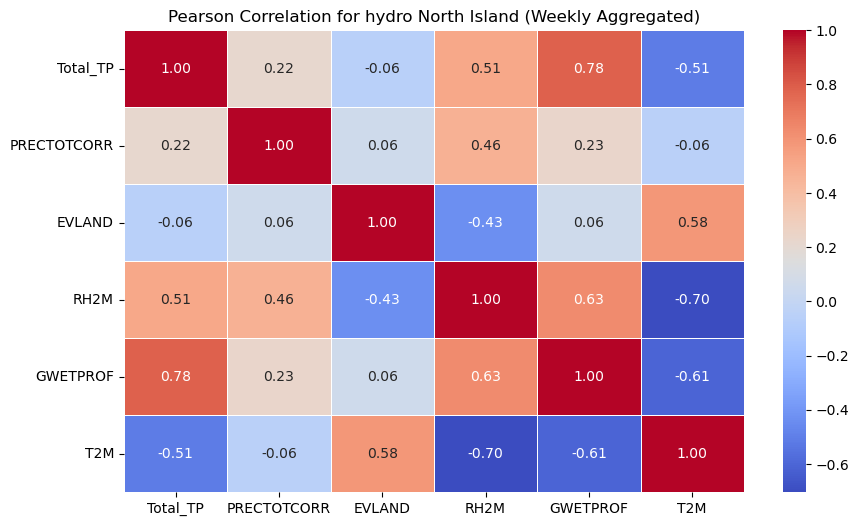

In [79]:
# Compute correlation matrix - North Island
correlation_matrix_north = df_hydro_weekly_north.corr()

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix_north, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Pearson Correlation for hydro North Island (Weekly Aggregated)')
plt.show()

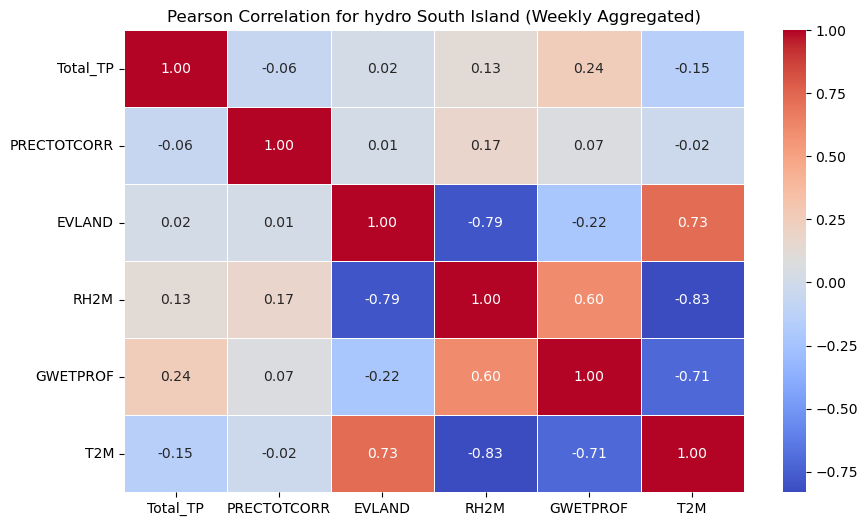

In [80]:
# Compute correlation matrix - South Island
correlation_matrix_south = df_hydro_weekly_south.corr()

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix_south, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Pearson Correlation for hydro South Island (Weekly Aggregated)')
plt.show()

<!-- # All Island Weekly
# df_hydro_weekly['PRECIP_7d'] = df_hydro_weekly['PRECTOTCORR'].rolling(7, min_periods=1).sum() #Rolling sums - total rain over the last 7 days
# df_hydro_weekly['PRECIP_14d'] = df_hydro_weekly['PRECTOTCORR'].rolling(14, min_periods=1).sum() #Rolling sums - total rain over the last 7 days
# df_hydro_weekly['PRECIP_lag1'] = df_hydro_weekly['PRECTOTCORR'].shift(1) # Lagged values yesterday’s rain
# df_hydro_weekly['PRECIP_lag7'] = df_hydro_weekly['PRECTOTCORR'].shift(7) # Lagged values last week’s rain
df_hydro_weekly['PRECIP_lag1w'] = df_hydro_weekly['PRECTOTCORR'].shift(1)
df_hydro_weekly['PRECIP_lag2w'] = df_hydro_weekly['PRECTOTCORR'].shift(2)
df_hydro_weekly['API_weekly'] = df_hydro_weekly['PRECTOTCORR'].ewm(alpha=0.3, adjust=False).mean() -->

In [82]:
# Add 1 to 2-week lagged climate features
df_hydro_weekly_north['TP_lag1w'] = df_hydro_weekly_north['Total_TP'].shift(1)
df_hydro_weekly_north['T2M_lag1w'] = df_hydro_weekly_north['T2M'].shift(1)
df_hydro_weekly_north['GWETPROF_lag1w'] = df_hydro_weekly_north['GWETPROF'].shift(1)
df_hydro_weekly_north['RH2M_lag1w'] = df_hydro_weekly_north['RH2M'].shift(1)
df_hydro_weekly_north['PRECIP_lag1w'] = df_hydro_weekly_north['PRECTOTCORR'].shift(1)
df_hydro_weekly_north['EVLAND_lag1w'] = df_hydro_weekly_north['EVLAND'].shift(1)
df_hydro_weekly_north['PRECIP_lag2w'] = df_hydro_weekly_north['PRECTOTCORR'].shift(2)
df_hydro_weekly_north['PRECIP_EWMA'] = df_hydro_weekly_north['PRECTOTCORR'].ewm(alpha=0.3, adjust=False).mean()
# EWMA for EVLAND with a “slow” decay (alpha = 0.1)
df_hydro_weekly_north['EVLAND_EWMA'] = df_hydro_weekly_north['EVLAND'].ewm(alpha=0.3, adjust=False).mean()
df_hydro_weekly_north['APIxGWETPROF'] = df_hydro_weekly_north['PRECIP_EWMA'] * df_hydro_weekly_north['GWETPROF']

In [83]:
df_hydro_weekly_north.head()

Total_TP  PRECTOTCORR  EVLAND       RH2M  GWETPROF        T2M  \
DATE                                                                           
2015-03-08  77108297.22       204.03  195.33  76.440336  0.331176  17.886723   
2015-03-15  71245084.70       372.58  203.25  76.564454  0.338487  17.326303   
2015-03-22  71202576.46       399.07  238.96  70.463782  0.368403  13.776807   
2015-03-29  70920967.42       326.24  216.04  80.650000  0.360000  16.227563   
2015-04-05  70933314.09        44.53  174.38  77.631261  0.362605  15.508235   

               TP_lag1w  T2M_lag1w  GWETPROF_lag1w  RH2M_lag1w  PRECIP_lag1w  \
DATE                                                                           
2015-03-08          NaN        NaN             NaN         NaN           NaN   
2015-03-15  77108297.22  17.886723        0.331176   76.440336        204.03   
2015-03-22  71245084.70  17.326303        0.338487   76.564454        372.58   
2015-03-29  71202576.46  13.776807        0.368403   70.463782        399.07   
2015-04-05  70920967.42  16.227563        0.360000   80.650000        326.24   

            EVLAND_lag1w  PRECIP_lag2w  PRECIP_EWMA  EVLAND_EWMA  APIxGWETPROF  
DATE                                                                            
2015-03-08           NaN           NaN   204.030000   195.330000     67.569935  
2015-03-15        195.33           NaN   254.595000   197.706000     86.177198  
2015-03-22        203.25        204.03   297.937500   210.082200    109.761176  
2015-03-29        238.96        372.58   306.428250   211.869540    110.314170  
2015-04-05        216.04        399.07   227.858775   200.622678     82.622741

In [84]:
# Drop original non-lagged features and drop NA from lagging
weekly_lagged_north = df_hydro_weekly_north[['Total_TP','TP_lag1w','PRECTOTCORR','PRECIP_lag1w','APIxGWETPROF','PRECIP_lag2w','PRECIP_EWMA','EVLAND','EVLAND_lag1w','EVLAND_EWMA','RH2M','RH2M_lag1w','GWETPROF','GWETPROF_lag1w','T2M','T2M_lag1w']].dropna()
weekly_lagged_north.head()

Total_TP     TP_lag1w  PRECTOTCORR  PRECIP_lag1w  \
DATE                                                               
2015-03-22  7.120258e+07  71245084.70       399.07        372.58   
2015-03-29  7.092097e+07  71202576.46       326.24        399.07   
2015-04-05  7.093331e+07  70920967.42        44.53        326.24   
2015-04-12  9.771136e+07  70933314.09       717.41         44.53   
2015-04-19  1.111432e+08  97711358.20       646.65        717.41   

            APIxGWETPROF  PRECIP_lag2w  PRECIP_EWMA  EVLAND  EVLAND_lag1w  \
DATE                                                                        
2015-03-22    109.761176        204.03   297.937500  238.96        203.25   
2015-03-29    110.314170        372.58   306.428250  216.04        238.96   
2015-04-05     82.622741        399.07   227.858775  174.38        216.04   
2015-04-12    140.663256        326.24   374.724142  185.60        174.38   
2015-04-19    188.502533         44.53   456.301900  184.17        185.60   

            EVLAND_EWMA       RH2M  RH2M_lag1w  GWETPROF  GWETPROF_lag1w  \
DATE                                                                       
2015-03-22   210.082200  70.463782   76.564454  0.368403        0.338487   
2015-03-29   211.869540  80.650000   70.463782  0.360000        0.368403   
2015-04-05   200.622678  77.631261   80.650000  0.362605        0.360000   
2015-04-12   196.115875  85.405462   77.631261  0.375378        0.362605   
2015-04-19   192.532112  80.490084   85.405462  0.413109        0.375378   

                  T2M  T2M_lag1w  
DATE                              
2015-03-22  13.776807  17.326303  
2015-03-29  16.227563  13.776807  
2015-04-05  15.508235  16.227563  
2015-04-12  16.036639  15.508235  
2015-04-19  10.195378  16.036639

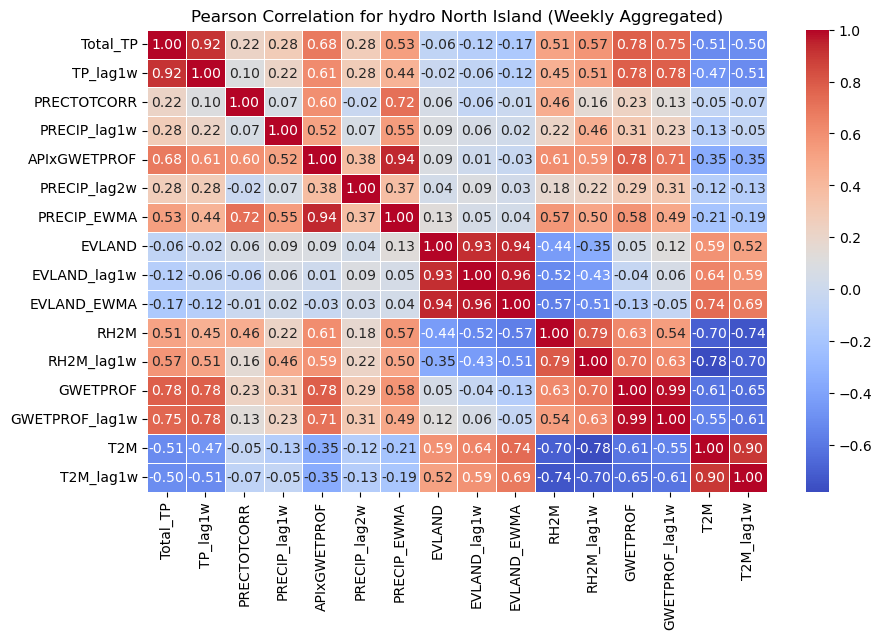

In [85]:
# Compute correlation matrix - North Island
correlation_matrix_with_lag_north = weekly_lagged_north.corr()

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix_with_lag_north, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Pearson Correlation for hydro North Island (Weekly Aggregated)')
plt.show()

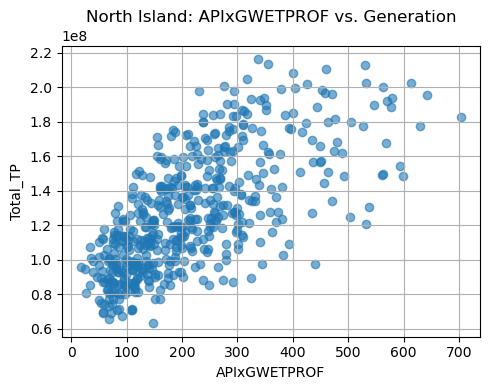

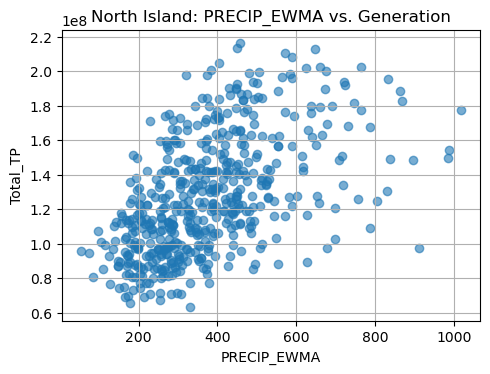

In [86]:
import matplotlib.pyplot as plt

for feat in ['APIxGWETPROF', 'PRECIP_EWMA']:
    plt.figure(figsize=(5, 4))
    plt.scatter(df_hydro_weekly_north[feat], df_hydro_weekly_north['Total_TP'], alpha=0.6)
    plt.xlabel(feat)
    plt.ylabel('Total_TP')
    plt.title(f'North Island: {feat} vs. Generation')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

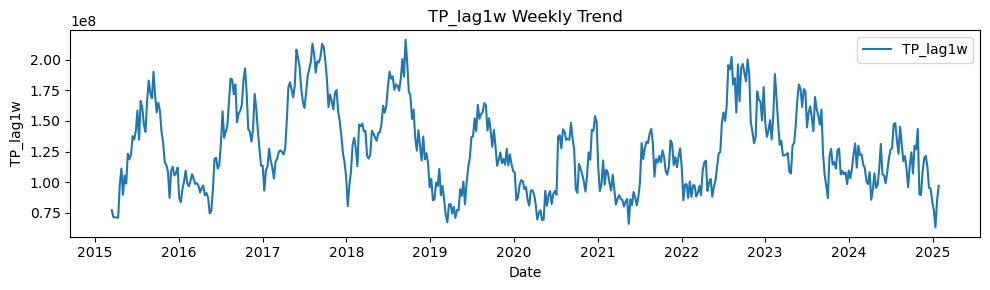

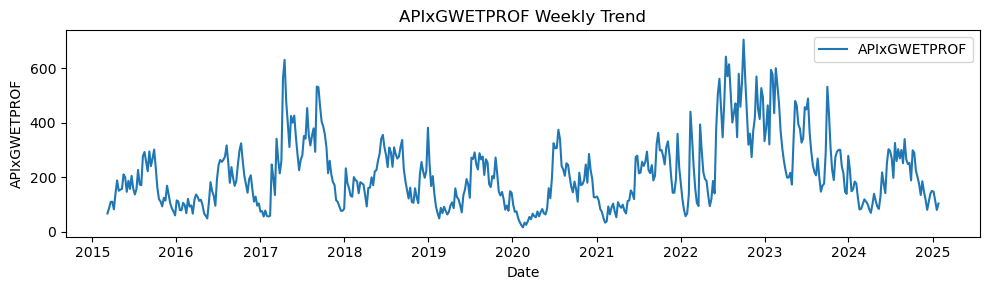

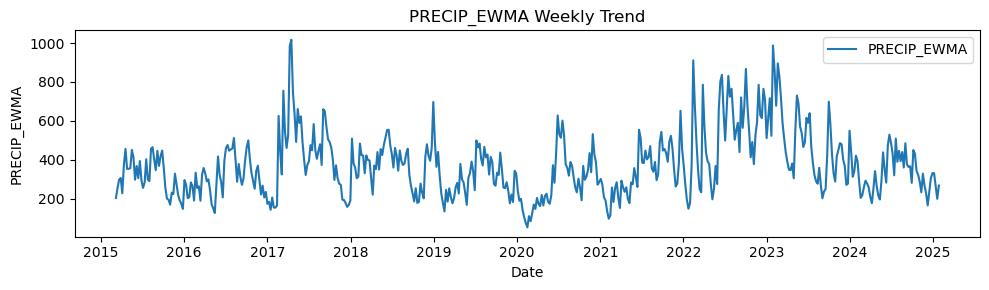

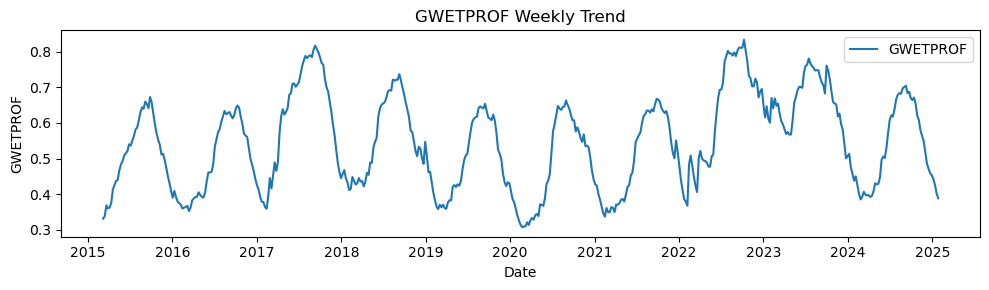

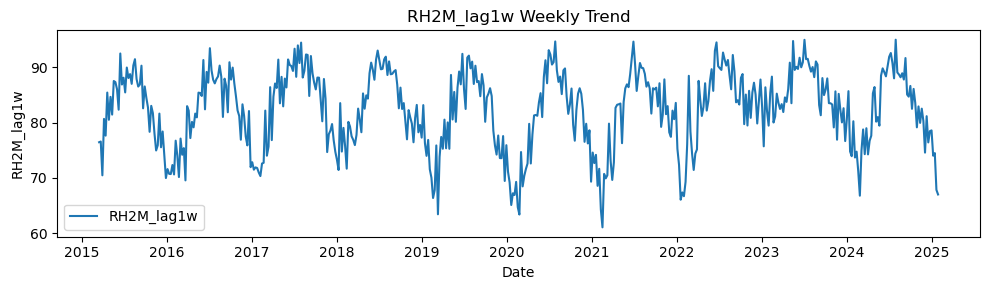

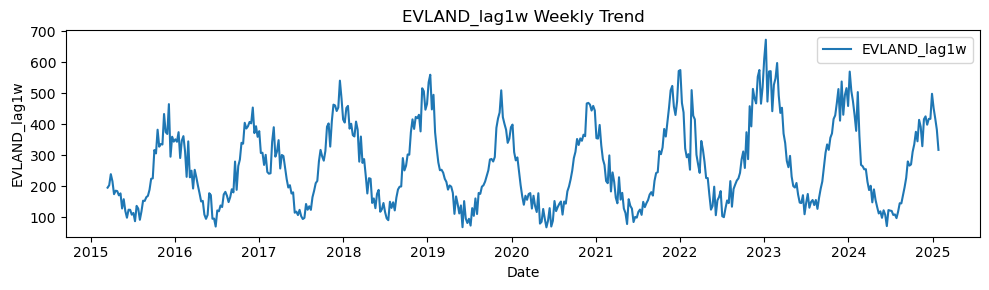

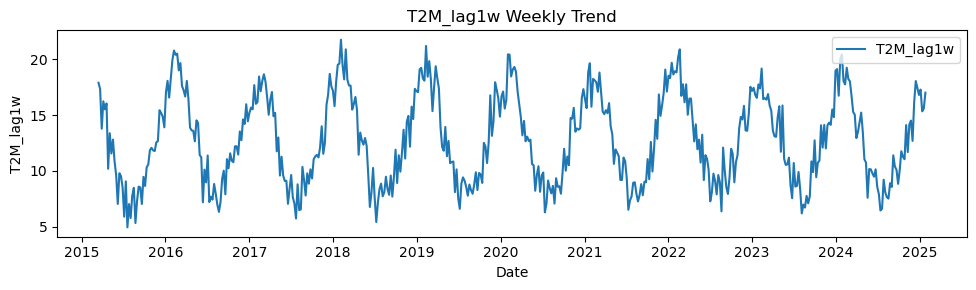

In [87]:
factors = ['TP_lag1w','APIxGWETPROF','PRECIP_EWMA','GWETPROF','RH2M_lag1w','EVLAND_lag1w','T2M_lag1w']

for f in factors:
    plt.figure(figsize=(10, 3))
    plt.plot(df_hydro_weekly_north[f], label=f)
    plt.title(f'{f} Weekly Trend')
    plt.xlabel('Date')
    plt.ylabel(f)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [88]:
# South Island 

In [89]:
# Add 1 to 2-week lagged climate features
df_hydro_weekly_south['TP_lag1w'] = df_hydro_weekly_south['Total_TP'].shift(1)
df_hydro_weekly_south['T2M_lag1w'] = df_hydro_weekly_south['T2M'].shift(1)
df_hydro_weekly_south['GWETPROF_lag1w'] = df_hydro_weekly_south['GWETPROF'].shift(1)
df_hydro_weekly_south['RH2M_lag1w'] = df_hydro_weekly_south['RH2M'].shift(1)
df_hydro_weekly_south['PRECIP_lag1w'] = df_hydro_weekly_south['PRECTOTCORR'].shift(1)
df_hydro_weekly_south['EVLAND_lag1w'] = df_hydro_weekly_south['EVLAND'].shift(1)
df_hydro_weekly_south['PRECIP_lag2w'] = df_hydro_weekly_south['PRECTOTCORR'].shift(2)
df_hydro_weekly_south['PRECIP_EWMA'] = df_hydro_weekly_south['PRECTOTCORR'].ewm(alpha=0.3, adjust=False).mean()
# EWMA for EVLAND with a “slow” decay (alpha = 0.1)
df_hydro_weekly_south['EVLAND_EWMA'] = df_hydro_weekly_south['EVLAND'].ewm(alpha=0.3, adjust=False).mean()
df_hydro_weekly_south['APIxGWETPROF'] = df_hydro_weekly_south['PRECIP_EWMA'] * df_hydro_weekly_south['GWETPROF']

In [90]:
df_hydro_weekly_south.head()

Total_TP  PRECTOTCORR  EVLAND       RH2M  GWETPROF        T2M  \
DATE                                                                            
2015-03-08  3.203293e+08       767.35  258.66  76.412937  0.467698  12.941190   
2015-03-15  3.243453e+08       156.42  228.78  77.127698  0.480000  12.604048   
2015-03-22  2.950068e+08       264.80  165.01  80.292381  0.474921   8.037778   
2015-03-29  2.870318e+08       367.40  154.86  83.572698  0.482063  11.639524   
2015-04-05  2.590456e+08       189.24  177.98  79.877222  0.490952  11.092937   

                TP_lag1w  T2M_lag1w  GWETPROF_lag1w  RH2M_lag1w  PRECIP_lag1w  \
DATE                                                                            
2015-03-08           NaN        NaN             NaN         NaN           NaN   
2015-03-15  3.203293e+08  12.941190        0.467698   76.412937        767.35   
2015-03-22  3.243453e+08  12.604048        0.480000   77.127698        156.42   
2015-03-29  2.950068e+08   8.037778        0.474921   80.292381        264.80   
2015-04-05  2.870318e+08  11.639524        0.482063   83.572698        367.40   

            EVLAND_lag1w  PRECIP_lag2w  PRECIP_EWMA  EVLAND_EWMA  APIxGWETPROF  
DATE                                                                            
2015-03-08           NaN           NaN   767.350000   258.660000    358.888377  
2015-03-15        258.66           NaN   584.071000   249.696000    280.354080  
2015-03-22        228.78        767.35   488.289700   224.290200    231.898854  
2015-03-29        165.01        156.42   452.022790   203.461140    217.903685  
2015-04-05        154.86        264.80   373.187953   195.816798    183.217514

In [91]:
# Drop original non-lagged features and drop NA from lagging
weekly_lagged_south = df_hydro_weekly_south[['Total_TP','TP_lag1w','PRECTOTCORR','PRECIP_lag1w','APIxGWETPROF','PRECIP_lag2w','PRECIP_EWMA','EVLAND','EVLAND_lag1w','EVLAND_EWMA','RH2M','RH2M_lag1w','GWETPROF','GWETPROF_lag1w','T2M','T2M_lag1w']].dropna()
weekly_lagged_south.head()

Total_TP      TP_lag1w  PRECTOTCORR  PRECIP_lag1w  \
DATE                                                                
2015-03-22  2.950068e+08  3.243453e+08       264.80        156.42   
2015-03-29  2.870318e+08  2.950068e+08       367.40        264.80   
2015-04-05  2.590456e+08  2.870318e+08       189.24        367.40   
2015-04-12  2.441813e+08  2.590456e+08       470.76        189.24   
2015-04-19  2.735290e+08  2.441813e+08       333.51        470.76   

            APIxGWETPROF  PRECIP_lag2w  PRECIP_EWMA  EVLAND  EVLAND_lag1w  \
DATE                                                                        
2015-03-22    231.898854        767.35   488.289700  165.01        228.78   
2015-03-29    217.903685        156.42   452.022790  154.86        165.01   
2015-04-05    183.217514        264.80   373.187953  177.98        154.86   
2015-04-12    202.251903        367.40   402.459567  166.54        177.98   
2015-04-19    198.916737        189.24   381.774697  129.33        166.54   

            EVLAND_EWMA       RH2M  RH2M_lag1w  GWETPROF  GWETPROF_lag1w  \
DATE                                                                       
2015-03-22   224.290200  80.292381   77.127698  0.474921        0.480000   
2015-03-29   203.461140  83.572698   80.292381  0.482063        0.474921   
2015-04-05   195.816798  79.877222   83.572698  0.490952        0.482063   
2015-04-12   187.033759  83.569683   79.877222  0.502540        0.490952   
2015-04-19   169.722631  85.104524   83.569683  0.521032        0.502540   

                  T2M  T2M_lag1w  
DATE                              
2015-03-22   8.037778  12.604048  
2015-03-29  11.639524   8.037778  
2015-04-05  11.092937  11.639524  
2015-04-12   9.989206  11.092937  
2015-04-19   4.725635   9.989206

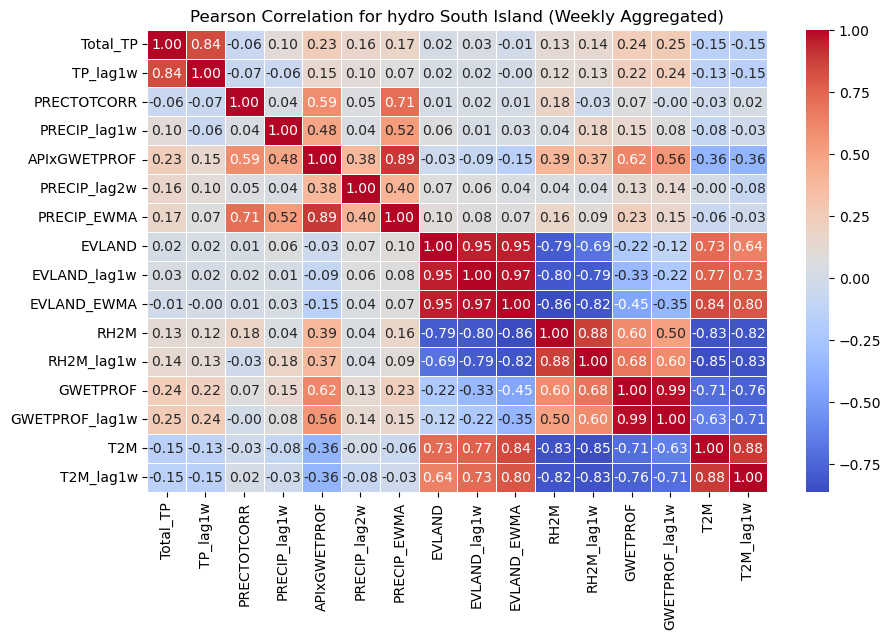

In [92]:
# Compute correlation matrix - South Island
correlation_matrix_with_lag_south = weekly_lagged_south.corr()

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix_with_lag_south, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Pearson Correlation for hydro South Island (Weekly Aggregated)')
plt.show()

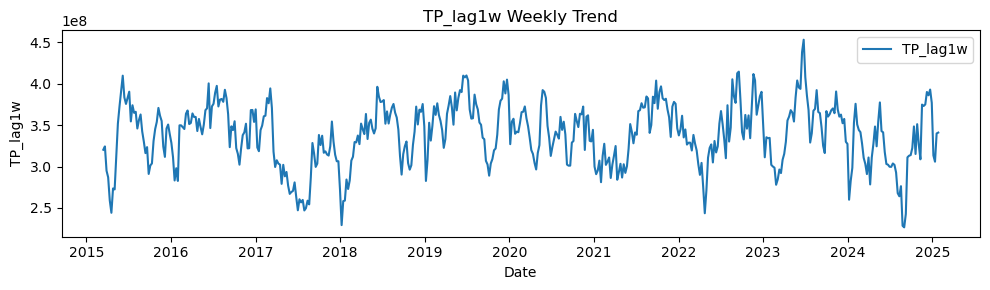

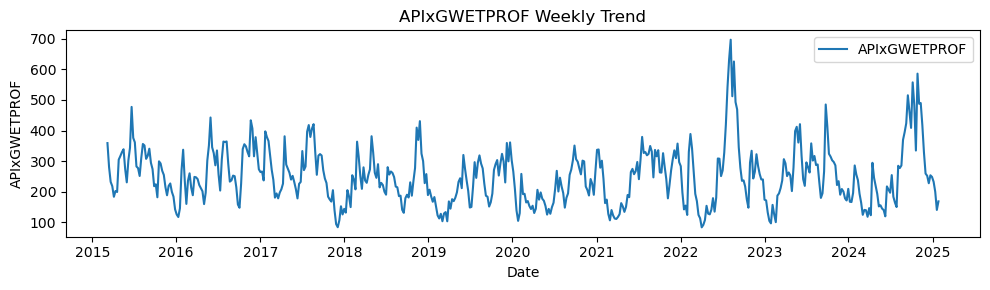

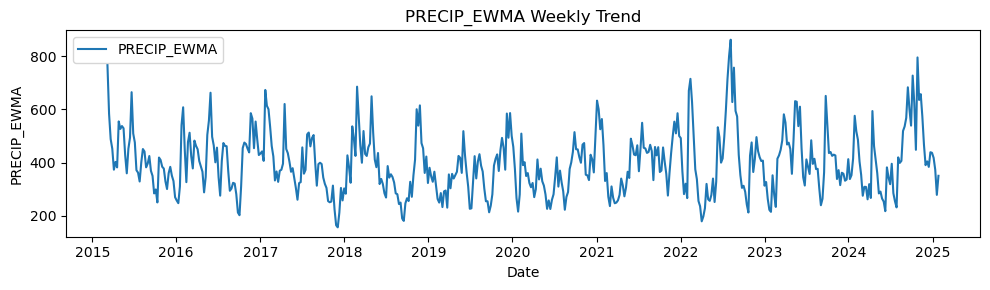

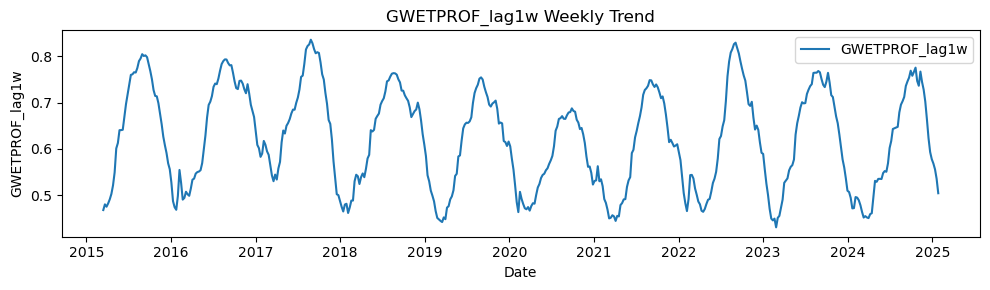

In [93]:
factors = ['TP_lag1w','APIxGWETPROF','PRECIP_EWMA','GWETPROF_lag1w']

for f in factors:
    plt.figure(figsize=(10, 3))
    plt.plot(df_hydro_weekly_south[f], label=f)
    plt.title(f'{f} Weekly Trend')
    plt.xlabel('Date')
    plt.ylabel(f)
    plt.legend()
    plt.tight_layout()
    plt.show()

# SARIMA model for hydro

## Pre Checks - stationery

In [189]:
# Frequency setting 'W' (weekly)
df_hydro_weekly_north.head()
df_hydro_weekly_north.index.freq  

<Week: weekday=6>

In [197]:
weekly_lagged_north.head()
weekly_lagged_north.index.freq  

<Week: weekday=6>

In [199]:
weekly_lagged_north.head()

Total_TP     TP_lag1w  PRECTOTCORR  PRECIP_lag1w  \
DATE                                                               
2015-03-22  7.120258e+07  71245084.70       399.07        372.58   
2015-03-29  7.092097e+07  71202576.46       326.24        399.07   
2015-04-05  7.093331e+07  70920967.42        44.53        326.24   
2015-04-12  9.771136e+07  70933314.09       717.41         44.53   
2015-04-19  1.111432e+08  97711358.20       646.65        717.41   

            APIxGWETPROF  PRECIP_lag2w  PRECIP_EWMA  EVLAND  EVLAND_lag1w  \
DATE                                                                        
2015-03-22    109.761176        204.03   297.937500  238.96        203.25   
2015-03-29    110.314170        372.58   306.428250  216.04        238.96   
2015-04-05     82.622741        399.07   227.858775  174.38        216.04   
2015-04-12    140.663256        326.24   374.724142  185.60        174.38   
2015-04-19    188.502533         44.53   456.301900  184.17        185.60   

            EVLAND_EWMA       RH2M  RH2M_lag1w  GWETPROF  GWETPROF_lag1w  \
DATE                                                                       
2015-03-22   210.082200  70.463782   76.564454  0.368403        0.338487   
2015-03-29   211.869540  80.650000   70.463782  0.360000        0.368403   
2015-04-05   200.622678  77.631261   80.650000  0.362605        0.360000   
2015-04-12   196.115875  85.405462   77.631261  0.375378        0.362605   
2015-04-19   192.532112  80.490084   85.405462  0.413109        0.375378   

                  T2M  T2M_lag1w  
DATE                              
2015-03-22  13.776807  17.326303  
2015-03-29  16.227563  13.776807  
2015-04-05  15.508235  16.227563  
2015-04-12  16.036639  15.508235  
2015-04-19  10.195378  16.036639

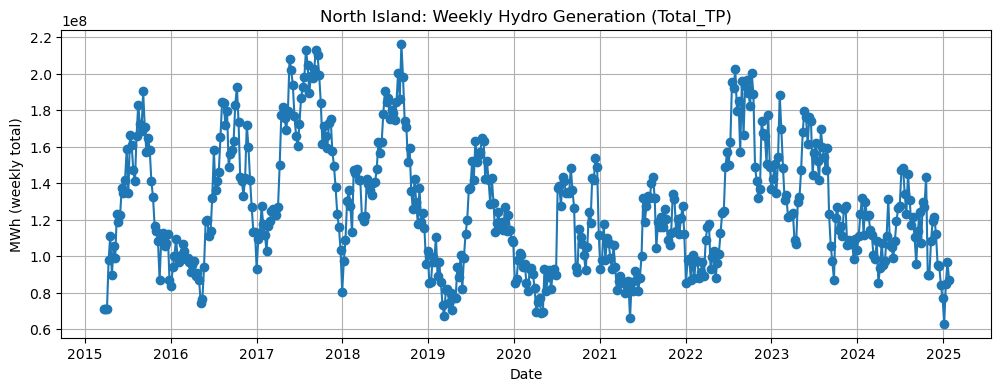

In [201]:
plt.figure(figsize=(12,4))
plt.plot(weekly_lagged_north['Total_TP'], marker='o', linestyle='-')
plt.title("North Island: Weekly Hydro Generation (Total_TP)")
plt.ylabel("MWh (weekly total)")
plt.xlabel("Date")
plt.grid(True)
plt.show()

In [215]:
# stationery check for north Island weekly data
from statsmodels.tsa.stattools import adfuller

result = adfuller(weekly_lagged_north['Total_TP'])
print('stationery check for North Island - Weekly' )
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

stationery check for North Island - Weekly
ADF Statistic: -4.839144
p-value: 0.000046
Critical Values:
	1%: -3.443
	5%: -2.867
	10%: -2.570


In [217]:
# stationery check for South Island Weekly data
from statsmodels.tsa.stattools import adfuller


result = adfuller(weekly_lagged_south['Total_TP'])
print('stationery check for South Island - Weekly ' )
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

stationery check for South Island - Weekly 
ADF Statistic: -6.723656
p-value: 0.000000
Critical Values:
	1%: -3.443
	5%: -2.867
	10%: -2.570


<Figure size 1000x400 with 0 Axes>

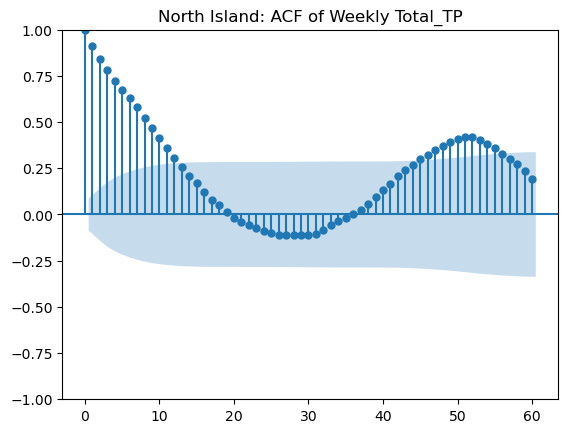

<Figure size 1000x400 with 0 Axes>

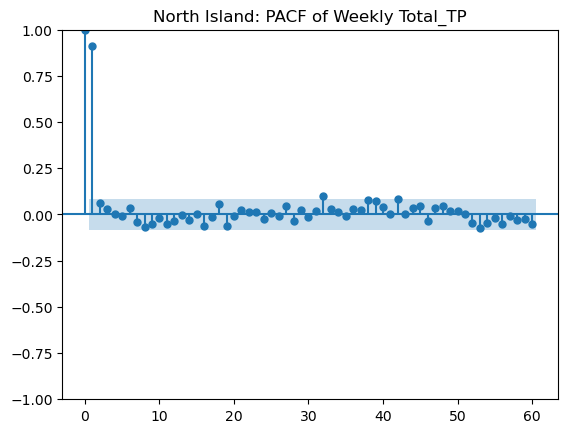

In [227]:
# Plot ACF & PACF North Island
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
north = weekly_lagged_north['Total_TP']
#north = df_hydro_weekly_north['Total_TP']

plt.figure(figsize=(10,4))
plot_acf(north,  lags=60)
plt.title("North Island: ACF of Weekly Total_TP")
plt.show()

plt.figure(figsize=(10,4))
plot_pacf(north, lags=60, method='ywm')
plt.title("North Island: PACF of Weekly Total_TP")
plt.show()

<Figure size 1000x400 with 0 Axes>

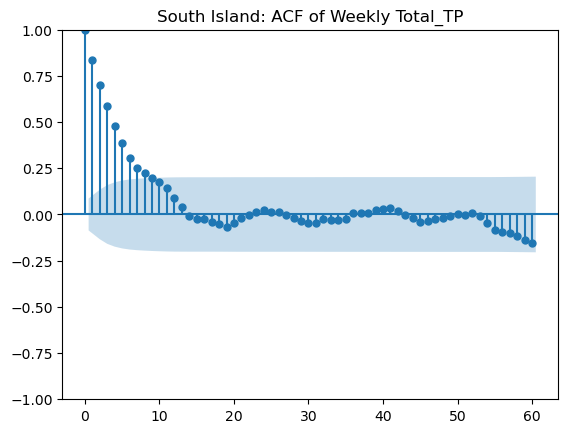

<Figure size 1000x400 with 0 Axes>

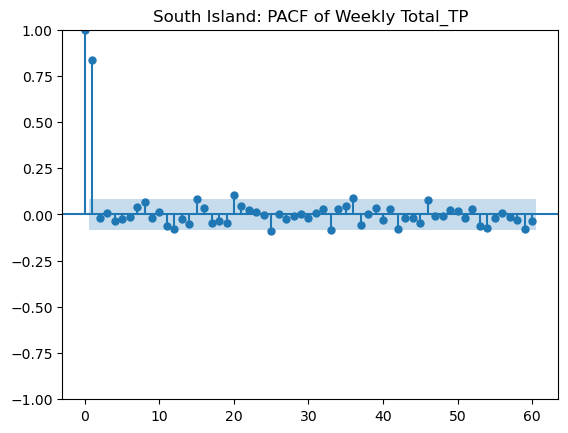

In [229]:
# Plot ACF & PACF South Island
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
south = weekly_lagged_south['Total_TP']


plt.figure(figsize=(10,4))
plot_acf(south,  lags=60)
plt.title("South Island: ACF of Weekly Total_TP")
plt.show()

plt.figure(figsize=(10,4))
plot_pacf(south, lags=60, method='ywm')
plt.title("South Island: PACF of Weekly Total_TP")
plt.show()

# Model Development 

## Start North Island - Weekly 

In [452]:
# RQ1: North Island Univariate SARIMA (no exogenous inputs)
# Repeat the same steps for North Island:
series_n = north
n_n = len(series_n)
split_n = int(n_n * 0.8)

train_n = series_n.iloc[:split_n]
test_n  = series_n.iloc[split_n:]

model_n = SARIMAX(
    train_n,
    order=(1, 0, 0),
    seasonal_order=(0, 0, 1, 52),
    enforce_stationarity=False,
    enforce_invertibility=False
)
res_n = model_n.fit(disp=False)
print(res_n.summary())

fc_n = res_n.get_forecast(steps=len(test_n))
pred_n = pd.Series(fc_n.predicted_mean.values, index=test_n.index)

mae_n  = mean_absolute_error(test_n, pred_n)
rmse_n = np.sqrt(mean_squared_error(test_n, pred_n))
mape_n = np.mean(np.abs((test_n - pred_n) / test_n)) * 100

# rmse = np.sqrt(mean_squared_error(target_test, forecast))
# mae = mean_absolute_error(target_test, forecast)
# epsilon = 1e-10  # small constant to avoid division by zero in MAPE
# mape = np.mean(np.abs((target_test - forecast) / (target_test + epsilon))) * 100

print("North Island SARIMA(1, 0, 1)x(0, 0, 1, 52) → MAE:", f"{mae_n:.2f}",
      "RMSE:", f"{rmse_n:.2f}", "MAPE:", f"{mape_n:.2f}%")

                                      SARIMAX Results                                       
Dep. Variable:                             Total_TP   No. Observations:                  412
Model:             SARIMAX(1, 0, 0)x(0, 0, [1], 52)   Log Likelihood               -6406.445
Date:                              Mon, 02 Jun 2025   AIC                          12818.889
Time:                                      14:07:51   BIC                          12830.539
Sample:                                  03-22-2015   HQIC                         12823.522
                                       - 02-05-2023                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9960      0.006    175.829      0.000       0.985       1.007
ma.S.L52       0.11

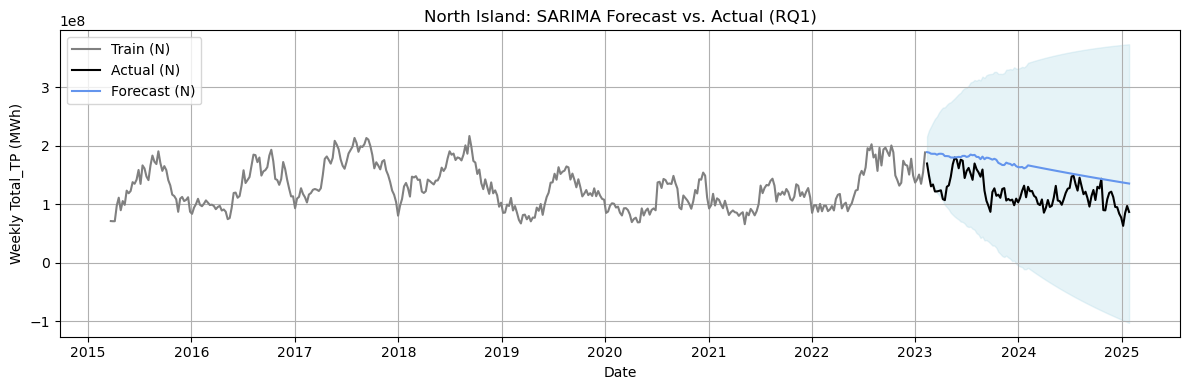

In [244]:
# Repeat a similar plot for North Island:
plt.figure(figsize=(12,4))
plt.plot(train_n.index, train_n, label="Train (N)",   color="gray")
plt.plot(test_n.index,  test_n,  label="Actual (N)",  color="black")
plt.plot(pred_n.index,  pred_n,  label="Forecast (N)",color="cornflowerblue")
plt.fill_between(
    fc_n.conf_int().index,
    fc_n.conf_int().iloc[:,0],
    fc_n.conf_int().iloc[:,1],
    color="lightblue", alpha=0.3
)
plt.legend()
plt.title("North Island: SARIMA Forecast vs. Actual (RQ1)")
plt.xlabel("Date")
plt.ylabel("Weekly Total_TP (MWh)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [258]:
weekly_lagged_north

Total_TP     TP_lag1w  PRECTOTCORR  PRECIP_lag1w  \
DATE                                                               
2015-03-22  7.120258e+07  71245084.70       399.07        372.58   
2015-03-29  7.092097e+07  71202576.46       326.24        399.07   
2015-04-05  7.093331e+07  70920967.42        44.53        326.24   
2015-04-12  9.771136e+07  70933314.09       717.41         44.53   
2015-04-19  1.111432e+08  97711358.20       646.65        717.41   
...                  ...          ...          ...           ...   
2024-12-29  7.731263e+07  83933260.00       391.50        468.64   
2025-01-05  6.298005e+07  77312627.00       331.19        391.50   
2025-01-12  8.487436e+07  62980054.00       108.94        331.19   
2025-01-19  9.699145e+07  84874356.00        46.67        108.94   
2025-01-26  8.673389e+07  96991450.00       426.59         46.67   

            APIxGWETPROF  PRECIP_lag2w  PRECIP_EWMA  EVLAND  EVLAND_lag1w  \
DATE                                                                        
2015-03-22    109.761176        204.03   297.937500  238.96        203.25   
2015-03-29    110.314170        372.58   306.428250  216.04        238.96   
2015-04-05     82.622741        399.07   227.858775  174.38        216.04   
2015-04-12    140.663256        326.24   374.724142  185.60        174.38   
2015-04-19    188.502533         44.53   456.301900  184.17        185.60   
...                  ...           ...          ...     ...           ...   
2024-12-29    150.209347        400.52   331.569510  452.03        498.24   
2025-01-05    146.731798        468.64   331.455657  418.69        452.03   
2025-01-12    112.664736        391.50   264.700960  382.43        418.69   
2025-01-19     80.185590        331.19   199.291672  317.29        382.43   
2025-01-26    103.845631        108.94   267.481170  321.14        317.29   

            EVLAND_EWMA       RH2M  RH2M_lag1w  GWETPROF  GWETPROF_lag1w  \
DATE                                                                       
2015-03-22   210.082200  70.463782   76.564454  0.368403        0.338487   
2015-03-29   211.869540  80.650000   70.463782  0.360000        0.368403   
2015-04-05   200.622678  77.631261   80.650000  0.362605        0.360000   
2015-04-12   196.115875  85.405462   77.631261  0.375378        0.362605   
2015-04-19   192.532112  80.490084   85.405462  0.413109        0.375378   
...                 ...        ...         ...       ...             ...   
2024-12-29   438.334654  74.004958   78.571765  0.453025        0.458739   
2025-01-05   432.441258  74.479328   74.004958  0.442689        0.453025   
2025-01-12   417.437880  67.837059   74.479328  0.425630        0.442689   
2025-01-19   387.393516  67.007143   67.837059  0.402353        0.425630   
2025-01-26   367.517461  75.025294   67.007143  0.388235        0.402353   

                  T2M  T2M_lag1w  
DATE                              
2015-03-22  13.776807  17.326303  
2015-03-29  16.227563  13.776807  
2015-04-05  15.508235  16.227563  
2015-04-12  16.036639  15.508235  
2015-04-19  10.195378  16.036639  
...               ...        ...  
2024-12-29  17.281008  16.798655  
2025-01-05  15.331933  17.281008  
2025-01-12  15.599916  15.331933  
2025-01-19  17.000084  15.599916  
2025-01-26  18.570840  17.000084  

[515 rows x 16 columns]

In [284]:
# Split the weekly data into 80% training and 20% testing sets
n = len(weekly_lagged_north)
train_size = int(n * 0.8)
train_wk = weekly_lagged_north.iloc[:train_size]
test_wk = weekly_lagged_north.iloc[train_size:]

In [286]:
print("Daily Train set:", train_wk.index.min(), "to", train_wk.index.max())
print("Daily Test set:", test_wk.index.min(), "to", test_wk.index.max())

Daily Train set: 2015-03-22 00:00:00 to 2023-02-05 00:00:00
Daily Test set: 2023-02-12 00:00:00 to 2025-01-26 00:00:00


In [288]:
# Define the target variable (original Total_TP) and exogenous variables
# target_train_log = train_weekly['Total_TP_log']
# target_test_log = test_weekly['Total_TP_log']

target_train = train_wk['Total_TP']
target_test = test_wk['Total_TP']



In [318]:
#exog_cols = ['TP_lag1w','APIxGWETPROF','PRECIP_EWMA','GWETPROF','RH2M_lag1w','EVLAND_lag1w','T2M_lag1w' ]
exog_cols = ['APIxGWETPROF','PRECIP_EWMA','GWETPROF','RH2M_lag1w','EVLAND_lag1w','T2M_lag1w' ]
#exog_cols = ['RH2M', 'GWETPROF', 'EVLAND', 'T2M']
#exog_cols = ['RH2M', 'GWETPROF', 'EVLAND', 'T2M','PRECTOTCORR_lag1']
#exog_cols = ['T2M','PRECTOTCORR_lag7','GWETPROF']
#exog_cols = ['EVLAND','T2M']
#exog_cols = ['GWETPROF','EVLAND','T2M']
#exog_cols = ['PRECTOTCORR','GWETPROF','EVLAND','T2M']
#exog_cols = ['RH2M','PRECTOTCORR','GWETPROF','EVLAND','T2M']
#exog_cols = ['WS50M']

In [320]:
exog_train = train_wk[exog_cols]
exog_test = test_wk[exog_cols]

In [322]:
# RQ2: North Island SARIMAX with climate exogenous features
# Fit SARIMAX on the original (non-log) target data
model = SARIMAX(target_train,
                exog=exog_train,
                # order=(1, 1, 1),
                # seasonal_order=(0, 0, 0, 0),
                order=(1, 0, 0),
                seasonal_order=(0, 0, 1, 52),
                enforce_stationarity=False,
                enforce_invertibility=False)
results = model.fit(disp=False)
print(results.summary())

                                      SARIMAX Results                                       
Dep. Variable:                             Total_TP   No. Observations:                  412
Model:             SARIMAX(1, 0, 0)x(0, 0, [1], 52)   Log Likelihood               -6350.734
Date:                              Mon, 02 Jun 2025   AIC                          12719.467
Time:                                      13:12:11   BIC                          12754.417
Sample:                                  03-22-2015   HQIC                         12733.365
                                       - 02-05-2023                                         
Covariance Type:                                opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
APIxGWETPROF   105.2937   3.18e+04      0.003      0.997   -6.23e+04    6.25e+04
PRECIP_EWMA  

In [323]:
# Forecast on the test set - non log
n_steps = len(test_wk)
forecast = results.get_forecast(steps=n_steps, exog=exog_test).predicted_mean

# fc_n = res_n.get_forecast(steps=len(test_n))
# pred_n = pd.Series(fc_n.predicted_mean.values, index=test_n.index)

In [324]:
# Compute performance metrics - non log
rmse = np.sqrt(mean_squared_error(target_test, forecast))
mae = mean_absolute_error(target_test, forecast)
epsilon = 1e-10  # small constant to avoid division by zero in MAPE
mape = np.mean(np.abs((target_test - forecast) / (target_test + epsilon))) * 100

print("\nForecast Performance Metrics (Without Log Transformation):")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"Adjusted MAPE: {mape:.2f}%")


Forecast Performance Metrics (Without Log Transformation):
RMSE: 29476558.18
MAE: 23558509.09
Adjusted MAPE: 20.79%


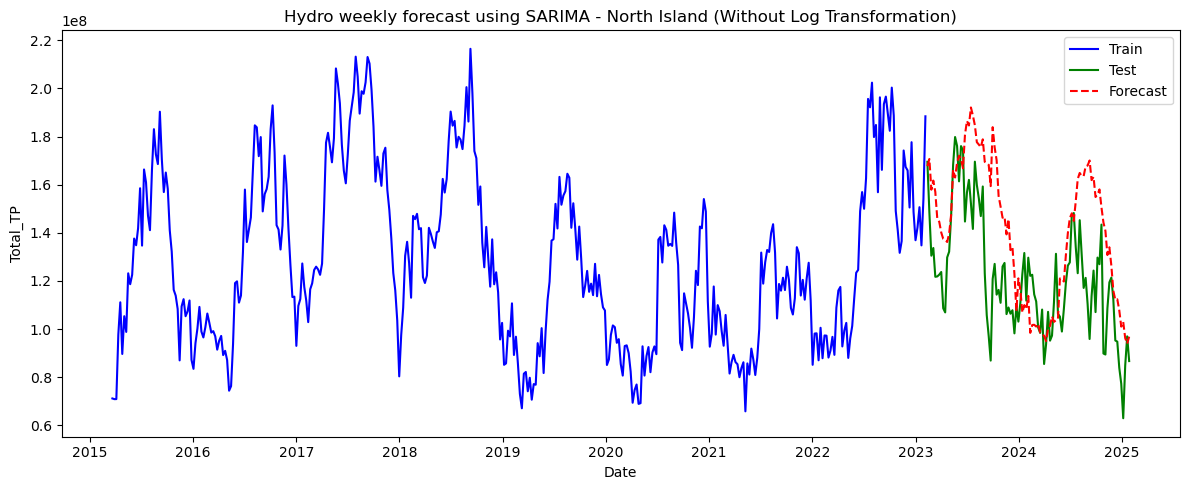

In [328]:
# Plot Actual vs. Forecast North Island Hydro
plt.figure(figsize=(12, 5))
plt.plot(train_wk.index, target_train, label='Train', color='blue')
plt.plot(test_wk.index, target_test, label='Test', color='green')
plt.plot(forecast.index, forecast, label='Forecast', color='red', linestyle='--')
plt.xlabel("Date")
plt.ylabel("Total_TP")
plt.title("Hydro weekly forecast using SARIMA - North Island (Without Log Transformation)")
plt.legend()
plt.tight_layout()
plt.show()

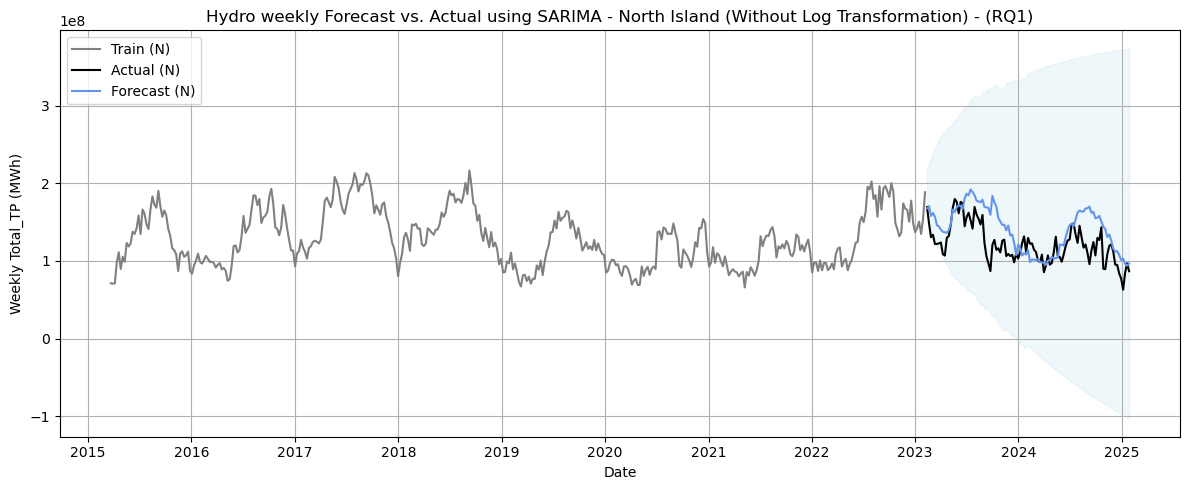

In [330]:
# Repeat a similar plot for North Island:
plt.figure(figsize=(12,5))
plt.plot(train_wk.index, target_train, label="Train (N)",   color="gray")
plt.plot(test_wk.index,  target_test,  label="Actual (N)",  color="black")
plt.plot(forecast.index,  forecast,  label="Forecast (N)",color="cornflowerblue")
plt.fill_between(
    fc_n.conf_int().index,
    fc_n.conf_int().iloc[:,0],
    fc_n.conf_int().iloc[:,1],
    color="lightblue", alpha=0.2
)
plt.legend()
plt.title("Hydro weekly Forecast vs. Actual using SARIMA - North Island (Without Log Transformation) - (RQ1)")
plt.xlabel("Date")
plt.ylabel("Weekly Total_TP (MWh)")
plt.grid(True)
plt.tight_layout()
plt.show()

# # Plot Actual vs. Forecast North Island Hydro
# plt.figure(figsize=(12, 5))
# plt.plot(train_wk.index, target_train, label='Train', color='blue')
# plt.plot(test_wk.index, target_test, label='Test', color='green')
# plt.plot(test_wk.index, forecast, label='Forecast', color='red', linestyle='--')
# plt.xlabel("Date")
# plt.ylabel("Total_TP")
# plt.title("Hydro weekly forecast using SARIMA - North Island (Without Log Transformation)")
# plt.legend()
# plt.tight_layout()
# plt.show()

### Log transformation to see any perfromance improvemane

In [335]:
weekly_lagged_north_log = weekly_lagged_north.copy()

In [365]:
# # Create a log-transformed target. Adding 1 to avoid log(0) 
weekly_lagged_north_log['Total_TP_log'] = np.log(weekly_lagged_north_log['Total_TP'] + 1)

In [423]:
weekly_lagged_north_log.head(5)

Total_TP     TP_lag1w  PRECTOTCORR  PRECIP_lag1w  \
DATE                                                               
2015-03-22  7.120258e+07  71245084.70       399.07        372.58   
2015-03-29  7.092097e+07  71202576.46       326.24        399.07   
2015-04-05  7.093331e+07  70920967.42        44.53        326.24   
2015-04-12  9.771136e+07  70933314.09       717.41         44.53   
2015-04-19  1.111432e+08  97711358.20       646.65        717.41   

            APIxGWETPROF  PRECIP_lag2w  PRECIP_EWMA  EVLAND  EVLAND_lag1w  \
DATE                                                                        
2015-03-22    109.761176        204.03   297.937500  238.96        203.25   
2015-03-29    110.314170        372.58   306.428250  216.04        238.96   
2015-04-05     82.622741        399.07   227.858775  174.38        216.04   
2015-04-12    140.663256        326.24   374.724142  185.60        174.38   
2015-04-19    188.502533         44.53   456.301900  184.17        185.60   

            EVLAND_EWMA       RH2M  RH2M_lag1w  GWETPROF  GWETPROF_lag1w  \
DATE                                                                       
2015-03-22   210.082200  70.463782   76.564454  0.368403        0.338487   
2015-03-29   211.869540  80.650000   70.463782  0.360000        0.368403   
2015-04-05   200.622678  77.631261   80.650000  0.362605        0.360000   
2015-04-12   196.115875  85.405462   77.631261  0.375378        0.362605   
2015-04-19   192.532112  80.490084   85.405462  0.413109        0.375378   

                  T2M  T2M_lag1w  Total_TP_log  
DATE                                            
2015-03-22  13.776807  17.326303     18.081040  
2015-03-29  16.227563  13.776807     18.077077  
2015-04-05  15.508235  16.227563     18.077251  
2015-04-12  16.036639  15.508235     18.397528  
2015-04-19  10.195378  16.036639     18.526330

In [369]:
# Split the weekly data into 80% training and 20% testing sets
n = len(weekly_lagged_north_log)
train_size = int(n * 0.8)
train_log_wk = weekly_lagged_north_log.iloc[:train_size]
test_log_wk = weekly_lagged_north_log.iloc[train_size:]

In [371]:
print("Daily Train set:", train_log_wk.index.min(), "to", train_log_wk.index.max())
print("Daily Test set:", test_log_wk.index.min(), "to", test_log_wk.index.max())

Daily Train set: 2015-03-22 00:00:00 to 2023-02-05 00:00:00
Daily Test set: 2023-02-12 00:00:00 to 2025-01-26 00:00:00


In [373]:
# Define the target variable (original Total_TP) and exogenous variables
target_train_log = train_log_wk['Total_TP_log']
target_test_log = test_log_wk['Total_TP_log']

# target_train = train_weekly['Total_TP']
# target_test = test_weekly['Total_TP']

In [409]:
exog_cols = ['PRECIP_EWMA','GWETPROF','RH2M_lag1w','EVLAND_lag1w','T2M_lag1w' ]
#exog_cols = ['RH2M', 'GWETPROF', 'EVLAND', 'T2M']
#exog_cols = ['RH2M', 'GWETPROF', 'EVLAND', 'T2M','PRECTOTCORR_lag1']
#exog_cols = ['T2M','PRECTOTCORR_lag7','GWETPROF']
#exog_cols = ['EVLAND','T2M']
#exog_cols = ['GWETPROF','EVLAND','T2M']
#exog_cols = ['PRECTOTCORR','GWETPROF','EVLAND','T2M']
#exog_cols = ['RH2M','PRECTOTCORR','GWETPROF','EVLAND','T2M']
#exog_cols = ['WS50M']


In [411]:
exog_train = train_log_wk[exog_cols]
exog_test = test_log_wk[exog_cols]

In [413]:
# Fit SARIMAX on the original (log) target data
model_log = SARIMAX(target_train_log,
                exog=exog_train,
                order=(1, 0, 0),
                seasonal_order=(0, 0, 1, 52),
                enforce_stationarity=False,
                enforce_invertibility=False)
results_log = model_log.fit(disp=False)
print(results_log.summary())

                                      SARIMAX Results                                       
Dep. Variable:                         Total_TP_log   No. Observations:                  412
Model:             SARIMAX(1, 0, 0)x(0, 0, [1], 52)   Log Likelihood                -431.401
Date:                              Mon, 02 Jun 2025   AIC                            878.802
Time:                                      13:39:00   BIC                            909.869
Sample:                                  03-22-2015   HQIC                           891.156
                                       - 02-05-2023                                         
Covariance Type:                                opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
PRECIP_EWMA     -0.0025      0.000     -8.290      0.000      -0.003      -0.002
GWETPROF     

In [415]:
# Forecast on the test set
n_steps_log = len(test_log_wk)
forecast_log = results_log.get_forecast(steps=n_steps_log, exog=exog_test).predicted_mean

In [417]:
# Compute performance metrics
rmse = np.sqrt(mean_squared_error(target_test_log, forecast_log))
mae = mean_absolute_error(target_test_log, forecast_log)
epsilon = 1e-10  # small constant to avoid division by zero in MAPE
mape = np.mean(np.abs((target_test_log - forecast_log) / (target_test_log + epsilon))) * 100

print("\nForecast Performance Metrics (With Log Transformation):")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"Adjusted MAPE: {mape:.2f}%")


Forecast Performance Metrics (With Log Transformation):
RMSE: 0.88
MAE: 0.70
Adjusted MAPE: 3.74%


In [427]:
# 4) Forecast (still in log-space)
fc_obj  = results_log.get_forecast(steps=len(test_log_wk), exog=exog_test)
forecast_log = fc_obj.predicted_mean
ci_log = fc_obj.conf_int(alpha=0.05)  # DataFrame with two columns: lower and upper (log-scale)

In [429]:
# 5) Convert everything back to original MWh scale
forecast_raw = np.exp(forecast_log)      # (exp(log-forecast) ≈ forecast in MWh)
actual_raw   = np.exp(target_test_log)   # Actual MWh values for test
train_actual = np.exp(target_train_log)  # Actual MWh values for train

In [431]:
lower_raw = np.exp(ci_log.iloc[:, 0])
upper_raw = np.exp(ci_log.iloc[:, 1])

In [433]:
# 6) Compute metrics on the raw scale
mae   = mean_absolute_error(actual_raw, forecast_raw)
rmse  = np.sqrt(mean_squared_error(actual_raw, forecast_raw))
mape  = np.mean(np.abs((actual_raw - forecast_raw) / (actual_raw + 1e-10))) * 100

print("Performance on original scale (log‐SARIMAX):")
print(f"  • MAE : {mae:.2f}  MWh")
print(f"  • RMSE: {rmse:.2f}  MWh")
print(f"  • MAPE: {mape:.2f} %")

Performance on original scale (log‐SARIMAX):
  • MAE : 140778971.62  MWh
  • RMSE: 257847323.60  MWh
  • MAPE: 114.18 %


→ ARIMA(1,1,1) on log summary:
                               SARIMAX Results                                
Dep. Variable:           Total_TP_log   No. Observations:                  412
Model:               SARIMAX(1, 1, 1)   Log Likelihood                 323.611
Date:                Mon, 02 Jun 2025   AIC                           -641.222
Time:                        13:57:08   BIC                           -629.181
Sample:                    03-22-2015   HQIC                          -636.458
                         - 02-05-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4285      0.231      1.855      0.064      -0.024       0.881
ma.L1         -0.5548      0.215     -2.586      0.010      -0.975      -0.134
sigma2         0.0120

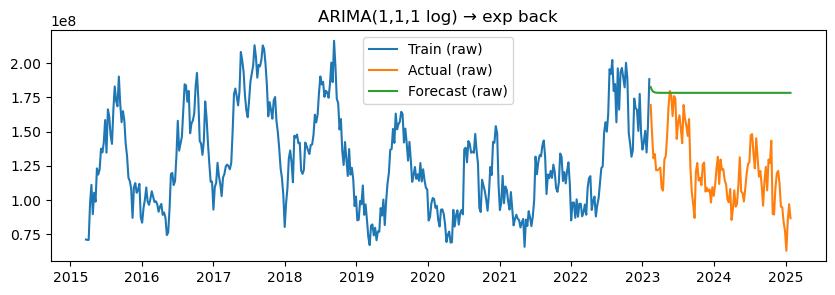

C:\Users\nwn86\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


→ SARIMAX on log (with scaled exog) summary:
                                      SARIMAX Results                                       
Dep. Variable:                         Total_TP_log   No. Observations:                  412
Model:             SARIMAX(1, 0, 0)x(0, 0, [1], 52)   Log Likelihood                 307.952
Date:                              Mon, 02 Jun 2025   AIC                           -599.904
Time:                                      13:57:21   BIC                           -568.838
Sample:                                  03-22-2015   HQIC                          -587.551
                                       - 02-05-2023                                         
Covariance Type:                                opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
PRECIP_EWMA      0.0106      0.009      1.161    

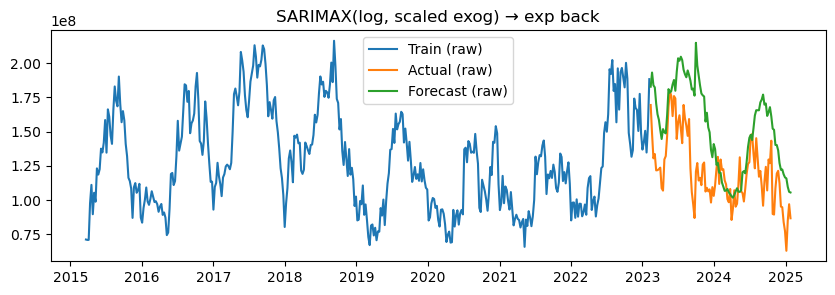

C:\Users\nwn86\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


→ SARIMAX(log) via Nelder–Mead summary:
                                      SARIMAX Results                                       
Dep. Variable:                         Total_TP_log   No. Observations:                  412
Model:             SARIMAX(1, 0, 0)x(0, 0, [1], 52)   Log Likelihood                 311.382
Date:                              Mon, 02 Jun 2025   AIC                           -606.763
Time:                                      13:57:38   BIC                           -575.697
Sample:                                  03-22-2015   HQIC                          -594.409
                                       - 02-05-2023                                         
Covariance Type:                                opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
PRECIP_EWMA      0.0196      0.009      2.077      0.0

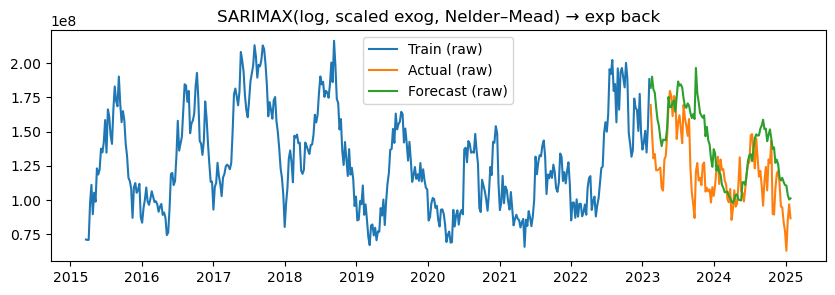

In [441]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Assume df is weekly_lagged_north with 'Total_TP' and exog_cols already defined

# 0) Create log target (Total_TP + 1)
weekly_lagged_north_log['Total_TP_log'] = np.log(weekly_lagged_north_log['Total_TP'] + 1)

# 1) Train/test split
split = int(len(weekly_lagged_north_log) * 0.8)
train = weekly_lagged_north_log.iloc[:split]
test  = weekly_lagged_north_log.iloc[split:]

target_train_log = train['Total_TP_log']
target_test_log  = test['Total_TP_log']
exog_train = train[exog_cols]
exog_test  = test[exog_cols]

# -------------------------------------------------------------------
# A) First, try pure ARIMA(1,1,1) on logs (no exog)
model_pure = SARIMAX(
    target_train_log,
    order=(1, 1, 1),
    seasonal_order=(0, 0, 0, 0),
    enforce_stationarity=False,
    enforce_invertibility=False
)
res_pure = model_pure.fit(disp=False)
print("→ ARIMA(1,1,1) on log summary:")
print(res_pure.summary())

# 1A) Forecast + exponentiate
fc_pure  = res_pure.get_forecast(steps=len(test))
pred_log_pure = fc_pure.predicted_mean
forecast_pure_raw = np.exp(pred_log_pure) - 1  # subtract 1 if you want exactly Total_TP
actual_pure_raw   = np.exp(target_test_log) - 1

mae_pure  = mean_absolute_error(actual_pure_raw, forecast_pure_raw)
rmse_pure = np.sqrt(mean_squared_error(actual_pure_raw, forecast_pure_raw))
mape_pure = np.mean(np.abs((actual_pure_raw - forecast_pure_raw) / (actual_pure_raw + 1e-10))) * 100

print(f"ARIMA(1,1,1 log→raw) → MAE: {mae_pure:.2f}, RMSE: {rmse_pure:.2f}, MAPE: {mape_pure:.2f}%")

# Plot raw vs. raw forecast
plt.figure(figsize=(10,3))
plt.plot(train.index, np.exp(target_train_log)-1, label="Train (raw)")
plt.plot(test.index,  actual_pure_raw,    label="Actual (raw)")
plt.plot(test.index,  forecast_pure_raw,  label="Forecast (raw)")
plt.legend(); plt.title("ARIMA(1,1,1 log) → exp back"); plt.show()

# If ARIMA(1,1,1) on logs is already terrible (e.g. MAPE > 100%), skip exog and try something else.

# -------------------------------------------------------------------
# B) Standardize exogenous and re‐fit SARIMAX on log
scaler = StandardScaler()
exog_train_scaled = pd.DataFrame(
    scaler.fit_transform(exog_train),
    index=exog_train.index,
    columns=exog_cols
)
exog_test_scaled = pd.DataFrame(
    scaler.transform(exog_test),
    index=exog_test.index,
    columns=exog_cols
)

model_scaled = SARIMAX(
    target_train_log,
    exog=exog_train_scaled,
    order=(1, 0, 0),
    seasonal_order=(0, 0, 1, 52),
    enforce_stationarity=False,
    enforce_invertibility=False
)
res_scaled = model_scaled.fit(disp=False)
print("→ SARIMAX on log (with scaled exog) summary:")
print(res_scaled.summary())

# Forecast + exp back
fc_scaled     = res_scaled.get_forecast(steps=len(test), exog=exog_test_scaled)
pred_log_sc   = fc_scaled.predicted_mean
forecast_sc_raw = np.exp(pred_log_sc) - 1
actual_sc_raw   = np.exp(target_test_log) - 1

mae_sc  = mean_absolute_error(actual_sc_raw, forecast_sc_raw)
rmse_sc = np.sqrt(mean_squared_error(actual_sc_raw, forecast_sc_raw))
mape_sc = np.mean(np.abs((actual_sc_raw - forecast_sc_raw) / (actual_sc_raw + 1e-10))) * 100

print(f"SARIMAX(log, scaled exog) → MAE: {mae_sc:.2f}, RMSE: {rmse_sc:.2f}, MAPE: {mape_sc:.2f}%")

# Plot raw vs. raw‐forecast
plt.figure(figsize=(10,3))
plt.plot(train.index, np.exp(target_train_log)-1, label="Train (raw)")
plt.plot(test.index,  actual_sc_raw,       label="Actual (raw)")
plt.plot(test.index,  forecast_sc_raw,     label="Forecast (raw)")
plt.legend(); plt.title("SARIMAX(log, scaled exog) → exp back"); plt.show()

# -------------------------------------------------------------------
# C) If it still fails to converge or is flat, try Nelder–Mead
res_nm = model_scaled.fit(
    method='nm',
    maxiter=500,
    disp=False
)
print("→ SARIMAX(log) via Nelder–Mead summary:")
print(res_nm.summary())

# Forecast + exp back for Nelder‐Mead solution...
fc_nm        = res_nm.get_forecast(steps=len(test), exog=exog_test_scaled)
pred_log_nm  = fc_nm.predicted_mean
forecast_nm  = np.exp(pred_log_nm) - 1
actual_nm    = np.exp(target_test_log) - 1

mae_nm  = mean_absolute_error(actual_nm, forecast_nm)
rmse_nm = np.sqrt(mean_squared_error(actual_nm, forecast_nm))
mape_nm = np.mean(np.abs((actual_nm - forecast_nm) / (actual_nm + 1e-10))) * 100

print(f"SARIMAX(log, scaled exog, Nelder–Mead) → MAE: {mae_nm:.2f}, RMSE: {rmse_nm:.2f}, MAPE: {mape_nm:.2f}%")

# Plot raw vs. raw‐forecast for NM
plt.figure(figsize=(10,3))
plt.plot(train.index, np.exp(target_train_log)-1, label="Train (raw)")
plt.plot(test.index,  actual_nm,           label="Actual (raw)")
plt.plot(test.index,  forecast_nm,         label="Forecast (raw)")
plt.legend(); plt.title("SARIMAX(log, scaled exog, Nelder–Mead) → exp back"); plt.show()


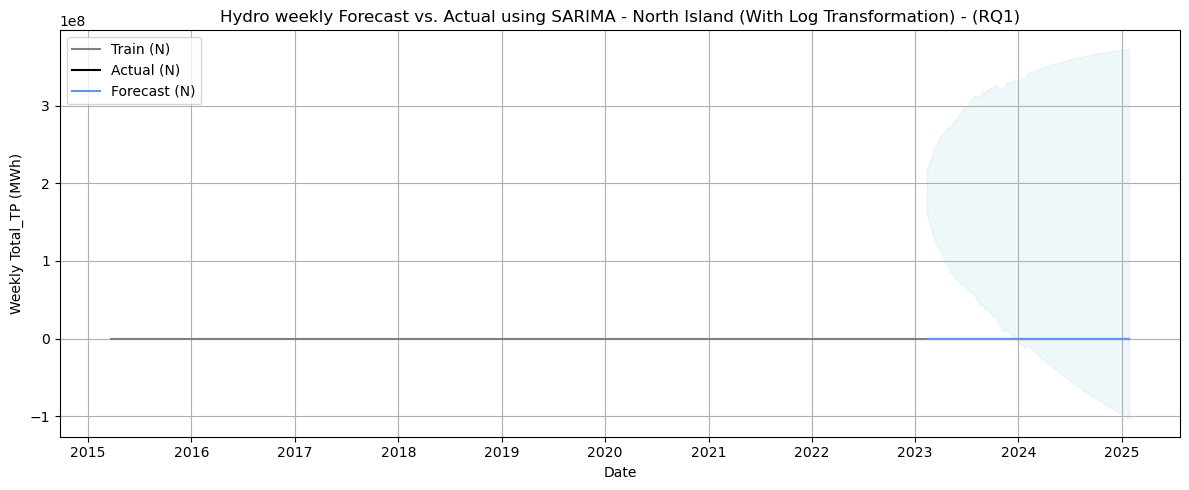

In [419]:
# Repeat a similar plot for North Island:
plt.figure(figsize=(12,5))
plt.plot(train_log_wk.index, target_train_log, label="Train (N)",   color="gray")
plt.plot(test_log_wk.index,  target_test_log,  label="Actual (N)",  color="black")
plt.plot(forecast_log.index,  forecast_log,  label="Forecast (N)",color="cornflowerblue")
plt.fill_between(
    fc_n.conf_int().index,
    fc_n.conf_int().iloc[:,0],
    fc_n.conf_int().iloc[:,1],
    color="lightblue", alpha=0.2
)
plt.legend()
plt.title("Hydro weekly Forecast vs. Actual using SARIMA - North Island (With Log Transformation) - (RQ1)")
plt.xlabel("Date")
plt.ylabel("Weekly Total_TP (MWh)")
plt.grid(True)
plt.tight_layout()
plt.show()

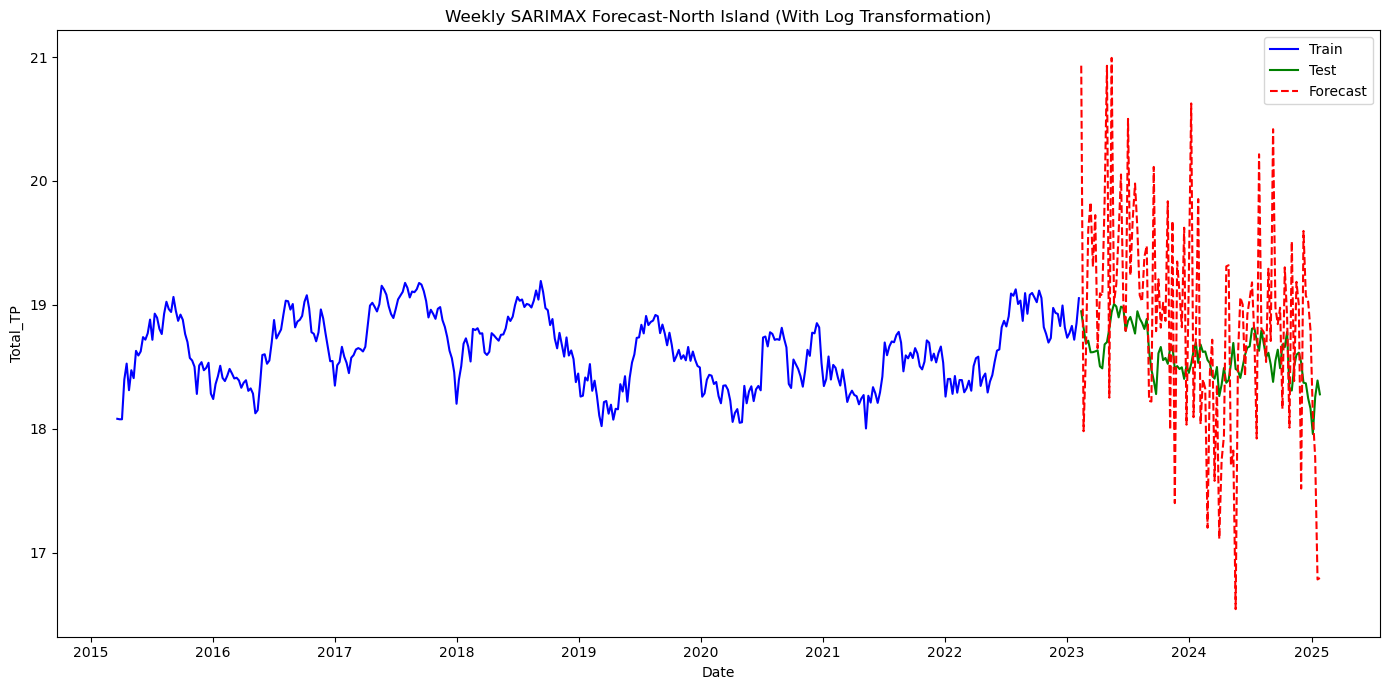

In [421]:
# Plot Actual vs. Forecast
plt.figure(figsize=(14, 7))
plt.plot(train_log_wk.index, target_train_log, label='Train', color='blue')
plt.plot(test_log_wk.index, target_test_log, label='Test', color='green')
plt.plot(forecast_log.index, forecast_log, label='Forecast', color='red', linestyle='--')
plt.xlabel("Date")
plt.ylabel("Total_TP")
plt.title("Weekly SARIMAX Forecast-North Island (With Log Transformation)")
plt.legend()
plt.tight_layout()
plt.show()
#forecast_log

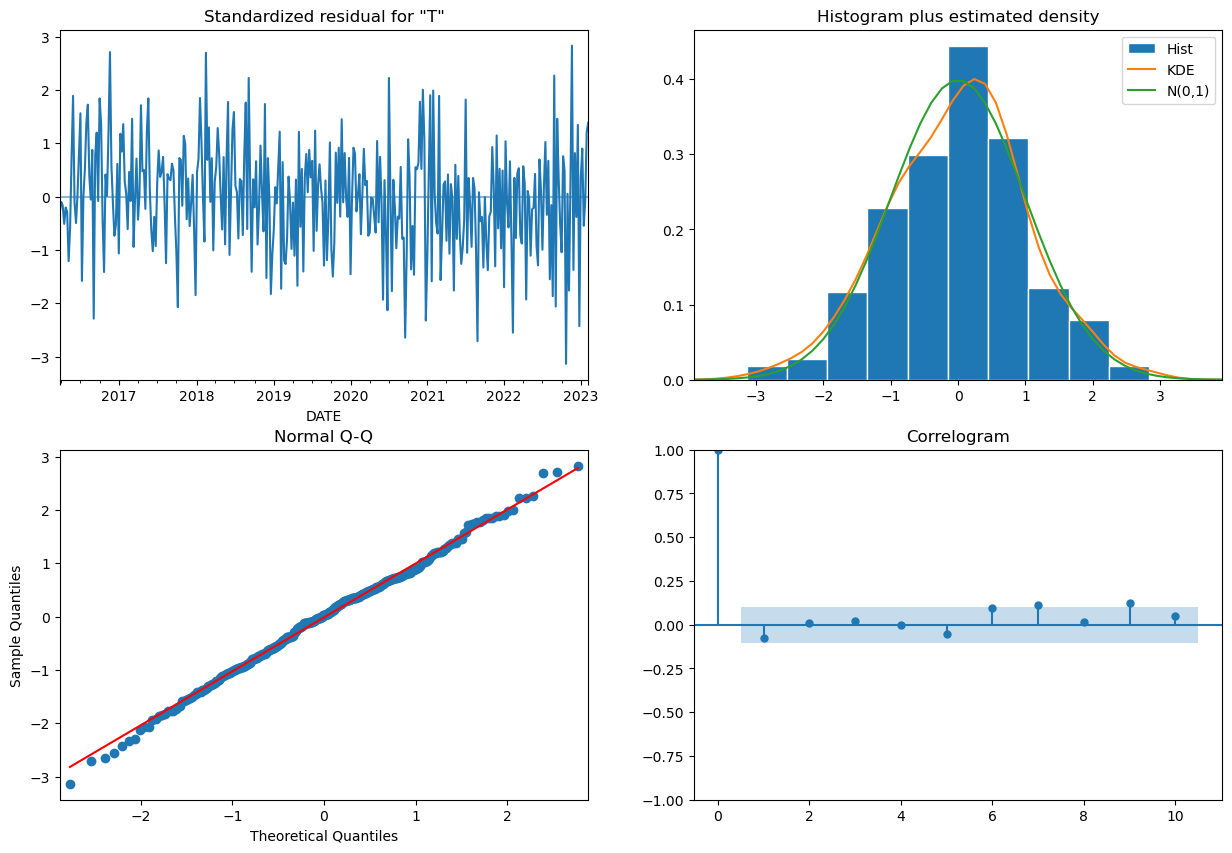

In [443]:
results.plot_diagnostics(figsize=(15, 10))
plt.show()

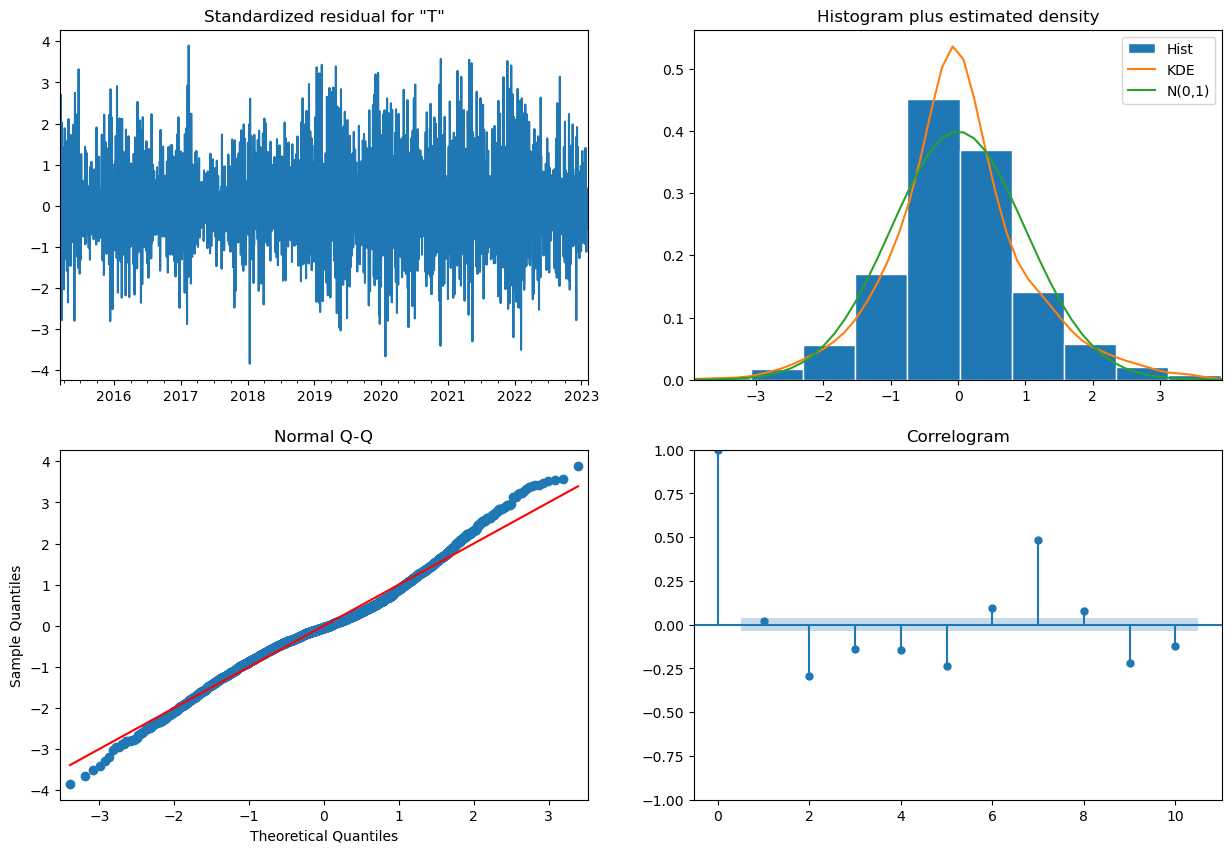

In [582]:
results_log.plot_diagnostics(figsize=(15, 10))
plt.show()

## South Island - Weekly 

In [454]:
south.head()

DATE
2015-03-22    2.950068e+08
2015-03-29    2.870318e+08
2015-04-05    2.590456e+08
2015-04-12    2.441813e+08
2015-04-19    2.735290e+08
Freq: W-SUN, Name: Total_TP, dtype: float64

In [456]:
north.head()

DATE
2015-03-22    7.120258e+07
2015-03-29    7.092097e+07
2015-04-05    7.093331e+07
2015-04-12    9.771136e+07
2015-04-19    1.111432e+08
Freq: W-SUN, Name: Total_TP, dtype: float64

In [462]:
# RQ1: South Island Univariate SARIMA (no exogenous inputs)
# Repeat the same steps for South Island:
series_s = south
n_n = len(series_s)
split_n = int(n_n * 0.8)

train_n = series_s.iloc[:split_n]
test_n  = series_s.iloc[split_n:]

model_n = SARIMAX(
    train_n,
    order=(1, 0, 0),
    seasonal_order=(0, 0, 1, 52),
    enforce_stationarity=False,
    enforce_invertibility=False
)
res_n = model_n.fit(disp=False)
print(res_n.summary())

fc_n = res_n.get_forecast(steps=len(test_n))
pred_n = pd.Series(fc_n.predicted_mean.values, index=test_n.index)

mae_n  = mean_absolute_error(test_n, pred_n)
rmse_n = np.sqrt(mean_squared_error(test_n, pred_n))
mape_n = np.mean(np.abs((test_n - pred_n) / test_n)) * 100

# rmse = np.sqrt(mean_squared_error(target_test, forecast))
# mae = mean_absolute_error(target_test, forecast)
# epsilon = 1e-10  # small constant to avoid division by zero in MAPE
# mape = np.mean(np.abs((target_test - forecast) / (target_test + epsilon))) * 100

print("South Island SARIMA(1, 0, 0)x(0, 0, 1, 52) → MAE:", f"{mae_n:.2f}",
      "RMSE:", f"{rmse_n:.2f}", "MAPE:", f"{mape_n:.2f}%")

                                      SARIMAX Results                                       
Dep. Variable:                             Total_TP   No. Observations:                  412
Model:             SARIMAX(1, 0, 0)x(0, 0, [1], 52)   Log Likelihood               -6550.646
Date:                              Mon, 02 Jun 2025   AIC                          13107.291
Time:                                      14:11:31   BIC                          13118.941
Sample:                                  03-22-2015   HQIC                         13111.924
                                       - 02-05-2023                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9972      0.004    272.540      0.000       0.990       1.004
ma.S.L52       0.14

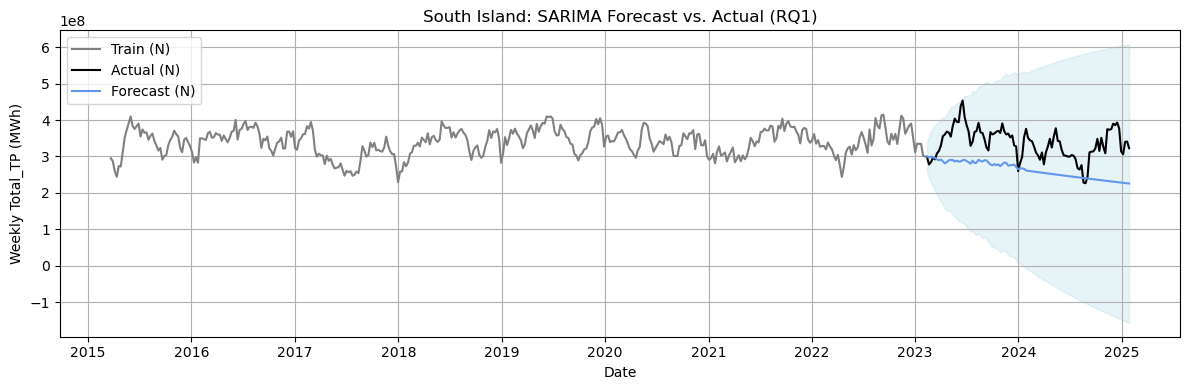

In [464]:
# Repeat a similar plot for North Island:
plt.figure(figsize=(12,4))
plt.plot(train_n.index, train_n, label="Train (N)",   color="gray")
plt.plot(test_n.index,  test_n,  label="Actual (N)",  color="black")
plt.plot(pred_n.index,  pred_n,  label="Forecast (N)",color="cornflowerblue")
plt.fill_between(
    fc_n.conf_int().index,
    fc_n.conf_int().iloc[:,0],
    fc_n.conf_int().iloc[:,1],
    color="lightblue", alpha=0.3
)
plt.legend()
plt.title("South Island: SARIMA Forecast vs. Actual (RQ1)")
plt.xlabel("Date")
plt.ylabel("Weekly Total_TP (MWh)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [466]:
# Find rows with zero Total_TP in South Island
zero_tp_south = weekly_lagged_south[weekly_lagged_south['Total_TP'] == 0]

# Get the unique dates
zero_dates = zero_tp_south.index.unique()

# Display the result
print("Dates with Total_TP = 0 in South Island:")
for date in zero_dates:
    print(date.strftime('%Y-%m-%d'))

Dates with Total_TP = 0 in South Island:


In [468]:
weekly_lagged_south.head(5)

Total_TP      TP_lag1w  PRECTOTCORR  PRECIP_lag1w  \
DATE                                                                
2015-03-22  2.950068e+08  3.243453e+08       264.80        156.42   
2015-03-29  2.870318e+08  2.950068e+08       367.40        264.80   
2015-04-05  2.590456e+08  2.870318e+08       189.24        367.40   
2015-04-12  2.441813e+08  2.590456e+08       470.76        189.24   
2015-04-19  2.735290e+08  2.441813e+08       333.51        470.76   

            APIxGWETPROF  PRECIP_lag2w  PRECIP_EWMA  EVLAND  EVLAND_lag1w  \
DATE                                                                        
2015-03-22    231.898854        767.35   488.289700  165.01        228.78   
2015-03-29    217.903685        156.42   452.022790  154.86        165.01   
2015-04-05    183.217514        264.80   373.187953  177.98        154.86   
2015-04-12    202.251903        367.40   402.459567  166.54        177.98   
2015-04-19    198.916737        189.24   381.774697  129.33        166.54   

            EVLAND_EWMA       RH2M  RH2M_lag1w  GWETPROF  GWETPROF_lag1w  \
DATE                                                                       
2015-03-22   224.290200  80.292381   77.127698  0.474921        0.480000   
2015-03-29   203.461140  83.572698   80.292381  0.482063        0.474921   
2015-04-05   195.816798  79.877222   83.572698  0.490952        0.482063   
2015-04-12   187.033759  83.569683   79.877222  0.502540        0.490952   
2015-04-19   169.722631  85.104524   83.569683  0.521032        0.502540   

                  T2M  T2M_lag1w  
DATE                              
2015-03-22   8.037778  12.604048  
2015-03-29  11.639524   8.037778  
2015-04-05  11.092937  11.639524  
2015-04-12   9.989206  11.092937  
2015-04-19   4.725635   9.989206

In [470]:
# Split the weekly data into 80% training and 20% testing sets
n = len(weekly_lagged_south)
train_size = int(n * 0.8)
train_weekly = weekly_lagged_south.iloc[:train_size]
test_weekly = weekly_lagged_south.iloc[train_size:]

In [472]:
print("Weekly Train set:", train_weekly.index.min(), "to", train_weekly.index.max() , " Records count : ",len(train_weekly) )
print("Weekly Test set:", test_weekly.index.min(), "to", test_weekly.index.max(), " Records count : ",len(test_weekly) )

Weekly Train set: 2015-03-22 00:00:00 to 2023-02-05 00:00:00  Records count :  412
Weekly Test set: 2023-02-12 00:00:00 to 2025-01-26 00:00:00  Records count :  103


In [474]:
# Define the target variable (original Total_TP) and exogenous variables
# target_train_log = train_weekly['Total_TP_log']
# target_test_log = test_weekly['Total_TP_log']

target_train = train_weekly['Total_TP']
target_test = test_weekly['Total_TP']


In [503]:
#['Total_TP', 'PRECTOTCORR', 'EVLAND', 'RH2M', 'GWETPROF', 'T2M', 'PRECIP_lag1w', 'PRECIP_lag2w', 'API_weekly']
#befoe exog_cols_wk = ['RH2M', 'GWETPROF', 'PRECIP_lag1w', 'PRECIP_lag2w', 'API_weekly']
exog_cols_wk = ['TP_lag1w','APIxGWETPROF','PRECIP_EWMA','GWETPROF_lag1w']
#exog_cols_wk = ['APIxGWETPROF','PRECIP_EWMA','GWETPROF_lag1w']
#exog_cols = ['WS50M']
#'TP_lag1w','APIxGWETPROF','PRECIP_EWMA','GWETPROF_lag1w'

In [505]:
exog_train = train_weekly[exog_cols_wk]
exog_test = test_weekly[exog_cols_wk]

In [507]:
# RQ2: South Island SARIMAX with climate exogenous features
# Fit SARIMAX on the original (non-log) target data
#1. South Island SARIMA(1, 0, 0)x(0, 0, 1, 52) → MAE: 75226135.36 RMSE: 84557781.81 MAPE: 21.44%
#2. South Island SARIMA(1, 0, 1)x(0, 0, 1, 52) → MAE: 68755956.11 RMSE: 77859468.87 MAPE: 19.54%
model = SARIMAX(target_train,
                exog=exog_train,
                order=(1, 0, 0),
                seasonal_order=(0, 0, 1, 52),
                enforce_stationarity=False,
                enforce_invertibility=False)
results = model.fit(disp=False)
print(results.summary())

                                      SARIMAX Results                                       
Dep. Variable:                             Total_TP   No. Observations:                  412
Model:             SARIMAX(1, 0, 0)x(0, 0, [1], 52)   Log Likelihood               -6530.871
Date:                              Mon, 02 Jun 2025   AIC                          13075.741
Time:                                      14:28:17   BIC                          13102.925
Sample:                                  03-22-2015   HQIC                         13086.551
                                       - 02-05-2023                                         
Covariance Type:                                opg                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
TP_lag1w           0.8415      0.010     82.039      0.000       0.821       0.862
APIxGWE

In [508]:
# Forecast on the test set - non log
n_steps = len(test_weekly)
forecast = results.get_forecast(steps=n_steps, exog=exog_test).predicted_mean

In [511]:
# Compute performance metrics - non log
rmse = np.sqrt(mean_squared_error(target_test, forecast))
mae = mean_absolute_error(target_test, forecast)
epsilon = 1e-10  # small constant to avoid division by zero in MAPE
mape = np.mean(np.abs((target_test - forecast) / (target_test + epsilon))) * 100

print("\nForecast Performance Metrics (Without Log Transformation):")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"Adjusted MAPE: {mape:.2f}%")


Forecast Performance Metrics (Without Log Transformation):
RMSE: 21690736.24
MAE: 16094837.98
Adjusted MAPE: 4.90%


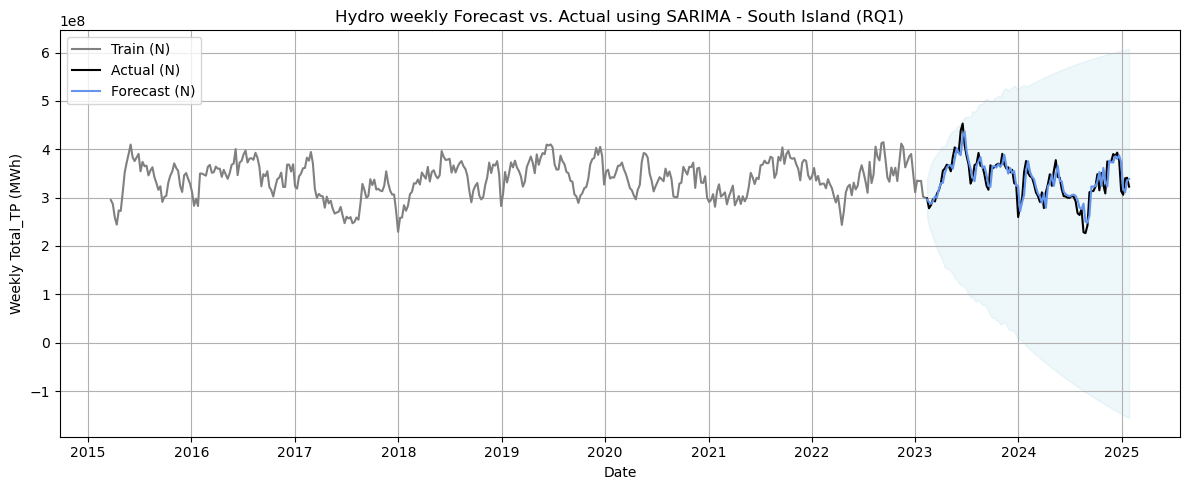

In [513]:
# # Plot Actual vs. Forecast
# plt.figure(figsize=(14, 7))
# plt.plot(train_weekly.index, target_train, label='Train', color='blue')
# plt.plot(test_weekly.index, target_test, label='Test', color='green')
# plt.plot(test_weekly.index, forecast, label='Forecast', color='red', linestyle='--')
# plt.xlabel("Date")
# plt.ylabel("Total_TP")
# plt.title("Weekly SARIMAX Forecast-North Island (Without Log Transformation)")
# plt.legend()
# plt.tight_layout()
# plt.show()

# Repeat a similar plot for North Island:
plt.figure(figsize=(12,5))
plt.plot(train_weekly.index, target_train, label="Train (N)",   color="gray")
plt.plot(test_weekly.index,  target_test,  label="Actual (N)",  color="black")
plt.plot(forecast.index,  forecast,  label="Forecast (N)",color="cornflowerblue")
plt.fill_between(
    fc_n.conf_int().index,
    fc_n.conf_int().iloc[:,0],
    fc_n.conf_int().iloc[:,1],
    color="lightblue", alpha=0.2
)
plt.legend()
plt.title("Hydro weekly Forecast vs. Actual using SARIMA - South Island (RQ1)")
plt.xlabel("Date")
plt.ylabel("Weekly Total_TP (MWh)")
plt.grid(True)
plt.tight_layout()
plt.show()

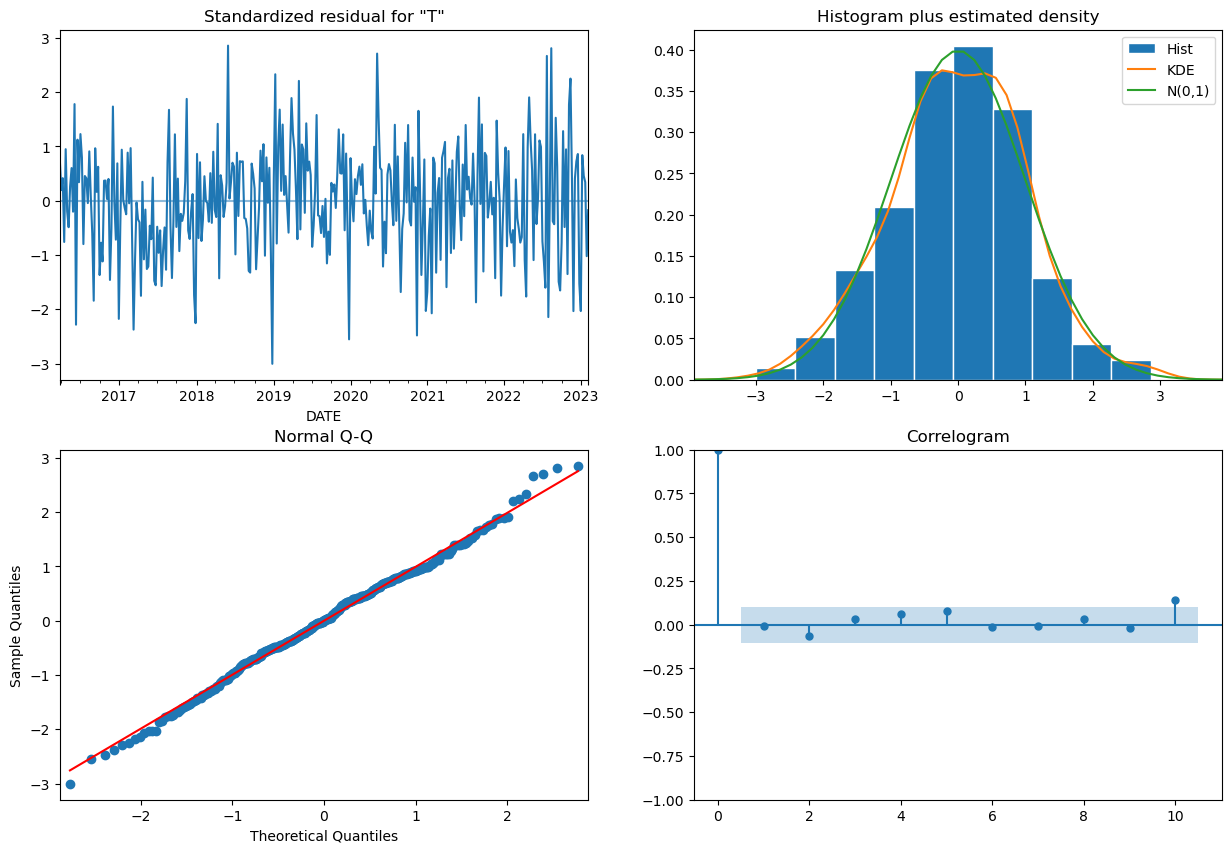

In [515]:
results.plot_diagnostics(figsize=(15, 10))
plt.show()

## End North Island

## Start South Island 

In [648]:
df_south_daily_tmp.head()

Total_TP  PRECTOTCORR  EVLAND       RH2M  GWETPROF        T2M  \
DATE                                                                            
2015-03-08  4.021101e+07        10.86   38.82  77.198889  0.487778  11.177778   
2015-03-09  4.765196e+07         5.90   37.61  73.290556  0.485000  12.833889   
2015-03-10  4.827393e+07        31.42   33.75  76.682778  0.480556  13.700556   
2015-03-11  4.796238e+07        10.14   30.15  82.308889  0.481667  12.421111   
2015-03-12  4.968572e+07        19.01   31.70  78.986111  0.479444  13.715556   

            PRECIP_7d  PRECIP_14d  PRECIP_lag1  PRECIP_lag7  
DATE                                                         
2015-03-08     767.35      819.88       209.98        52.53  
2015-03-09     600.41      825.78        10.86       172.84  
2015-03-10     581.44      857.20         5.90        50.39  
2015-03-11     576.43      867.34        31.42        15.15  
2015-03-12     582.76      886.35        10.14        12.68

In [646]:
# df_hydro_daily_tmp
# df_south_daily_tmp
# df_north_daily_tmp --- done

In [650]:
# Find rows with zero Total_TP in South Island
zero_tp_south = df_south_daily_tmp[df_south_daily_tmp['Total_TP'] == 0]

# Get the unique dates
zero_dates = zero_tp_south.index.unique()

# Display the result
print("Dates with Total_TP = 0 in South Island:")
for date in zero_dates:
    print(date.strftime('%Y-%m-%d'))

Dates with Total_TP = 0 in South Island:


If a zero actually means no generation (e.g., turbine was off), you might not want to interpolate—but if it’s a data artifact or gap, this is valid.

In [652]:
# Split the weekly data into 80% training and 20% testing sets
n = len(df_south_daily_tmp)
train_size = int(n * 0.8)
train_daily = df_south_daily_tmp.iloc[:train_size]
test_daily = df_south_daily_tmp.iloc[train_size:]

In [654]:
# print("Daily Train set:", train_weekly.index.min(), "to", train_weekly.index.max())
# print("Weekly Test set:", test_weekly.index.min(), "to", test_weekly.index.max())

print("Daily Train set:", train_daily.index.min(), "to", train_daily.index.max() , " Records count : ",len(train_daily) )
print("Daily Test set:", test_daily.index.min(), "to", test_daily.index.max(), " Records count : ",len(test_daily) )

Daily Train set: 2015-03-08 00:00:00 to 2023-02-07 00:00:00  Records count :  2894
Daily Test set: 2023-02-08 00:00:00 to 2025-01-31 00:00:00  Records count :  724


In [656]:
# Define the target variable (original Total_TP) and exogenous variables
# target_train_log = train_weekly['Total_TP_log']
# target_test_log = test_weekly['Total_TP_log']

target_train = train_daily['Total_TP']
target_test = test_daily['Total_TP']



In [ ]:
exog_cols = ['RH2M','GWETPROF','PRECTOTCORR_lag1']
#exog_cols = ['RH2M', 'GWETPROF', 'EVLAND', 'T2M']
#exog_cols = ['RH2M', 'GWETPROF', 'EVLAND', 'T2M','PRECTOTCORR_lag1']
#exog_cols = ['T2M','PRECTOTCORR_lag7','GWETPROF']
#exog_cols = ['EVLAND','T2M']
#exog_cols = ['GWETPROF','EVLAND','T2M']
#exog_cols = ['PRECTOTCORR','GWETPROF','EVLAND','T2M']
#exog_cols = ['RH2M','PRECTOTCORR','GWETPROF','EVLAND','T2M']
#exog_cols = ['WS50M']
#exog_cols = ['WS50M','PS']
#exog_cols = ['WS50M']


In [658]:
exog_train = train_daily[exog_cols]
exog_test = test_daily[exog_cols]

In [660]:
# Fit SARIMAX on the original (non-log) target data
model = SARIMAX(target_train,
                exog=exog_train,
                order=(1, 1, 1),
                seasonal_order=(0, 0, 0, 0),
                enforce_stationarity=False,
                enforce_invertibility=False)
results = model.fit(disp=False)
print(results.summary())

C:\Users\nwn86\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nwn86\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:               Total_TP   No. Observations:                 2894
Model:               SARIMAX(1, 1, 1)   Log Likelihood              -47663.522
Date:                Fri, 18 Apr 2025   AIC                          95339.043
Time:                        09:50:17   BIC                          95374.859
Sample:                    03-08-2015   HQIC                         95351.951
                         - 02-07-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
RH2M       -1.117e+04   1.69e+04     -0.661      0.509   -4.43e+04     2.2e+04
GWETPROF    1.773e+07      3.858    4.6e+06      0.000    1.77e+07    1.77e+07
PRECIP_14d -2113.7371    511.281     -4.134      0.0

In [662]:
# Forecast on the test set - non log
n_steps = len(test_daily)
forecast = results.get_forecast(steps=n_steps, exog=exog_test).predicted_mean

In [664]:
# Compute performance metrics - non log
rmse = np.sqrt(mean_squared_error(target_test, forecast))
mae = mean_absolute_error(target_test, forecast)
epsilon = 1e-10  # small constant to avoid division by zero in MAPE
mape = np.mean(np.abs((target_test - forecast) / (target_test + epsilon))) * 100

print("\nForecast Performance Metrics (Without Log Transformation):")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"Adjusted MAPE: {mape:.2f}%")


Forecast Performance Metrics (Without Log Transformation):
RMSE: 7337810.55
MAE: 5918806.18
Adjusted MAPE: 12.33%


In [666]:
print("Minimum of actual values in test set:", target_test.min())
print("Number of zeros in actual test set:", np.sum(target_test == 0))

Minimum of actual values in test set: 24448887.0
Number of zeros in actual test set: 0


In [ ]:
#
# exog_cols = ['WS50M']
# Forecast Performance Metrics (Without Log Transformation):
# RMSE: 273334.64
# MAE: 213157.34
# Adjusted MAPE: 33.02%
##########################################
# exog_cols = ['WS50M','PS']
# Forecast Performance Metrics (Without Log Transformation):
# RMSE: 277535.29
# MAE: 217705.17
# Adjusted MAPE: 33.91%

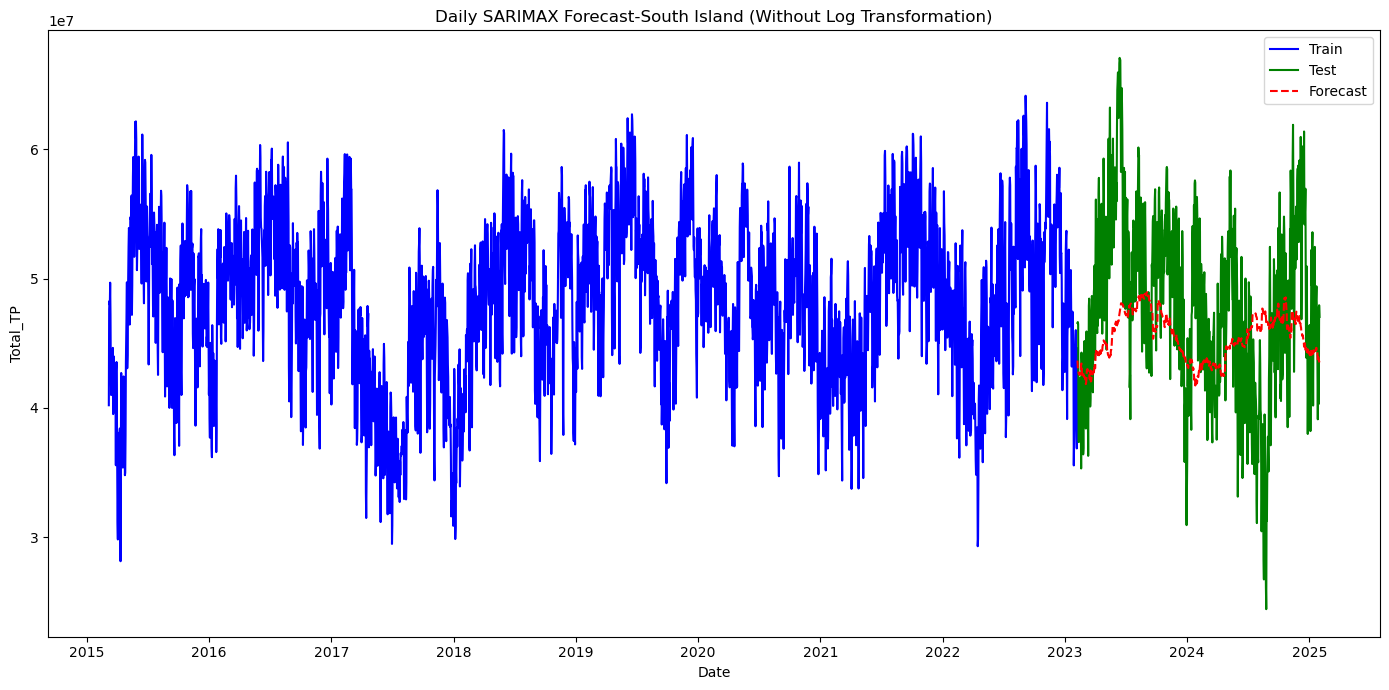

In [668]:
# Plot Actual vs. Forecast
plt.figure(figsize=(14, 7))
plt.plot(train_daily.index, target_train, label='Train', color='blue')
plt.plot(test_daily.index, target_test, label='Test', color='green')
plt.plot(test_daily.index, forecast, label='Forecast', color='red', linestyle='--')
plt.xlabel("Date")
plt.ylabel("Total_TP")
plt.title("Daily SARIMAX Forecast-South Island (Without Log Transformation)")
plt.legend()
plt.tight_layout()
plt.show()

In [672]:
# # Create a log-transformed target. Adding 1 to avoid log(0) if needed.
df_south_daily_tmp['Total_TP_log'] = np.log(df_south_daily_tmp['Total_TP'] + 1)

In [674]:
# Split the weekly data into 80% training and 20% testing sets
n = len(df_south_daily_tmp)
train_size = int(n * 0.8)
train_daily = df_south_daily_tmp.iloc[:train_size]
test_daily = df_south_daily_tmp.iloc[train_size:]

In [676]:
# Define the target variable (original Total_TP) and exogenous variables
target_train_log = train_daily['Total_TP_log']
target_test_log = test_daily['Total_TP_log']

# target_train = train_weekly['Total_TP']
# target_test = test_weekly['Total_TP']

In [ ]:
exog_cols = ['RH2M','GWETPROF','PRECTOTCORR_lag1']
#exog_cols = ['RH2M', 'GWETPROF', 'EVLAND', 'T2M']
#exog_cols = ['RH2M', 'GWETPROF', 'EVLAND', 'T2M','PRECTOTCORR_lag1']
#exog_cols = ['T2M','PRECTOTCORR_lag7','GWETPROF']
#exog_cols = ['EVLAND','T2M']
#exog_cols = ['GWETPROF','EVLAND','T2M']
#exog_cols = ['PRECTOTCORR','GWETPROF','EVLAND','T2M']
#exog_cols = ['RH2M','PRECTOTCORR','GWETPROF','EVLAND','T2M']
#exog_cols = ['WS50M']
#exog_cols = ['WS50M','PS']
#exog_cols = ['WS50M']


In [678]:
exog_train = train_daily[exog_cols]
exog_test = test_daily[exog_cols]

In [680]:
# Fit SARIMAX on the original (log) target data
model_log = SARIMAX(target_train_log,
                exog=exog_train,
                order=(1, 1, 1),
                seasonal_order=(0, 0, 0, 0),
                enforce_stationarity=False,
                enforce_invertibility=False)
results_log = model_log.fit(disp=False)
print(results_log.summary())

C:\Users\nwn86\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nwn86\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:           Total_TP_log   No. Observations:                 2894
Model:               SARIMAX(1, 1, 1)   Log Likelihood                3202.576
Date:                Fri, 18 Apr 2025   AIC                          -6393.152
Time:                        10:12:08   BIC                          -6357.335
Sample:                    03-08-2015   HQIC                         -6380.244
                         - 02-07-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
RH2M          -0.0001      0.000     -0.419      0.675      -0.001       0.000
GWETPROF       0.3944      0.308      1.280      0.201      -0.210       0.998
PRECIP_14d -4.854e-05   1.57e-05     -3.091      0.0

In [682]:
# Forecast on the test set
n_steps_log = len(test_daily)
forecast_log = results_log.get_forecast(steps=n_steps_log, exog=exog_test).predicted_mean

In [684]:
# Compute performance metrics
rmse = np.sqrt(mean_squared_error(target_test_log, forecast_log))
mae = mean_absolute_error(target_test_log, forecast_log)
epsilon = 1e-10  # small constant to avoid division by zero in MAPE
mape = np.mean(np.abs((target_test_log - forecast_log) / (target_test_log + epsilon))) * 100

print("\nForecast Performance Metrics (With Log Transformation):")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"Adjusted MAPE: {mape:.2f}%")


Forecast Performance Metrics (With Log Transformation):
RMSE: 0.15
MAE: 0.12
Adjusted MAPE: 0.66%


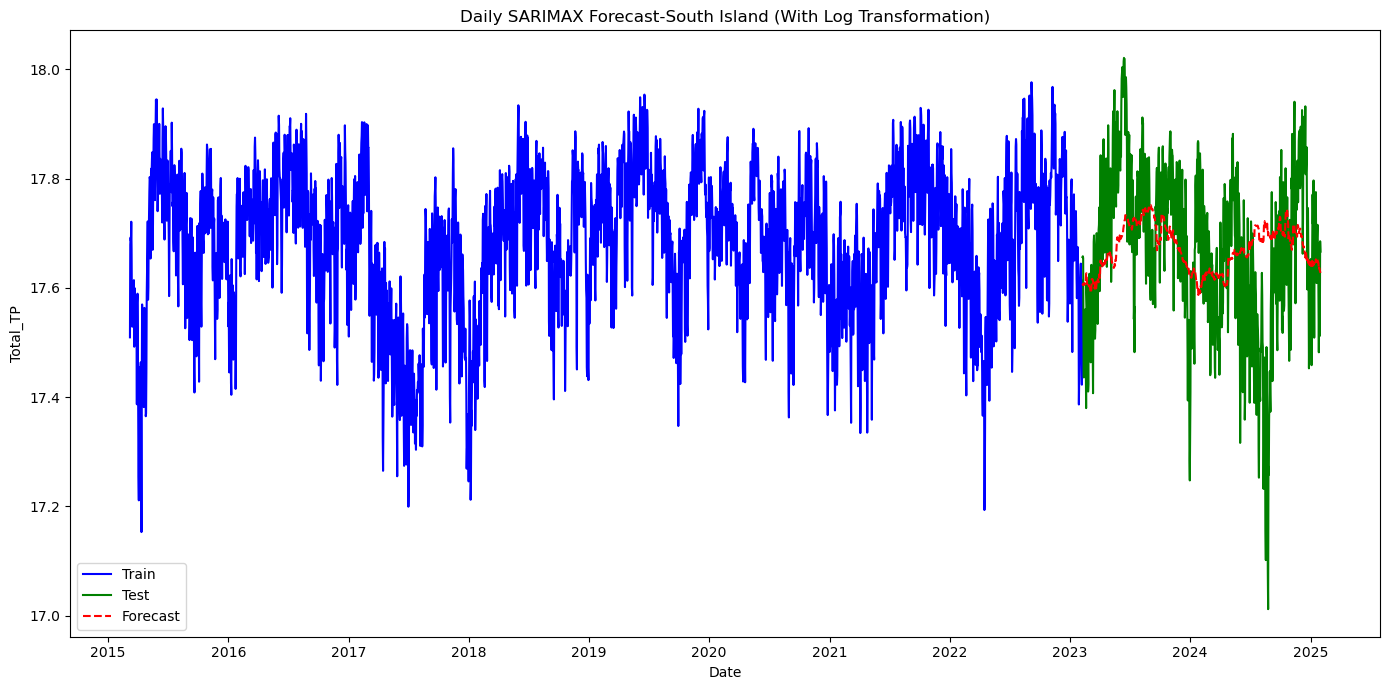

In [686]:
# Plot Actual vs. Forecast
plt.figure(figsize=(14, 7))
plt.plot(train_daily.index, target_train_log, label='Train', color='blue')
plt.plot(test_daily.index, target_test_log, label='Test', color='green')
plt.plot(test_daily.index, forecast_log, label='Forecast', color='red', linestyle='--')
plt.xlabel("Date")
plt.ylabel("Total_TP")
plt.title("Daily SARIMAX Forecast-South Island (With Log Transformation)")
plt.legend()
plt.tight_layout()
plt.show()

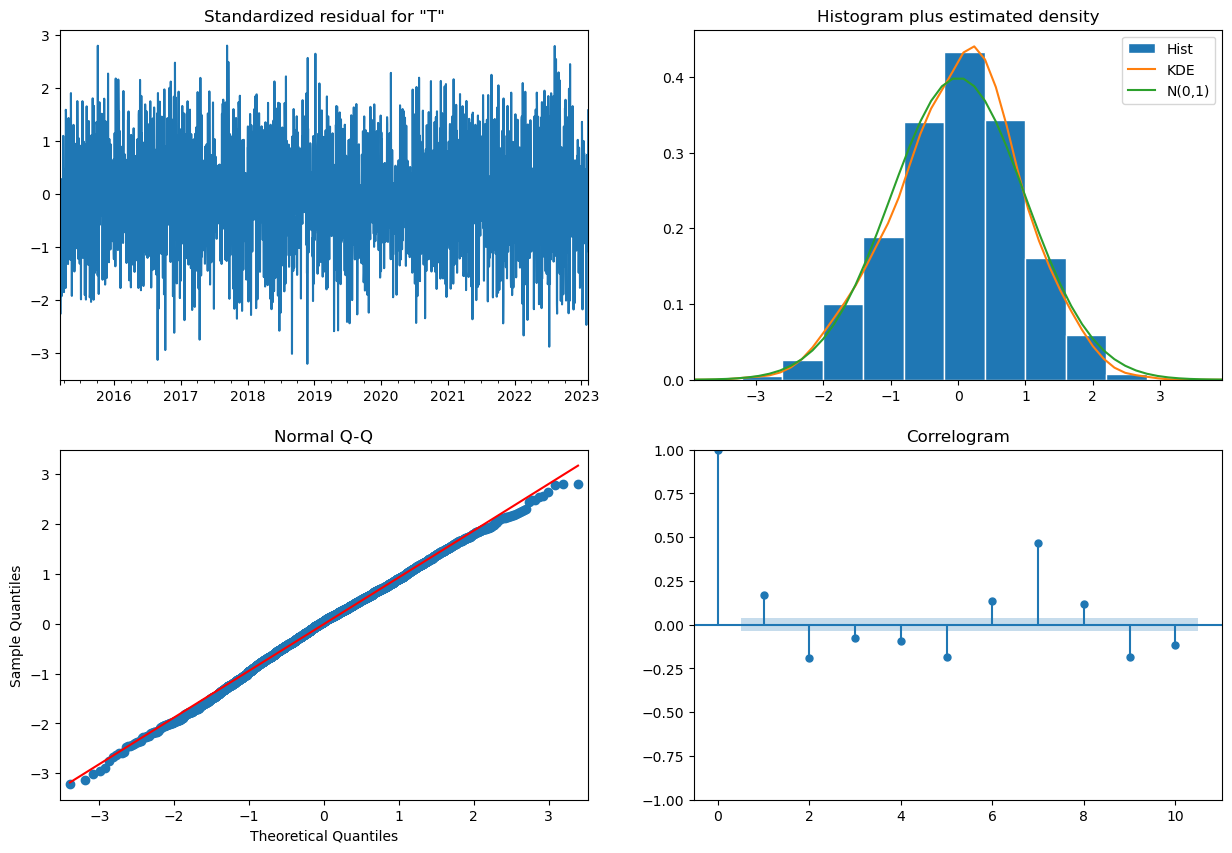

In [696]:
results.plot_diagnostics(figsize=(15, 10))
plt.show()

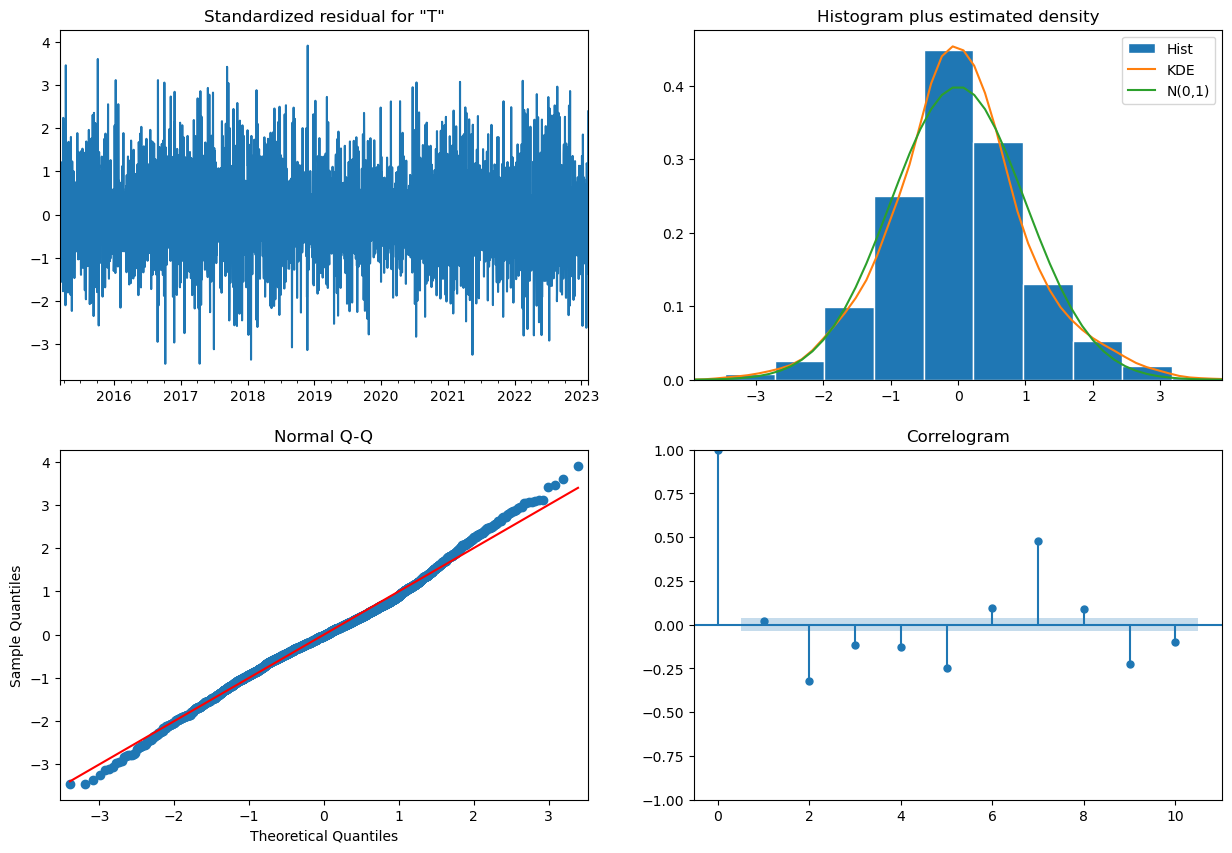

In [698]:
results_log.plot_diagnostics(figsize=(15, 10))
plt.show()

In [ ]:
#######################

### Weekly - South Island

In [701]:
# df_hydro_weekly_tmp
# df_south_island_weekly_tmp
# df_north_island_weekly_tmp -- done

In [705]:
# Find rows with zero Total_TP in South Island
zero_tp_south = df_south_island_weekly_tmp[df_south_island_weekly_tmp['Total_TP'] == 0]

# Get the unique dates
zero_dates = zero_tp_south.index.unique()

# Display the result
print("Dates with Total_TP = 0 in South Island:")
for date in zero_dates:
    print(date.strftime('%Y-%m-%d'))

Dates with Total_TP = 0 in South Island:


In [707]:
df_south_island_weekly_tmp.head(5)

Total_TP  PRECTOTCORR  EVLAND       RH2M  GWETPROF        T2M  \
DATE                                                                            
2015-03-22  2.950068e+08       264.80  165.01  80.292381  0.474921   8.037778   
2015-03-29  2.870318e+08       367.40  154.86  83.572698  0.482063  11.639524   
2015-04-05  2.590456e+08       189.24  177.98  79.877222  0.490952  11.092937   
2015-04-12  2.441813e+08       470.76  166.54  83.569683  0.502540   9.989206   
2015-04-19  2.735290e+08       333.51  129.33  85.104524  0.521032   4.725635   

            PRECIP_lag1w  PRECIP_lag2w  API_weekly  
DATE                                                
2015-03-22        156.42        767.35  488.289700  
2015-03-29        264.80        156.42  452.022790  
2015-04-05        367.40        264.80  373.187953  
2015-04-12        189.24        367.40  402.459567  
2015-04-19        470.76        189.24  381.774697

In [709]:
# Split the weekly data into 80% training and 20% testing sets
n = len(df_south_island_weekly_tmp)
train_size = int(n * 0.8)
train_weekly = df_south_island_weekly_tmp.iloc[:train_size]
test_weekly = df_south_island_weekly_tmp.iloc[train_size:]

In [711]:
print("Weekly Train set:", train_weekly.index.min(), "to", train_weekly.index.max() , " Records count : ",len(train_weekly) )
print("Weekly Test set:", test_weekly.index.min(), "to", test_weekly.index.max(), " Records count : ",len(test_weekly) )

Weekly Train set: 2015-03-22 00:00:00 to 2023-02-05 00:00:00  Records count :  412
Weekly Test set: 2023-02-12 00:00:00 to 2025-01-26 00:00:00  Records count :  103


In [713]:
# Define the target variable (original Total_TP) and exogenous variables
# target_train_log = train_weekly['Total_TP_log']
# target_test_log = test_weekly['Total_TP_log']

target_train = train_weekly['Total_TP']
target_test = test_weekly['Total_TP']


In [715]:
#['Total_TP', 'PRECTOTCORR', 'EVLAND', 'RH2M', 'GWETPROF', 'T2M', 'PRECIP_lag1w', 'PRECIP_lag2w', 'API_weekly']
exog_cols_wk = ['RH2M', 'GWETPROF', 'PRECIP_lag1w', 'PRECIP_lag2w', 'API_weekly']
#exog_cols = ['WS50M']

In [717]:
exog_train = train_weekly[exog_cols_wk]
exog_test = test_weekly[exog_cols_wk]

In [719]:
# Fit SARIMAX on the original (non-log) target data
model = SARIMAX(target_train,
                exog=exog_train,
                order=(1, 1, 1),
                seasonal_order=(0, 0, 0, 0),
                enforce_stationarity=False,
                enforce_invertibility=False)
results = model.fit(disp=False)
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:               Total_TP   No. Observations:                  412
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -7444.733
Date:                Fri, 18 Apr 2025   AIC                          14905.465
Time:                        10:24:29   BIC                          14937.575
Sample:                    03-22-2015   HQIC                         14918.170
                         - 02-05-2023                                         
Covariance Type:                  opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
RH2M          6.199e+05   3.13e+05      1.978      0.048    5611.052    1.23e+06
GWETPROF      9.043e+07    888.260   1.02e+05      0.000    9.04e+07    9.04e+07
PRECIP_lag1w  1.417e+04   3684.342      3.84

C:\Users\nwn86\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
C:\Users\nwn86\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


In [721]:
# Forecast on the test set - non log
n_steps = len(test_weekly)
forecast = results.get_forecast(steps=n_steps, exog=exog_test).predicted_mean

In [723]:
# Compute performance metrics - non log
rmse = np.sqrt(mean_squared_error(target_test, forecast))
mae = mean_absolute_error(target_test, forecast)
epsilon = 1e-10  # small constant to avoid division by zero in MAPE
mape = np.mean(np.abs((target_test - forecast) / (target_test + epsilon))) * 100

print("\nForecast Performance Metrics (Without Log Transformation):")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"Adjusted MAPE: {mape:.2f}%")


Forecast Performance Metrics (Without Log Transformation):
RMSE: 41522307.07
MAE: 33634842.31
Adjusted MAPE: 10.25%


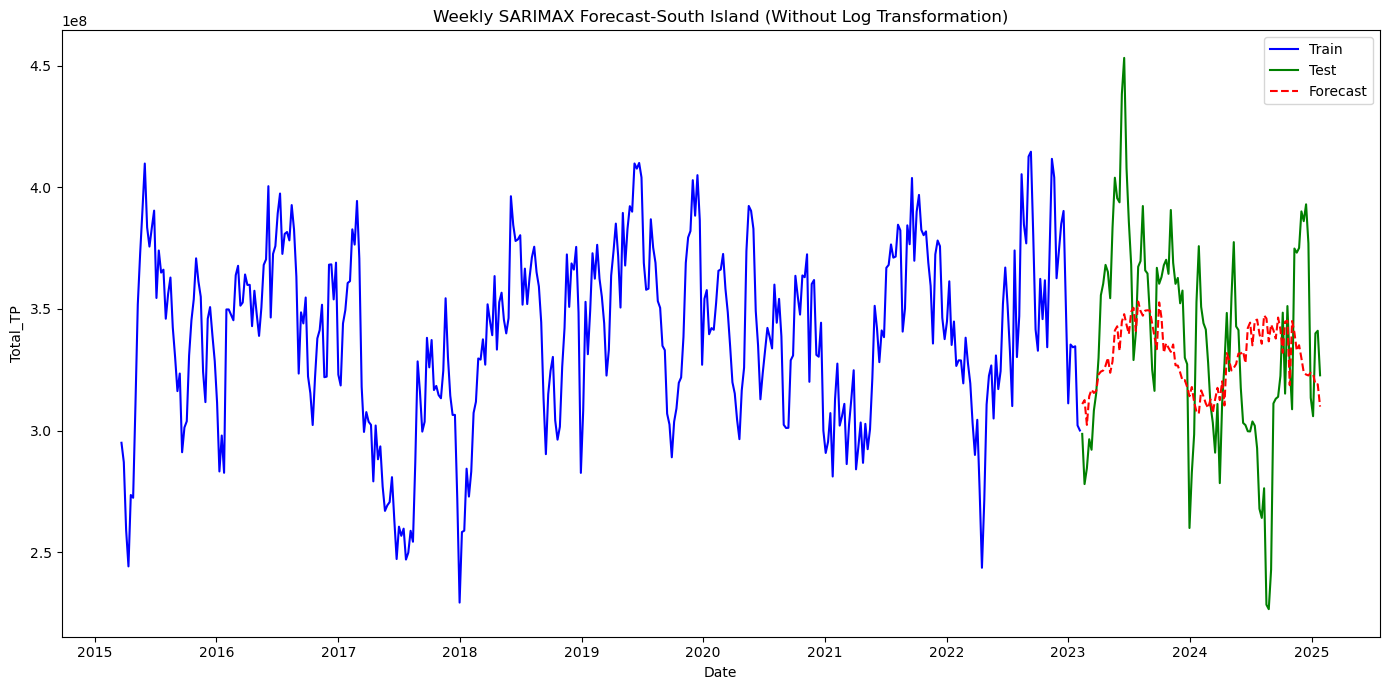

In [725]:
# Plot Actual vs. Forecast
plt.figure(figsize=(14, 7))
plt.plot(train_weekly.index, target_train, label='Train', color='blue')
plt.plot(test_weekly.index, target_test, label='Test', color='green')
plt.plot(test_weekly.index, forecast, label='Forecast', color='red', linestyle='--')
plt.xlabel("Date")
plt.ylabel("Total_TP")
plt.title("Weekly SARIMAX Forecast-South Island (Without Log Transformation)")
plt.legend()
plt.tight_layout()
plt.show()

In [727]:
# # Create a log-transformed target. Adding 1 to avoid log(0) if needed.
df_south_island_weekly_tmp['Total_TP_log'] = np.log(df_south_island_weekly_tmp['Total_TP'] + 1)

In [729]:
# Split the weekly data into 80% training and 20% testing sets
# n = len(df_island_north_weekly)
# train_size = int(n * 0.8)
# train_weekly = df_island_north.iloc[:train_size]
# test_weekly = df_island_north.iloc[train_size:]

# Split the weekly data into 80% training and 20% testing sets
n = len(df_south_island_weekly_tmp)
train_size = int(n * 0.8)
train_weekly = df_south_island_weekly_tmp.iloc[:train_size]
test_weekly = df_south_island_weekly_tmp.iloc[train_size:]

In [731]:
print("Weekly Train set:", train_weekly.index.min(), "to", train_weekly.index.max() , " Records count : ",len(train_weekly) )
print("Weekly Test set:", test_weekly.index.min(), "to", test_weekly.index.max(), " Records count : ",len(test_weekly) )

Weekly Train set: 2015-03-22 00:00:00 to 2023-02-05 00:00:00  Records count :  412
Weekly Test set: 2023-02-12 00:00:00 to 2025-01-26 00:00:00  Records count :  103


In [733]:
# Define the target variable (original Total_TP) and exogenous variables
target_train_log = train_weekly['Total_TP_log']
target_test_log = test_weekly['Total_TP_log']

# target_train = train_weekly['Total_TP']
# target_test = test_weekly['Total_TP']


In [ ]:

# exog_cols = ['WS50M','PS']
#exog_cols = ['WS50M']


In [735]:
exog_train = train_weekly[exog_cols_wk]
exog_test = test_weekly[exog_cols_wk]

In [737]:
# Fit SARIMAX on the original (log) target data
model_log = SARIMAX(target_train_log,
                exog=exog_train,
                order=(1, 1, 1),
                seasonal_order=(0, 0, 0, 0),
                enforce_stationarity=False,
                enforce_invertibility=False)
results_log = model_log.fit(disp=False)
print(results_log.summary())

C:\Users\nwn86\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
C:\Users\nwn86\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:           Total_TP_log   No. Observations:                  412
Model:               SARIMAX(1, 1, 1)   Log Likelihood                 584.340
Date:                Fri, 18 Apr 2025   AIC                          -1152.679
Time:                        10:25:45   BIC                          -1120.569
Sample:                    03-22-2015   HQIC                         -1139.975
                         - 02-05-2023                                         
Covariance Type:                  opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
RH2M             0.0018      0.001      1.780      0.075      -0.000       0.004
GWETPROF         0.2834      0.150      1.885      0.059      -0.011       0.578
PRECIP_lag1w  4.152e-05   1.24e-05      3.35

In [739]:
# Forecast on the test set
n_steps_log = len(test_weekly)
forecast_log = results_log.get_forecast(steps=n_steps_log, exog=exog_test).predicted_mean

In [741]:
# Compute performance metrics
rmse = np.sqrt(mean_squared_error(target_test_log, forecast_log))
mae = mean_absolute_error(target_test_log, forecast_log)
epsilon = 1e-10  # small constant to avoid division by zero in MAPE
mape = np.mean(np.abs((target_test_log - forecast_log) / (target_test_log + epsilon))) * 100

print("\nForecast Performance Metrics (With Log Transformation):")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"Adjusted MAPE: {mape:.2f}%")


Forecast Performance Metrics (With Log Transformation):
RMSE: 0.13
MAE: 0.10
Adjusted MAPE: 0.49%


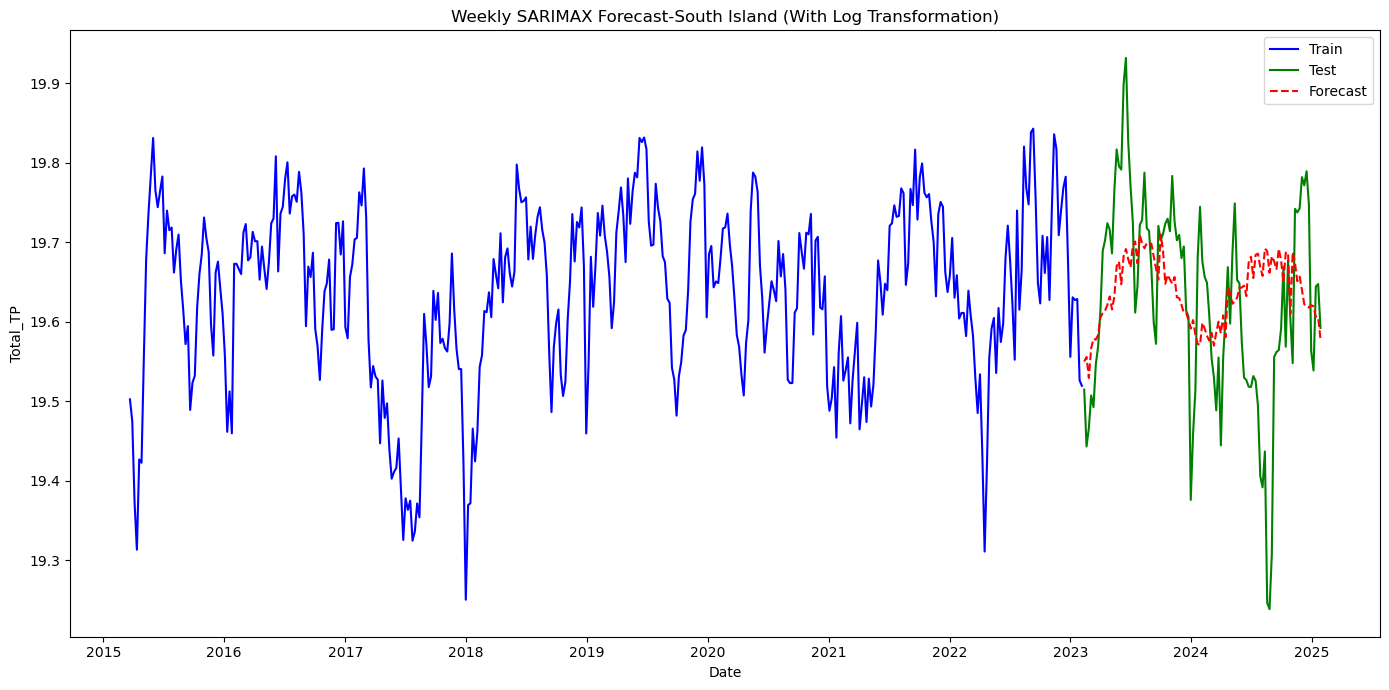

In [744]:
# Plot Actual vs. Forecast
plt.figure(figsize=(14, 7))
plt.plot(train_weekly.index, target_train_log, label='Train', color='blue')
plt.plot(test_weekly.index, target_test_log, label='Test', color='green')
plt.plot(test_weekly.index, forecast_log, label='Forecast', color='red', linestyle='--')
plt.xlabel("Date")
plt.ylabel("Total_TP")
plt.title("Weekly SARIMAX Forecast-South Island (With Log Transformation)")
plt.legend()
plt.tight_layout()
plt.show()

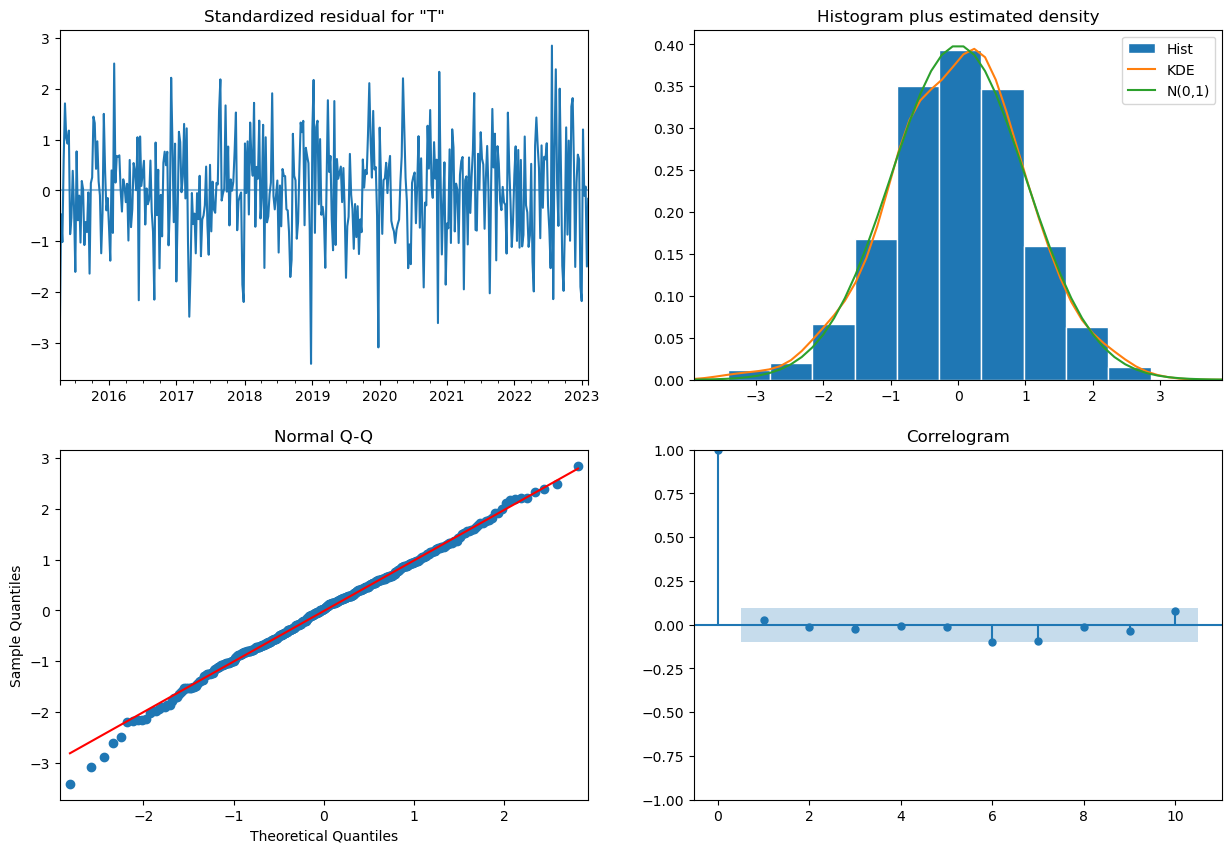

In [746]:
results.plot_diagnostics(figsize=(15, 10))
plt.show()

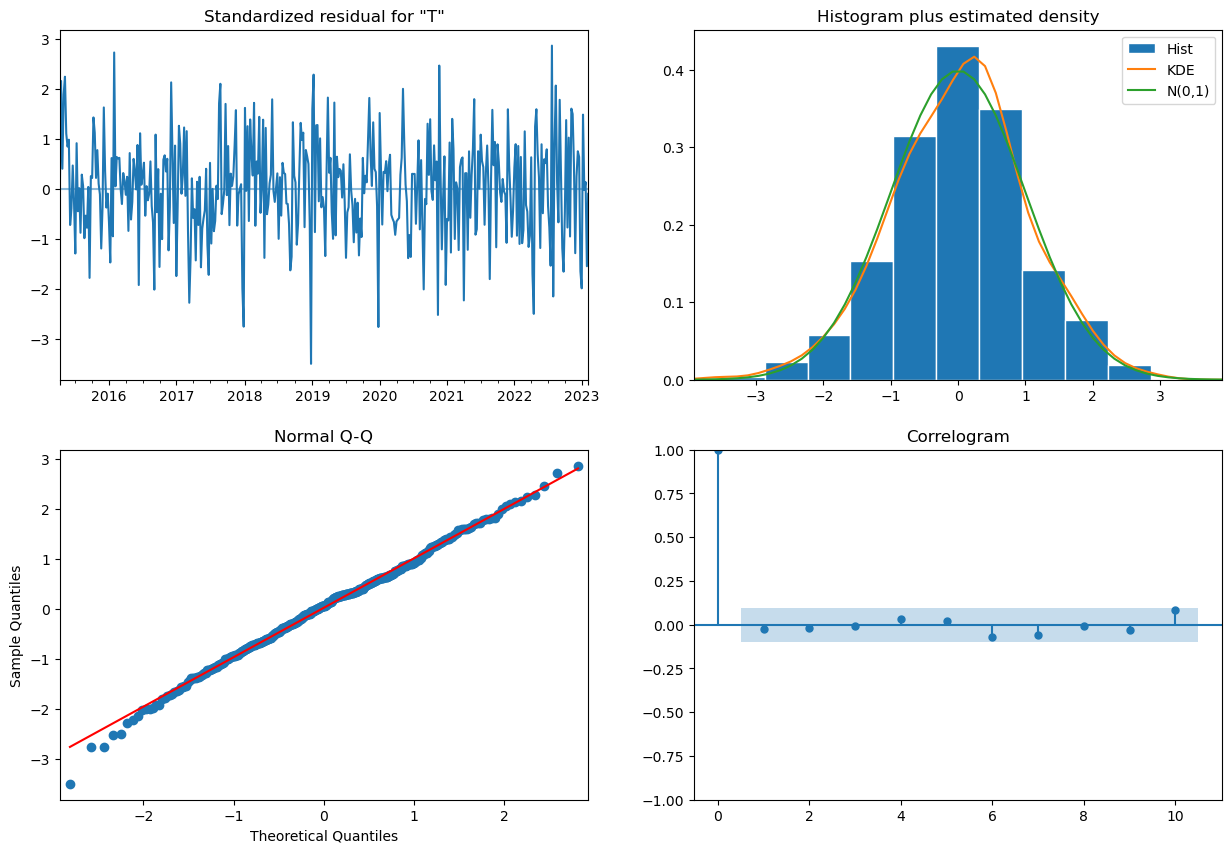

In [748]:
results_log.plot_diagnostics(figsize=(15, 10))
plt.show()

In [ ]:
#################################################################

## Total - New Zealand 

### Daily analysis

In [752]:
# # # ---------Weekly------------------ 
# df_hydro_weekly_tmp
# df_south_island_weekly_tmp
# df_north_island_weekly_tmp

# # ---------Daily-------------------

# df_hydro_daily_tmp
# df_south_daily_tmp
# df_north_daily_tmp

In [754]:
print(df_hydro_daily_tmp.head())

                Total_TP  PRECTOTCORR  EVLAND       RH2M  GWETPROF        T2M  \
DATE                                                                            
2015-03-08  4.983312e+07        29.84   75.87  74.559150  0.410654  13.733595   
2015-03-09  5.917801e+07         6.86   55.59  73.314984  0.408971  14.516062   
2015-03-10  5.951784e+07        31.58   57.04  71.949330  0.406748  15.891160   
2015-03-11  5.934205e+07        63.90   52.15  79.830033  0.406127  15.019967   
2015-03-12  6.098345e+07       196.91   72.07  83.761585  0.409134  15.030425   

            PRECIP_7d  PRECIP_14d  PRECIP_lag1  PRECIP_lag7  
DATE                                                         
2015-03-08     971.38     1024.12       309.16        52.74  
2015-03-09     805.22     1030.98        29.84       173.02  
2015-03-10     783.87     1062.56         6.86        52.93  
2015-03-11     813.84     1126.46        31.58        33.93  
2015-03-12     996.71     1323.37        63.90        14.04 

In [756]:
# Find rows with zero Total_TP in South Island
zero_df_wind_nz = df_hydro_daily_tmp[df_hydro_daily_tmp['Total_TP'] == 0]

# Get the unique dates
zero_dates = zero_df_wind_nz.index.unique()

# Display the result
print("Dates with Total_TP = 0 in New Zealand:")
for date in zero_dates:
    print(date.strftime('%Y-%m-%d'))

Dates with Total_TP = 0 in New Zealand:


In [ ]:
# # Check for missing values before handling
# nan_count = df_WWD1102_weekly['Total_TP'].isna().sum()
# print("Number of NaN values before cleaning:", nan_count)

# # Apply time-based interpolation
# df_WWD1102_weekly['Total_TP'] = df_WWD1102_weekly['Total_TP'].interpolate(method='time')

# # Verify that there are no more missing values
# nan_count_after = df_WWD1102_weekly['Total_TP'].isna().sum()
# print("Number of NaN values after interpolation:", nan_count_after)

# # Optionally, inspect the imputed records
# imputed_records = df_WWD1102_weekly[df_WWD1102_weekly['Total_TP'].isna()]
# print("Imputed Records (should be empty):")
# print(imputed_records)


In [ ]:
# # Apply time interpolation to the target variable and exogenous variables
# cols_to_interpolate = ['PS','T2M','WD50M','WD50M_rad','u','v','WS50M']
# df_WWD1102_weekly[cols_to_interpolate] = df_WWD1102_weekly[cols_to_interpolate].interpolate(method='time')

# # Verify that missing values have been filled
# print("Missing values after time interpolation:")
# print(df_WWD1102_weekly[cols_to_interpolate].isna().sum())

In [ ]:
# # stationery check for weekly data
# from statsmodels.tsa.stattools import adfuller

# # Assume df_model_for_forecasting has a datetime index and a 'Total_TP' column.
# result = adfuller(df_WWD1102_weekly['Total_TP'])
# print('ADF Statistic: %f' % result[0])
# print('p-value: %f' % result[1])
# print('Critical Values:')
# for key, value in result[4].items():
#     print('\t%s: %.3f' % (key, value))

In [758]:
# Split the daily data into 80% training and 20% testing sets
n = len(df_hydro_daily_tmp)
train_size = int(n * 0.8)
train_daily = df_hydro_daily_tmp.iloc[:train_size]
test_daily = df_hydro_daily_tmp.iloc[train_size:]

In [760]:
print("Daily Train set:", train_daily.index.min(), "to", train_daily.index.max() , "Records Count : " , len(train_daily))
print("Daily Test set:", test_daily.index.min(), "to", test_daily.index.max(), "Records Count : " , len(test_daily))

Daily Train set: 2015-03-08 00:00:00 to 2023-02-07 00:00:00 Records Count :  2894
Daily Test set: 2023-02-08 00:00:00 to 2025-01-31 00:00:00 Records Count :  724


In [762]:
# Define the target variable (original Total_TP) and exogenous variables
# target_train_log = train_weekly['Total_TP_log']
# target_test_log = test_weekly['Total_TP_log']

target_train = train_daily['Total_TP']
target_test = test_daily['Total_TP']



In [796]:
exog_cols = ['RH2M', 'GWETPROF', 'PRECIP_14d' ]

In [798]:
exog_train = train_daily[exog_cols]
exog_test = test_daily[exog_cols]

In [800]:
# Fit SARIMAX on the original (non-log) target data
model = SARIMAX(target_train,
                exog=exog_train,
                order=(1, 1, 1),
                seasonal_order=(0, 0, 0, 0),
                enforce_stationarity=False,
                enforce_invertibility=False)
results = model.fit(disp=False)
print(results.summary())

C:\Users\nwn86\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nwn86\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:               Total_TP   No. Observations:                 2894
Model:               SARIMAX(1, 1, 1)   Log Likelihood              -48678.292
Date:                Fri, 18 Apr 2025   AIC                          97368.585
Time:                        10:49:38   BIC                          97404.401
Sample:                    03-08-2015   HQIC                         97381.492
                         - 02-07-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
RH2M       -8.976e+04   2.81e+04     -3.194      0.001   -1.45e+05   -3.47e+04
GWETPROF    3.211e+07      5.445    5.9e+06      0.000    3.21e+07    3.21e+07
PRECIP_14d  -338.2110    389.210     -0.869      0.3

In [801]:
# Forecast on the test set - non log
n_steps = len(test_daily)
forecast_daily = results.get_forecast(steps=n_steps, exog=exog_test).predicted_mean

In [804]:
# Compute performance metrics - non log
rmse = np.sqrt(mean_squared_error(target_test, forecast_daily))
mae = mean_absolute_error(target_test, forecast_daily)
epsilon = 1e-10  # small constant to avoid division by zero in MAPE
mape = np.mean(np.abs((target_test - forecast) / (target_test + epsilon))) * 100

print("\nForecast Performance Metrics (Without Log Transformation):")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"Adjusted MAPE: {mape:.2f}%")


Forecast Performance Metrics (Without Log Transformation):
RMSE: 9887841.70
MAE: 7789566.31
Adjusted MAPE: 469.98%


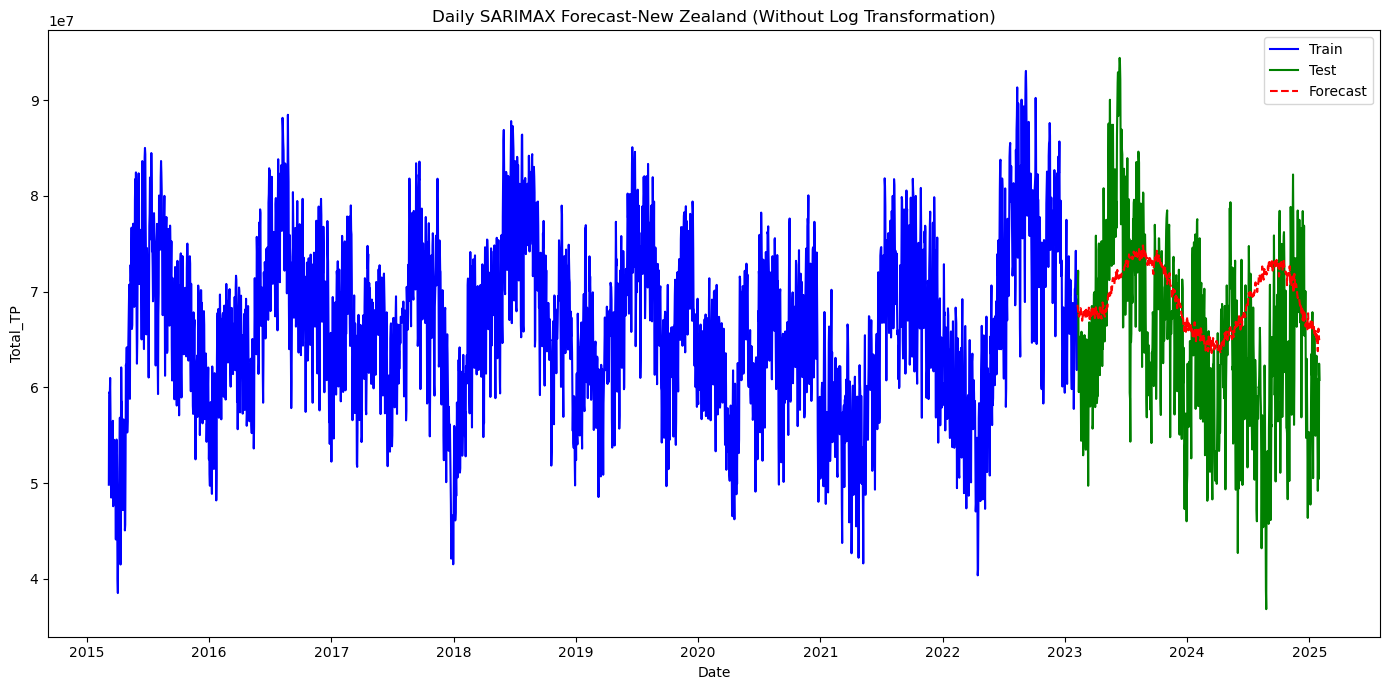

In [806]:
# Plot Actual vs. Forecast
plt.figure(figsize=(14, 7))
plt.plot(train_daily.index, target_train, label='Train', color='blue')
plt.plot(test_daily.index, target_test, label='Test', color='green')
plt.plot(test_daily.index, forecast_daily, label='Forecast', color='red', linestyle='--')
plt.xlabel("Date")
plt.ylabel("Total_TP")
plt.title("Daily SARIMAX Forecast-New Zealand (Without Log Transformation)")
plt.legend()
plt.tight_layout()
plt.show()

In [810]:
# # Create a log-transformed target. Adding 1 to avoid log(0) if needed.
df_hydro_daily_tmp['Total_TP_log'] = np.log(df_hydro_daily_tmp['Total_TP'] + 1)

In [812]:
# Split the weekly data into 80% training and 20% testing sets
n = len(df_hydro_daily_tmp)
train_size = int(n * 0.8)
train_daily = df_hydro_daily_tmp.iloc[:train_size]
test_daily = df_hydro_daily_tmp.iloc[train_size:]

In [814]:
print("Daily Train set:", train_daily.index.min(), "to", train_daily.index.max())
print("Daily Test set:", test_daily.index.min(), "to", test_daily.index.max())

Daily Train set: 2015-03-08 00:00:00 to 2023-02-07 00:00:00
Daily Test set: 2023-02-08 00:00:00 to 2025-01-31 00:00:00


In [816]:
# Define the target variable (original Total_TP) and exogenous variables
target_train_log = train_daily['Total_TP_log']
target_test_log = test_daily['Total_TP_log']

# target_train = train_weekly['Total_TP']
# target_test = test_weekly['Total_TP']

#exog_cols = ['WS50M','PS']
#exog_cols = ['WS50M']
exog_train = train_daily[exog_cols]
exog_test = test_daily[exog_cols]

In [818]:
# Fit SARIMAX on the original (log) target data
model_log = SARIMAX(target_train_log,
                exog=exog_train,
                order=(1, 1, 1),
                seasonal_order=(0, 0, 0, 0),
                enforce_stationarity=False,
                enforce_invertibility=False)
results_log = model_log.fit(disp=False)
print(results_log.summary())

C:\Users\nwn86\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nwn86\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:           Total_TP_log   No. Observations:                 2894
Model:               SARIMAX(1, 1, 1)   Log Likelihood                3088.625
Date:                Fri, 18 Apr 2025   AIC                          -6165.249
Time:                        10:50:43   BIC                          -6129.433
Sample:                    03-08-2015   HQIC                         -6152.342
                         - 02-07-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
RH2M          -0.0013      0.000     -3.469      0.001      -0.002      -0.001
GWETPROF       0.5389      0.376      1.433      0.152      -0.198       1.276
PRECIP_14d -5.913e-06   9.85e-06     -0.600      0.5

C:\Users\nwn86\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [820]:
# Forecast on the test set
n_steps_log = len(test_daily)
forecast_log = results_log.get_forecast(steps=n_steps_log, exog=exog_test).predicted_mean

In [822]:
# Compute performance metrics
rmse = np.sqrt(mean_squared_error(target_test_log, forecast_log))
mae = mean_absolute_error(target_test_log, forecast_log)
epsilon = 1e-10  # small constant to avoid division by zero in MAPE
mape = np.mean(np.abs((target_test_log - forecast_log) / (target_test_log + epsilon))) * 100

print("\nForecast Performance Metrics (With Log Transformation):")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"Adjusted MAPE: {mape:.2f}%")


Forecast Performance Metrics (With Log Transformation):
RMSE: 0.17
MAE: 0.13
Adjusted MAPE: 0.73%


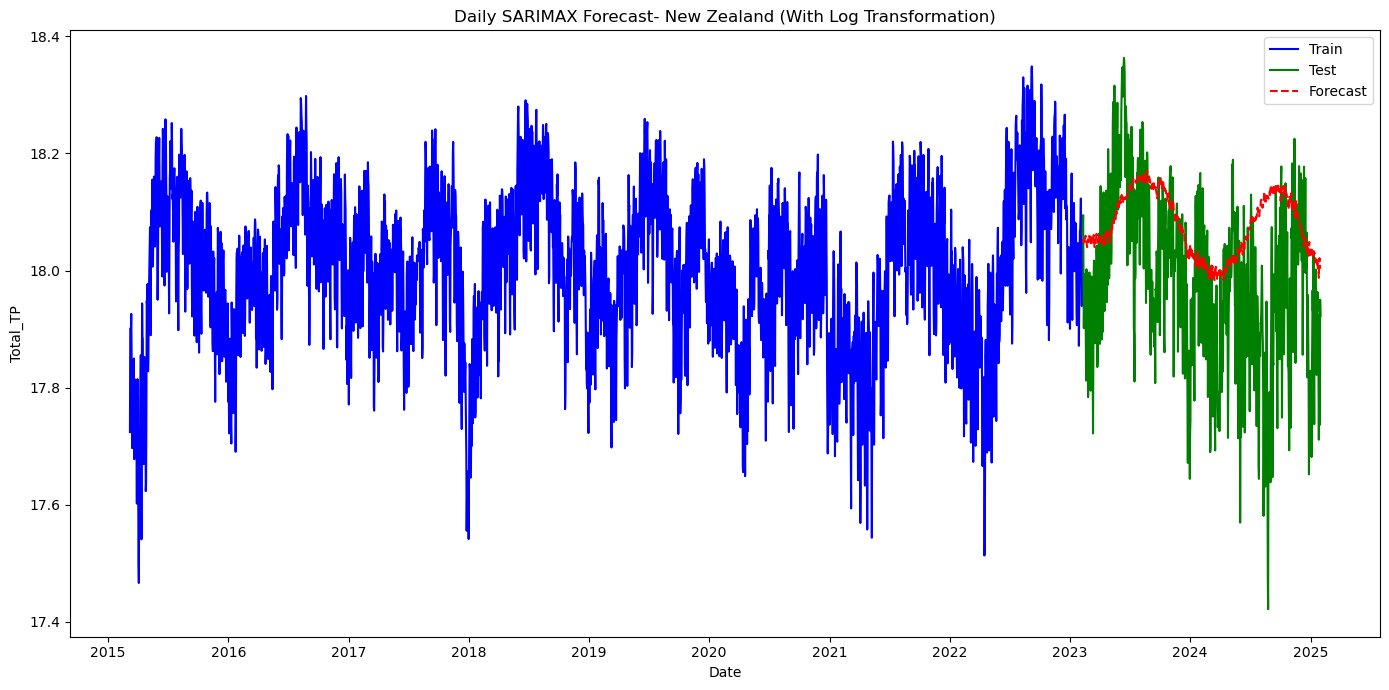

In [824]:
# Plot Actual vs. Forecast
plt.figure(figsize=(14, 7))
plt.plot(train_daily.index, target_train_log, label='Train', color='blue')
plt.plot(test_daily.index, target_test_log, label='Test', color='green')
plt.plot(test_daily.index, forecast_log, label='Forecast', color='red', linestyle='--')
plt.xlabel("Date")
plt.ylabel("Total_TP")
plt.title("Daily SARIMAX Forecast- New Zealand (With Log Transformation)")
plt.legend()
plt.tight_layout()
plt.show()

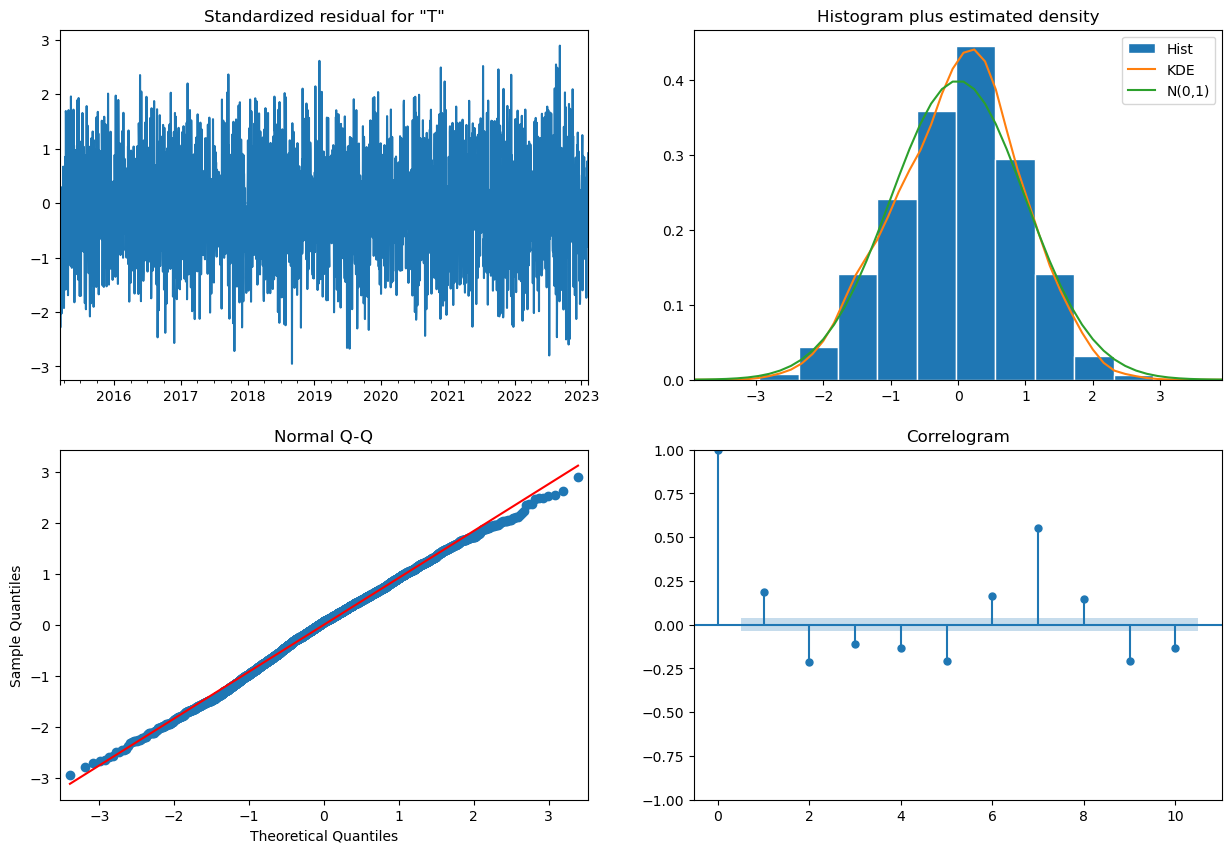

In [826]:
results.plot_diagnostics(figsize=(15, 10))
plt.show()

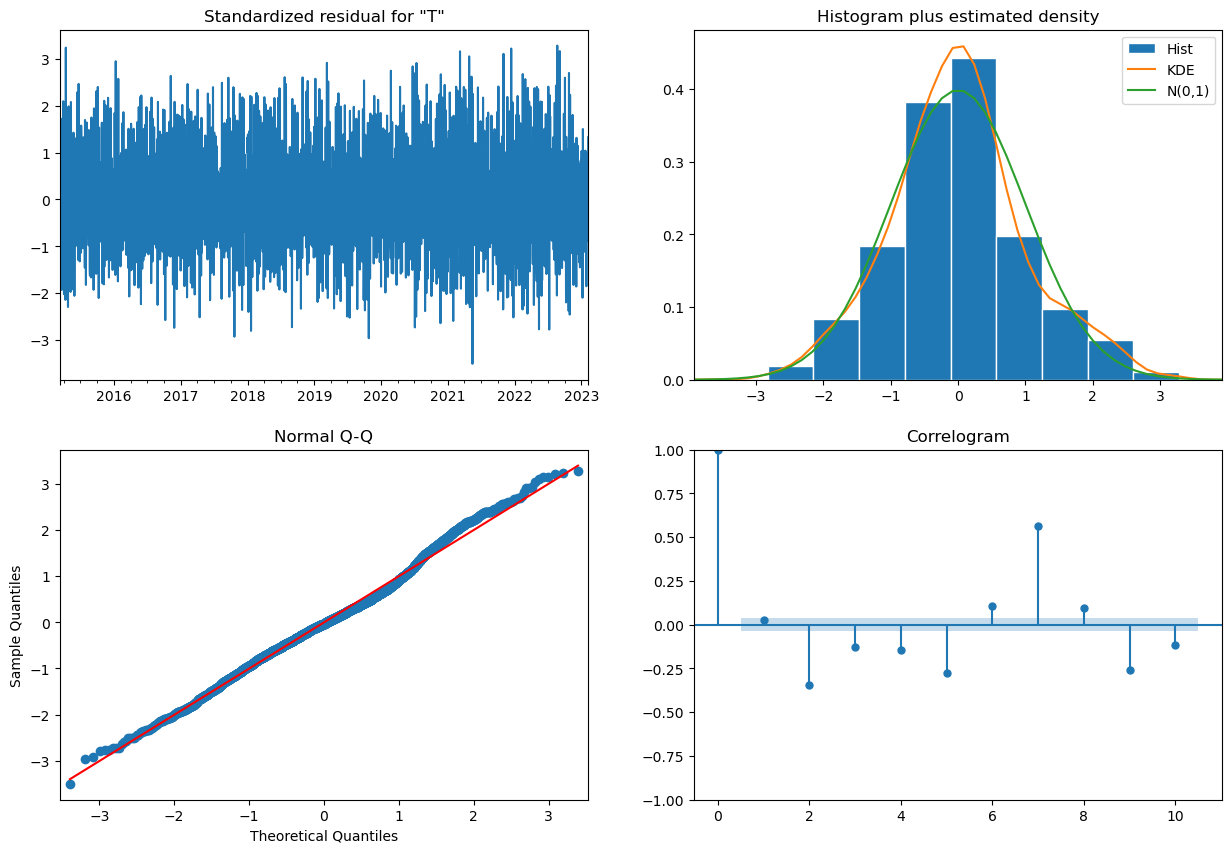

In [828]:
results_log.plot_diagnostics(figsize=(15, 10))
plt.show()

### Weekly analysis for New Zealand

In [832]:
df_hydro_weekly_tmp.head(5)

Total_TP  PRECTOTCORR  EVLAND       RH2M  GWETPROF        T2M  \
DATE                                                                            
2015-03-22  3.662094e+08       663.87  403.97  75.378081  0.421662  10.907292   
2015-03-29  3.579528e+08       693.64  370.90  82.111349  0.421032  13.933543   
2015-04-05  3.299789e+08       233.77  352.36  78.754241  0.426779  13.300586   
2015-04-12  3.418926e+08      1188.17  352.14  84.487572  0.438959  13.012923   
2015-04-19  3.846722e+08       980.16  313.50  82.797304  0.467070   7.460507   

            PRECIP_lag1w  PRECIP_lag2w  API_weekly  
DATE                                                
2015-03-22        529.00        971.38  786.227200  
2015-03-29        663.87        529.00  758.451040  
2015-04-05        693.64        663.87  601.046728  
2015-04-12        233.77        693.64  777.183710  
2015-04-19       1188.17        233.77  838.076597

In [ ]:
# df_island_daily_upd_new_v1['PRECTOTCORR_lag1'] = df_island_daily_upd_new_v1['PRECTOTCORR'].shift(1)  # 1-week lag

In [ ]:
# df_island_daily_cln = df_island_daily_upd_new_v1.dropna()

In [834]:
# Find rows with zero Total_TP in New Zealand
zero_tp_nz = df_hydro_weekly_tmp[df_hydro_weekly_tmp['Total_TP'] == 0]

# Get the unique dates
zero_dates = zero_tp_nz.index.unique()

# Display the result
print("Dates with Total_TP = 0 in New Zealand :")
for date in zero_dates:
    print(date.strftime('%Y-%m-%d'))

Dates with Total_TP = 0 in New Zealand :


In [960]:
# Split the weekly data into 80% training and 20% testing sets
n = len(df_hydro_weekly_tmp)
train_size = int(n * 0.8)
train_weekly = df_hydro_weekly_tmp.iloc[:train_size]
test_weekly = df_hydro_weekly_tmp.iloc[train_size:]

In [962]:
print("Weekly Train set:", train_weekly.index.min(), "to", train_weekly.index.max())
print("Weekly Test set:", test_weekly.index.min(), "to", test_weekly.index.max())

Weekly Train set: 2015-03-22 00:00:00 to 2023-02-05 00:00:00
Weekly Test set: 2023-02-12 00:00:00 to 2025-01-26 00:00:00


In [964]:
# Define the target variable (original Total_TP) and exogenous variables
# target_train_log = train_weekly['Total_TP_log']
# target_test_log = test_weekly['Total_TP_log']

target_train = train_weekly['Total_TP']
target_test = test_weekly['Total_TP']



In [1025]:
#['Total_TP', 'PRECTOTCORR', 'EVLAND', 'RH2M', 'GWETPROF', 'T2M', 'PRECIP_lag1w', 'PRECIP_lag2w', 'API_weekly']
# exog_cols_wk = ['RH2M', 'GWETPROF', 'PRECIP_lag1w', 'PRECIP_lag2w', 'API_weekly']
exog_cols_wk = ['GWETPROF', 'API_weekly']

In [1027]:
#exog_cols = ['RH2M','GWETPROF','PRECTOTCORR_lag1']
#exog_cols = ['RH2M', 'GWETPROF', 'EVLAND', 'T2M']
#exog_cols = ['RH2M', 'GWETPROF', 'EVLAND', 'T2M','PRECTOTCORR_lag1']
#exog_cols = ['T2M','PRECTOTCORR_lag7','GWETPROF']
#exog_cols = ['EVLAND','T2M']
#exog_cols = ['GWETPROF','EVLAND','T2M']
#exog_cols = ['PRECTOTCORR','GWETPROF','EVLAND','T2M']
#exog_cols = ['RH2M','PRECTOTCORR','GWETPROF','EVLAND','T2M']
#exog_cols = ['WS50M']
#exog_cols = ['WS50M','PS']
#exog_cols = ['WS50M']
# exog_train = train_weekly[exog_cols]
# exog_test = test_weekly[exog_cols]

# exog_cols = ['WS50M','PS']
#exog_cols = ['WS50M']
exog_train = train_weekly[exog_cols_wk]
exog_test = test_weekly[exog_cols_wk]

In [1029]:
# Fit SARIMAX on the original (non-log) target data
model = SARIMAX(target_train,
                exog=exog_train,
                order=(1, 1, 1),
                seasonal_order=(0, 0, 0, 0),
                enforce_stationarity=False,
                enforce_invertibility=False)
results = model.fit(disp=False)
print(results.summary())

C:\Users\nwn86\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
C:\Users\nwn86\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:               Total_TP   No. Observations:                  412
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -7528.204
Date:                Fri, 18 Apr 2025   AIC                          15066.407
Time:                        12:09:38   BIC                          15086.476
Sample:                    03-22-2015   HQIC                         15074.348
                         - 02-05-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
GWETPROF    3.367e+08      0.287   1.17e+09      0.000    3.37e+08    3.37e+08
API_weekly -2.788e+04   9164.009     -3.042      0.002   -4.58e+04   -9917.378
ar.L1          0.6230      0.041     15.198      0.0

In [1031]:
# Forecast on the test set - non log
n_steps = len(test_weekly)
forecast = results.get_forecast(steps=n_steps, exog=exog_test).predicted_mean

In [1033]:
# Compute performance metrics - non log
rmse = np.sqrt(mean_squared_error(target_test, forecast))
mae = mean_absolute_error(target_test, forecast)
epsilon = 1e-10  # small constant to avoid division by zero in MAPE
mape = np.mean(np.abs((target_test - forecast) / (target_test + epsilon))) * 100

print("\nForecast Performance Metrics (Without Log Transformation):")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"Adjusted MAPE: {mape:.2f}%")


Forecast Performance Metrics (Without Log Transformation):
RMSE: 70838432.15
MAE: 57260251.89
Adjusted MAPE: 13.34%


In [1035]:
print("Minimum of actual values in test set:", target_test.min())
print("Number of zeros in actual test set:", np.sum(target_test == 0))

Minimum of actual values in test set: 345563712.0
Number of zeros in actual test set: 0


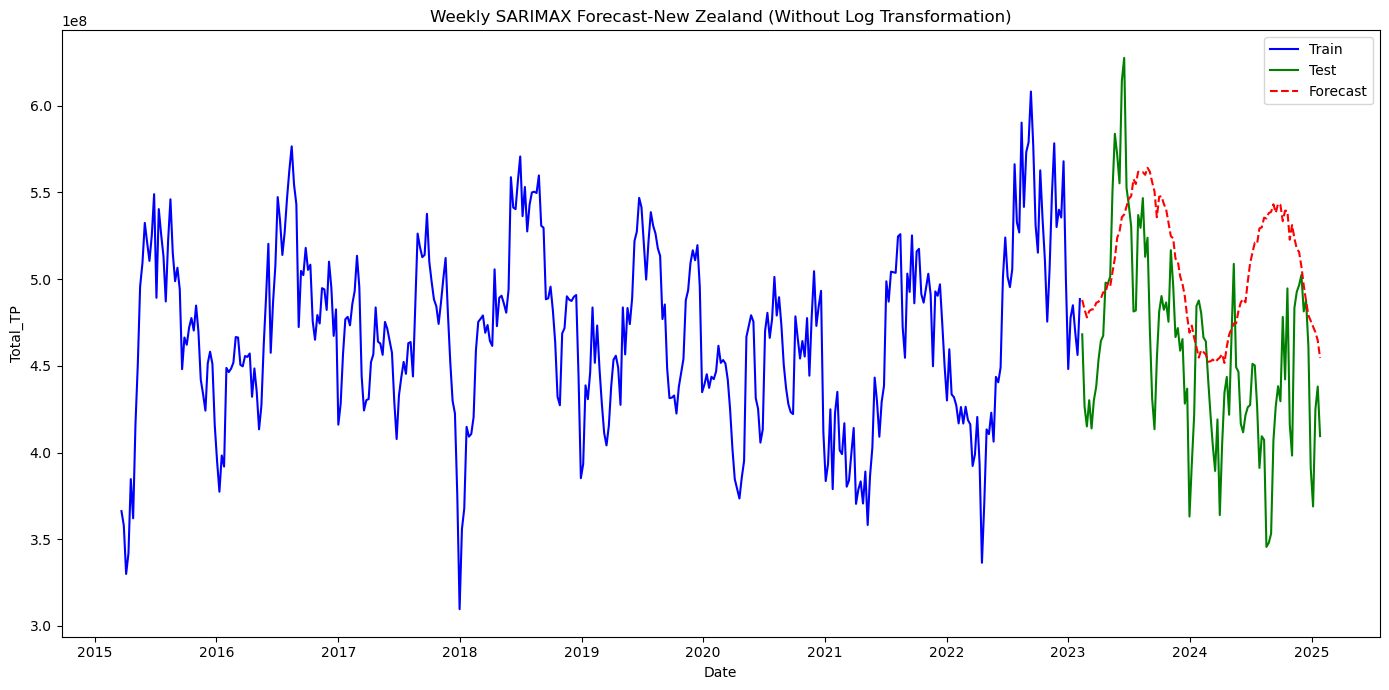

In [1037]:
# Plot Actual vs. Forecast
plt.figure(figsize=(14, 7))
plt.plot(train_weekly.index, target_train, label='Train', color='blue')
plt.plot(test_weekly.index, target_test, label='Test', color='green')
plt.plot(test_weekly.index, forecast, label='Forecast', color='red', linestyle='--')
plt.xlabel("Date")
plt.ylabel("Total_TP")
plt.title("Weekly SARIMAX Forecast-New Zealand (Without Log Transformation)")
plt.legend()
plt.tight_layout()
plt.show()

In [908]:
# # Create a log-transformed target. Adding 1 to avoid log(0) if needed.
df_hydro_weekly_tmp['Total_TP_log'] = np.log(df_hydro_weekly_tmp['Total_TP'] + 1)

In [910]:
# Split the weekly data into 80% training and 20% testing sets
n = len(df_hydro_weekly_tmp)
train_size = int(n * 0.8)
train_weekly_log = df_hydro_weekly_tmp.iloc[:train_size]
test_weekly_log = df_hydro_weekly_tmp.iloc[train_size:]

In [912]:
print("Weekly Train set:", train_weekly_log.index.min(), "to", train_weekly_log.index.max())
print("Weekly Test set:", test_weekly_log.index.min(), "to", test_weekly_log.index.max())

Weekly Train set: 2015-03-22 00:00:00 to 2023-02-05 00:00:00
Weekly Test set: 2023-02-12 00:00:00 to 2025-01-26 00:00:00


In [914]:
# Define the target variable (original Total_TP) and exogenous variables
target_train_log = train_weekly_log['Total_TP_log']
target_test_log = test_weekly_log['Total_TP_log']

# target_train = train_weekly['Total_TP']
# target_test = test_weekly['Total_TP']



In [1039]:
#['Total_TP', 'PRECTOTCORR', 'EVLAND', 'RH2M', 'GWETPROF', 'T2M', 'PRECIP_lag1w', 'PRECIP_lag2w', 'API_weekly']
# exog_cols_wk = ['RH2M', 'GWETPROF', 'PRECIP_lag1w', 'PRECIP_lag2w', 'API_weekly']
exog_cols_wk = ['GWETPROF', 'API_weekly']

In [1041]:
# exog_cols = ['RH2M','GWETPROF','PRECTOTCORR_lag1']
#exog_cols = ['RH2M', 'GWETPROF', 'EVLAND', 'T2M']
#exog_cols = ['RH2M', 'GWETPROF', 'EVLAND', 'T2M','PRECTOTCORR_lag1']
#exog_cols = ['T2M','PRECTOTCORR_lag7','GWETPROF']
#exog_cols = ['EVLAND','T2M']
#exog_cols = ['GWETPROF','EVLAND','T2M']
#exog_cols = ['PRECTOTCORR','GWETPROF','EVLAND','T2M']
#exog_cols = ['RH2M','PRECTOTCORR','GWETPROF','EVLAND','T2M']
#exog_cols = ['WS50M']
#exog_cols = ['WS50M','PS']
#exog_cols = ['WS50M']
# exog_train = train_weekly[exog_cols]
# exog_test = test_weekly[exog_cols]

# exog_cols = ['WS50M','PS']
#exog_cols = ['WS50M']
exog_train = train_weekly[exog_cols_wk]
exog_test = test_weekly[exog_cols_wk]

In [1043]:
# Fit SARIMAX on the original (log) target data
model_log = SARIMAX(target_train_log,
                exog=exog_train,
                order=(1, 1, 1),
                seasonal_order=(0, 0, 0, 0),
                enforce_stationarity=False,
                enforce_invertibility=False)
results_log = model_log.fit(disp=False)
print(results_log.summary())

C:\Users\nwn86\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
C:\Users\nwn86\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:           Total_TP_log   No. Observations:                  412
Model:               SARIMAX(1, 1, 1)   Log Likelihood                 627.134
Date:                Fri, 18 Apr 2025   AIC                          -1244.267
Time:                        12:10:11   BIC                          -1224.199
Sample:                    03-22-2015   HQIC                         -1236.327
                         - 02-05-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
GWETPROF       0.7288      0.126      5.768      0.000       0.481       0.976
API_weekly  -5.75e-05   2.03e-05     -2.832      0.005   -9.73e-05   -1.77e-05
ar.L1          0.8457      0.076     11.090      0.0

C:\Users\nwn86\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [1045]:
# Forecast on the test set
n_steps_log = len(test_weekly_log)
forecast_log = results_log.get_forecast(steps=n_steps_log, exog=exog_test).predicted_mean

In [1047]:
# Compute performance metrics
rmse = np.sqrt(mean_squared_error(target_test_log, forecast_log))
mae = mean_absolute_error(target_test_log, forecast_log)
epsilon = 1e-10  # small constant to avoid division by zero in MAPE
mape = np.mean(np.abs((target_test_log - forecast_log) / (target_test_log + epsilon))) * 100

print("\nForecast Performance Metrics (With Log Transformation):")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"Adjusted MAPE: {mape:.2f}%")


Forecast Performance Metrics (With Log Transformation):
RMSE: 0.15
MAE: 0.12
Adjusted MAPE: 0.58%


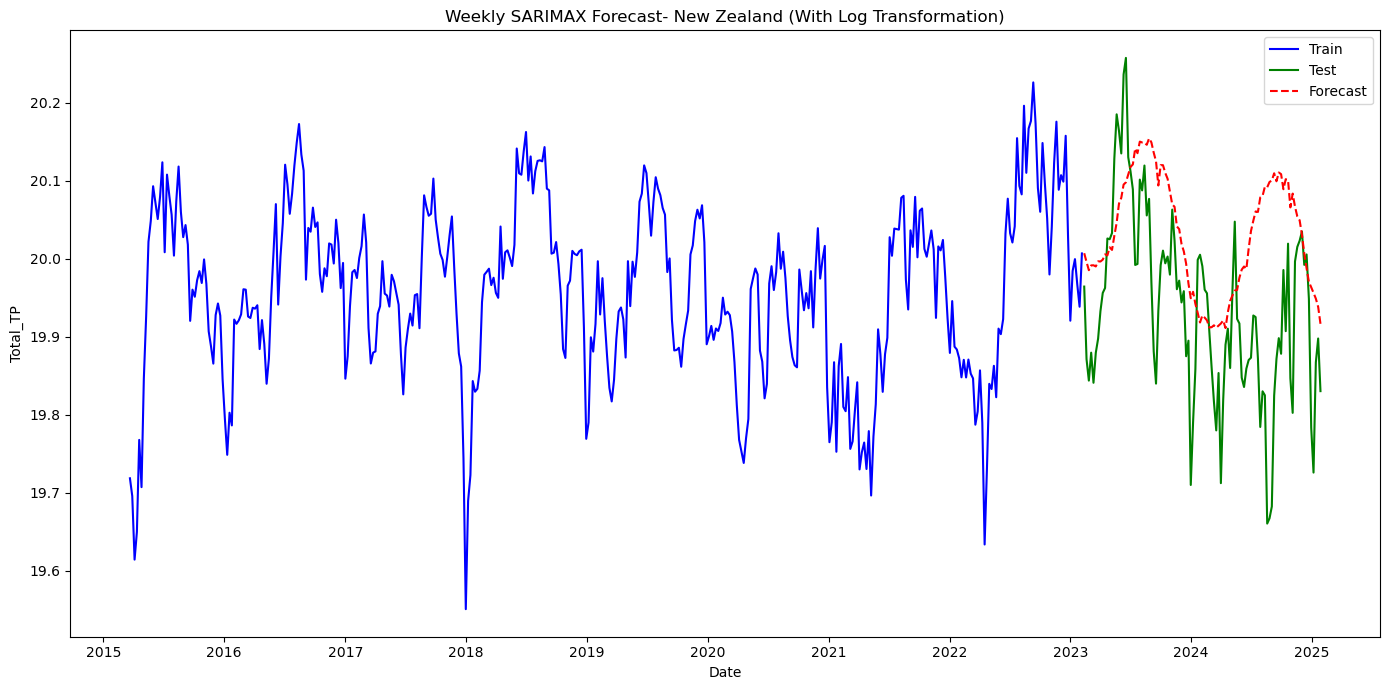

In [1050]:
# Plot Actual vs. Forecast
plt.figure(figsize=(14, 7))
plt.plot(train_weekly.index, target_train_log, label='Train', color='blue')
plt.plot(test_weekly.index, target_test_log, label='Test', color='green')
plt.plot(test_weekly.index, forecast_log, label='Forecast', color='red', linestyle='--')
plt.xlabel("Date")
plt.ylabel("Total_TP")
plt.title("Weekly SARIMAX Forecast- New Zealand (With Log Transformation)")
plt.legend()
plt.tight_layout()
plt.show()

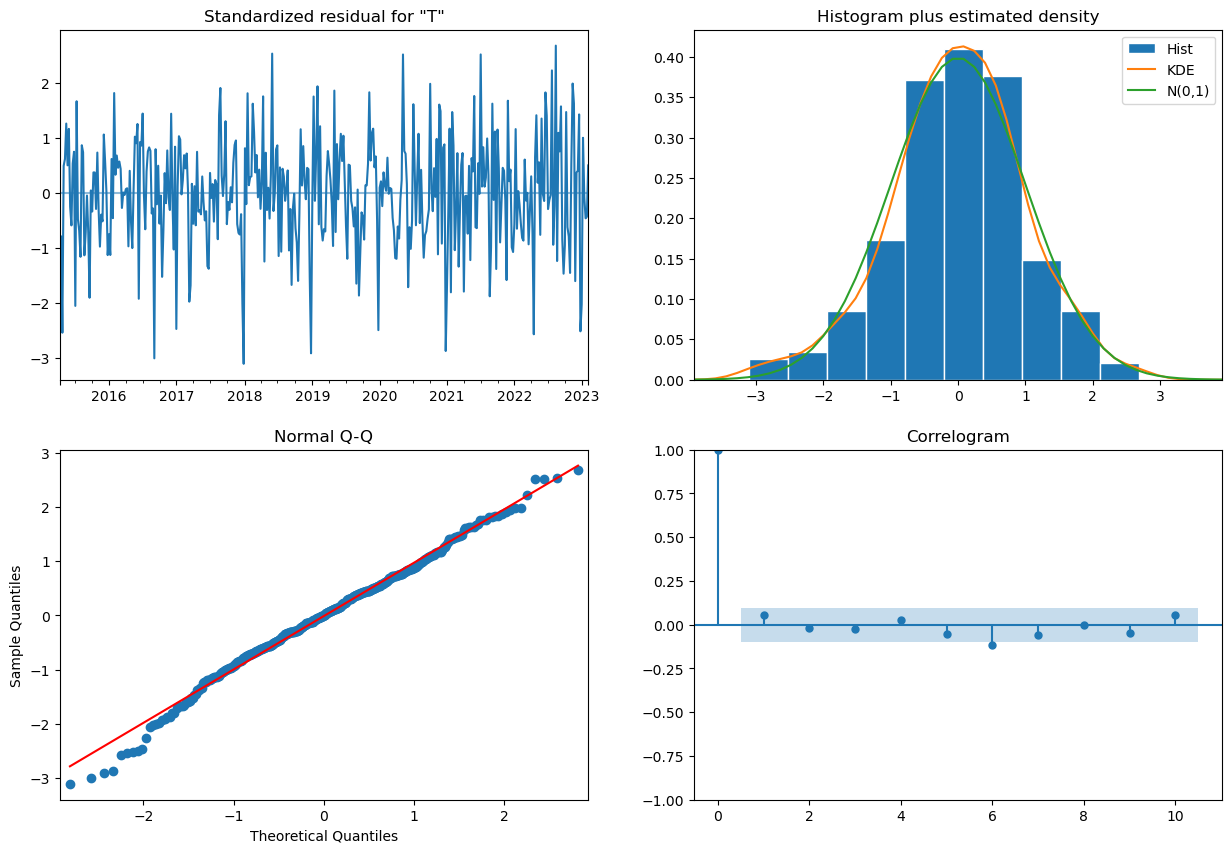

In [928]:
results.plot_diagnostics(figsize=(15, 10))
plt.show()

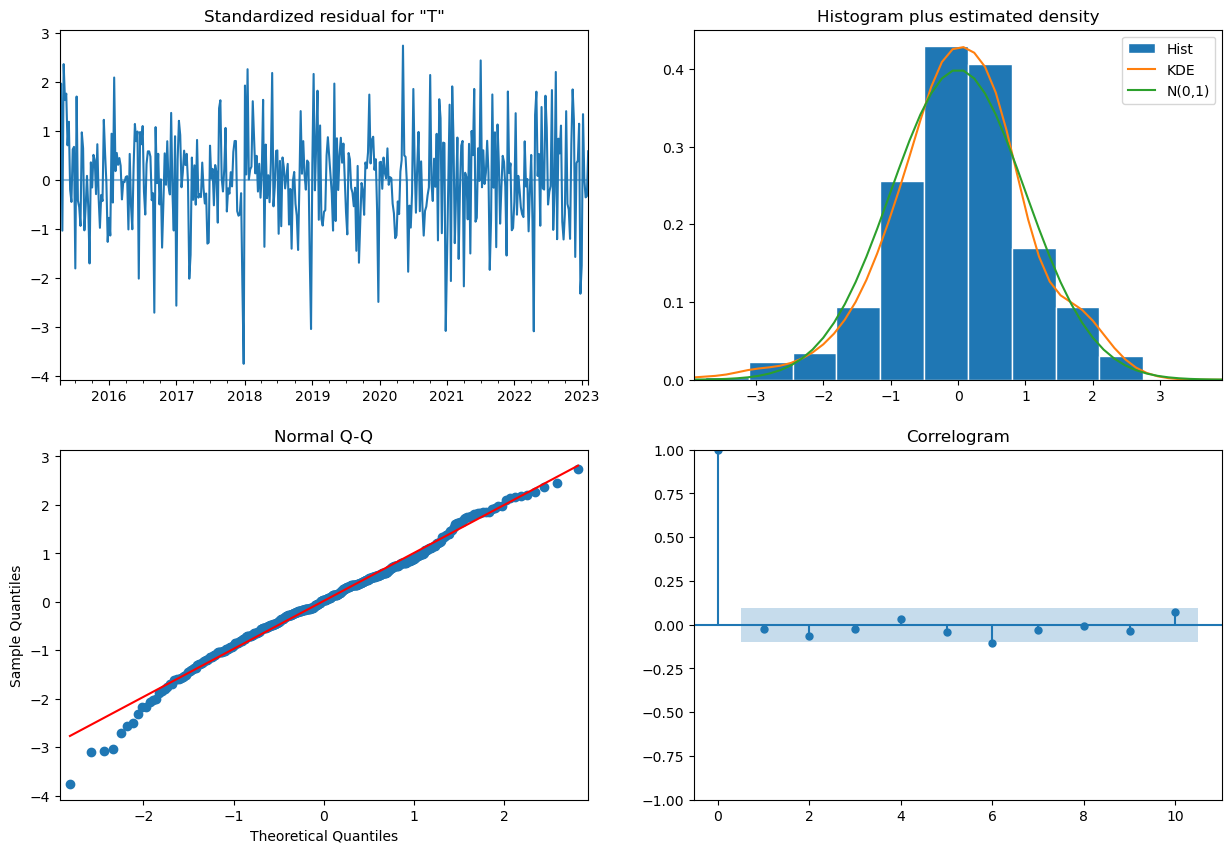

In [930]:
results_log.plot_diagnostics(figsize=(15, 10))
plt.show()

In [ ]:
results.plot_diagnostics(figsize=(15, 10))
plt.show()

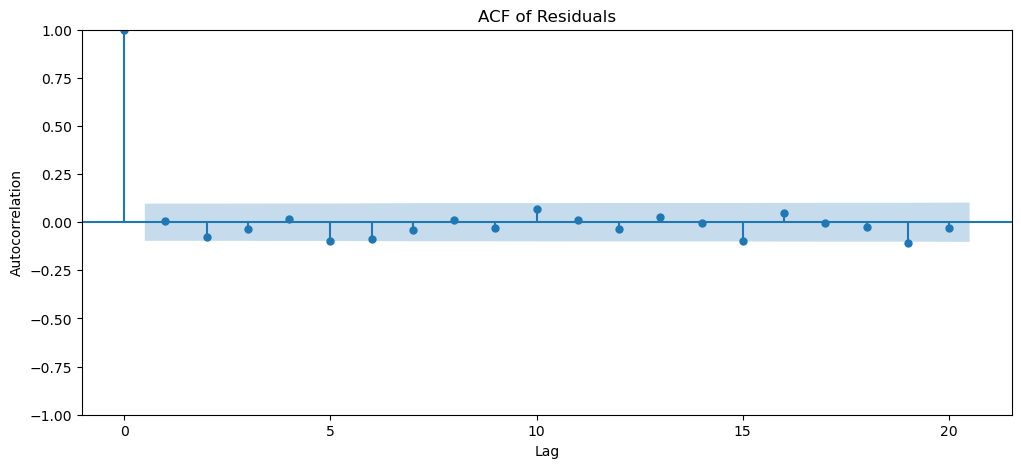

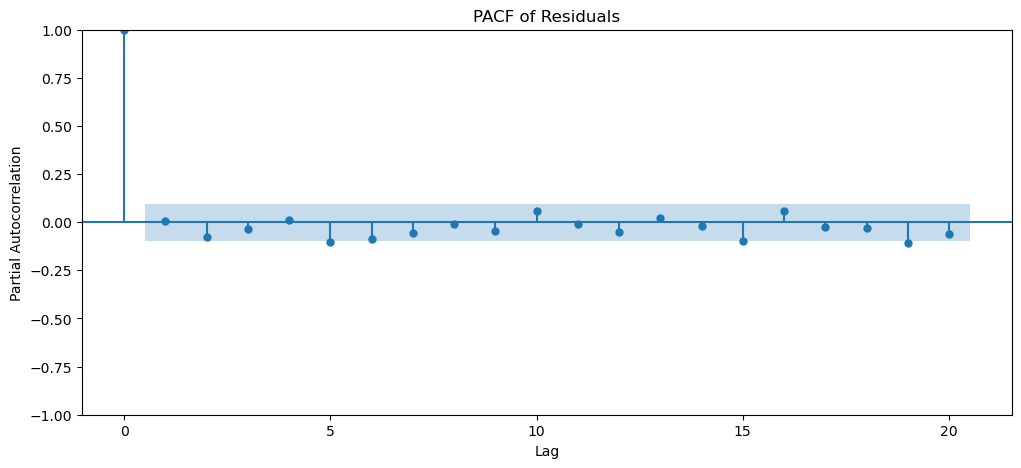

In [932]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Assuming 'results' is your fitted SARIMAX model and results.resid contains the residuals.
residuals = results.resid

# Plot ACF for residuals
plt.figure(figsize=(12, 5))
plot_acf(residuals, lags=20, ax=plt.gca())
plt.title('ACF of Residuals')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

# Plot PACF for residuals
plt.figure(figsize=(12, 5))
plot_pacf(residuals, lags=20, ax=plt.gca(), method='ywm')
plt.title('PACF of Residuals')
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.show()


In [1056]:
# df_hydro_weekly.head()

In [ ]:
# # All Island Weekly
# # df_hydro_weekly['PRECIP_7d'] = df_hydro_weekly['PRECTOTCORR'].rolling(7, min_periods=1).sum() #Rolling sums - total rain over the last 7 days
# # df_hydro_weekly['PRECIP_14d'] = df_hydro_weekly['PRECTOTCORR'].rolling(14, min_periods=1).sum() #Rolling sums - total rain over the last 7 days
# # df_hydro_weekly['PRECIP_lag1'] = df_hydro_weekly['PRECTOTCORR'].shift(1) # Lagged values yesterday’s rain
# # df_hydro_weekly['PRECIP_lag7'] = df_hydro_weekly['PRECTOTCORR'].shift(7) # Lagged values last week’s rain
# df_hydro_weekly['PRECIP_lag1w'] = df_hydro_weekly['PRECTOTCORR'].shift(1)
# df_hydro_weekly['PRECIP_lag2w'] = df_hydro_weekly['PRECTOTCORR'].shift(2)
# df_hydro_weekly['API_weekly'] = df_hydro_weekly['PRECTOTCORR'].ewm(alpha=0.3, adjust=False).mean()